In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
# import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
# import pickle
import scipy.stats as stats


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data (2015, 2016, and 2017 currently)

<span style="color:red">Some caution here: Reading everything in below will be slow and consume a decent amount of memory. If you just want the selected variables that are relevant/plotted, and height cooridnates as the vertical, then scroll down and read in the datasets that were saved out as a .nc files previously. Still need to read in the non-CAM files though. </span>

In [4]:
## Now read in those files to avoid a lot overhead

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

# HMGcamDS_local = xr.load_dataset(saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)
# HTGcamDS_local = xr.load_dataset(saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)

HMGcamDS_local = xr.load_dataset(saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc', decode_times=True)
HTGcamDS_local = xr.load_dataset(saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc', decode_times=True)

## Belated realization that the heights computed are above *sea level* not above ground level. 
#    Need to subtract elevation. 
nateFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.bdate.nc'
nateDS = xr.open_dataset(nateFile, decode_times=True)
elevation = nateDS.alt.values

HMGcamDS_local['lev']  = HMGcamDS_local['lev'].values  - elevation[0][0]
HMGcamDS_local['ilev'] = HMGcamDS_local['ilev'].values - elevation[0][0] 
HTGcamDS_local['lev']  = HTGcamDS_local['lev'].values  - elevation[0][0]
HTGcamDS_local['ilev'] = HTGcamDS_local['ilev'].values - elevation[0][0]

HMGcamDS_local['PBLdepth']  = HMGcamDS_local['PBLdepth']  - elevation[0][0] 
HTGcamDS_local['PBLdepth']  = HTGcamDS_local['PBLdepth']  - elevation[0][0] 



In [5]:
## Add in TKE 

HMGcamDS_local['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_local['UP2_CLUBB']+HMGcamDS_local['VP2_CLUBB']+HMGcamDS_local['WP2_CLUBB']))  
HTGcamDS_local['TKE']  = (('time','ilev','lat,','lon'),
                          0.5*(HTGcamDS_local['UP2_CLUBB']+HTGcamDS_local['VP2_CLUBB']+HTGcamDS_local['WP2_CLUBB']))   


In [6]:
## Read in CLM files 

dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_'

yearStrings  = np.asarray(['2015','2016','2017','2018'])
dateEndFiles = np.asarray(['-05-31-84585.nc','-07-05-60585.nc','-08-09-36585.nc'])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    fileStart_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
    fileStartPatch_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    fileStartPatch_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    
    fileStart_atm = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        fileName_HMG = fileStart_HMG+dateEndFiles[iFile]
        fileName_HTG = fileStart_HTG+dateEndFiles[iFile]
                                                                                          
        fileNamePatch_HMG = fileStartPatch_HMG+dateEndFiles[iFile]
        fileNamePatch_HTG = fileStartPatch_HTG+dateEndFiles[iFile]
        
        with xr.open_dataset(fileStart_atm+dateEndFiles[iFile], decode_times=False) as HTGcamDS:
            HTGcamDS = cesm_correct_time(HTGcamDS)
            HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_HMG, decode_times=True) as HMG_clmDS: 
            HMG_clmDS['time'] = HTGcamDS['time']
        with xr.open_dataset(fileName_HTG, decode_times=True) as HTG_clmDS: 
            HTG_clmDS['time'] = HTGcamDS['time']
        with xr.open_dataset(fileNamePatch_HMG, decode_times=True) as HMG_clmPatchDS: 
            HMG_clmPatchDS['time'] = HTGcamDS['time']
        with xr.open_dataset(fileNamePatch_HTG, decode_times=True) as HTG_clmPatchDS: 
            HTG_clmPatchDS['time'] = HTGcamDS['time']       
        
        # Discard the first two days if iFile ==0  
        if iFile==0:
            iTimeStart   = np.where(HMG_clmDS.time.values >= (HMG_clmDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_clmDS.time.values))

            HTG_clmDS = HTG_clmDS.isel(time=timeArr)
            HMG_clmDS = HMG_clmDS.isel(time=timeArr)
            HTG_clmPatchDS = HTG_clmPatchDS.isel(time=timeArr)
            HMG_clmPatchDS = HMG_clmPatchDS.isel(time=timeArr)

        if fileCount==0:
            HTGclmDS_all = HTG_clmDS
            HMGclmDS_all = HMG_clmDS
            
            HTGclmDS_allPatch = HTG_clmPatchDS
            HMGclmDS_allPatch = HMG_clmPatchDS
            
        else: 
            HTGclmDS_all = xr.concat([HTGclmDS_all,HTG_clmDS], dim='time', data_vars='minimal')
            HMGclmDS_all = xr.concat([HMGclmDS_all,HMG_clmDS], dim='time', data_vars='minimal')
            
            HTGclmDS_allPatch = xr.concat([HTGclmDS_allPatch,HTG_clmPatchDS], dim='time', data_vars='minimal')
            HMGclmDS_allPatch = xr.concat([HMGclmDS_allPatch,HMG_clmPatchDS], dim='time', data_vars='minimal')
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 12 
Done with file 2 of 12 
Done with file 3 of 12 
Done with file 4 of 12 
Done with file 5 of 12 
Done with file 6 of 12 
Done with file 7 of 12 
Done with file 8 of 12 
Done with file 9 of 12 
Done with file 10 of 12 
Done with file 11 of 12 
Done with file 12 of 12 


## Start processing the data

**Let's keep just the important variables we think we'll care about**

In [49]:
# keepVars = np.asarray(['LHFLX','SHFLX',
#                        'PS','U10',
#                        'PBLH','TREFHT','QREFHT','RHREFHT',
#                        'PRECT','PRECC','PRECL','PRECZ',
#                        'CLDTOT', 'CLDLOW','CLDMED','CLDHGH','CLDBOT','TGCLDLWP',
#                        'CLOUD','RAINQM','CLDLIQ','CONCLD', 'GCLDLWP',
#                        'CLOUDCOVER_CLUBB',
#                        'CLOUDFRAC_CLUBB',
#                        'DCQ', 'QRL', 'QRS',
#                        'U', 'V','T',  'Q',
#                        'THLP2_CLUBB',
#                        'RTP2_CLUBB',
#                        'RTPTHLP_CLUBB',
#                        'UP2_CLUBB',
#                        'VP2_CLUBB',
#                        'WP2_CLUBB',
#                        'UPWP_CLUBB',
#                        'VPWP_CLUBB',
#                        'WM_ZT_CLUBB',
#                        'WP3_CLUBB',
#                        'WPTHVP_CLUBB',
#                        'WPRTP_CLUBB',
#                        'WPTHLP_CLUBB',
#                        'RVMTEND_CLUBB',
#                        'STEND_CLUBB',
#                        'UTEND_CLUBB',
#                        'hyai','hybi','hyam','hybm','P0'])

# HTGcamDS_all = HTGcamDS_all[keepVars]
# HMGcamDS_all = HMGcamDS_all[keepVars]


#### Get standard deviation of ET as measure of sfc heterogeneity?

Patch types have values:  <br>
  !   0  => not_vegetated <br>
  !   1  => needleleaf_evergreen_temperate_tree <br>
  !   2  => needleleaf_evergreen_boreal_tree <br>
  !   3  => needleleaf_deciduous_boreal_tree <br>
  !   4  => broadleaf_evergreen_tropical_tree <br>
  !   5  => broadleaf_evergreen_temperate_tree <br>
  !   6  => broadleaf_deciduous_tropical_tree <br>
  !   7  => broadleaf_deciduous_temperate_tree <br>
  !   8  => broadleaf_deciduous_boreal_tree <br>
  !   9  => broadleaf_evergreen_shrub <br>
  !   10 => broadleaf_deciduous_temperate_shrub <br>
  !   11 => broadleaf_deciduous_boreal_shrub <br>
  !   12 => c3_arctic_grass <br>
  !   13 => c3_non-arctic_grass <br>
  !   14 => c4_grass <br>
  !   15 => c3_crop <br>
  !   16 => c3_irrigated <br>
<br><br>
Column types have values: <br> 
  !   1  => (istsoil)          soil (vegetated or bare soil)<br> 
  !   2  => (istcrop)          crop (only for crop configuration)<br> 
  !   3  => (UNUSED)           (formerly non-multiple elevation class land ice; currently unused)<br> 
  !   4  => (istice_mec)       land ice (multiple elevation classes)   <br> 
  !   5  => (istdlak)          deep lake<br> 
  !   6  => (istwet)           wetland<br> 
  !   71 => (icol_roof)        urban roof<br> 
  !   72 => (icol_sunwall)     urban sunwall<br> 
  !   73 => (icol_shadewall)   urban shadewall<br> 
  !   74 => (icol_road_imperv) urban impervious road<br> 
  !   75 => (icol_road_perv)   urban pervious road<br> 

In [6]:
HTGclmDS_allPatch.pfts1d_itype_veg

<xarray.DataArray 'pfts1d_itype_veg' (pft: 8)>
array([ 7., 13.,  0.,  0.,  0.,  0.,  0.,  0.])
Dimensions without coordinates: pft
Attributes:
    long_name:  pft vegetation type

In [7]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_allPatch.pfts1d_wtgcell.values[:]

# PFT types 
PFTtype = HTGclmDS_allPatch.pfts1d_itype_veg.values[:]

# Column types 
colType = HTGclmDS_allPatch.pfts1d_itype_col.values[:]

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

 Patch %      PFT_Type      Col_Type
   25.00           0             5
   25.00          13             1
   25.00           7             1
   12.50           0            71
    4.17           0            73
    4.17           0            72
    2.92           0            74
    1.25           0            75
Percent of urban area in grdicell: 25.00


In [8]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('  PFT type          Col type')
for iPatch in range(len(PFTwgt)):
    print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))

patchLabels = np.asarray(['BroadleafDeciduous',
                          'C3 grass',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75',
                          'Lake'])

Unsorted.... 
  PFT type          Col type
  7                1 
 13                1 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 
  0                5 


In [9]:
# First define ET (LHFLX)
ET_patch_HTG = HTGclmDS_allPatch.QSOIL.values + HTGclmDS_allPatch.QVEGE.values + HTGclmDS_allPatch.QVEGT.values
ET_patch_HMG = HMGclmDS_allPatch.QSOIL.values + HMGclmDS_allPatch.QVEGE.values + HMGclmDS_allPatch.QVEGT.values

HTGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HTG)
HMGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HMG)


In [10]:
## Now get variance over the gridcell, but needs to be weighted... so use same scheme we did in CLM module 

# Need gridcell mean 
wgtGridMean_ET_HTG = (np.sum(ET_patch_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtGridMean_ET_HMG = (np.sum(ET_patch_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))

# Now get each patch's difference from that gridcell mean 
varUnweighted_ET_HTG = np.full([len(HTGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)
varUnweighted_ET_HMG = np.full([len(HMGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)

for iPatch in range(len(PFTwgt)):
    varUnweighted_ET_HTG[:,iPatch] = (ET_patch_HTG[:,iPatch] - wgtGridMean_ET_HTG)**2
    varUnweighted_ET_HMG[:,iPatch] = (ET_patch_HMG[:,iPatch] - wgtGridMean_ET_HMG)**2

# Now get the weighted mean of that across the gridcell
wgtVarianceET_HTG = (np.sum(varUnweighted_ET_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtVarianceET_HMG = (np.sum(varUnweighted_ET_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))



In [11]:
## Save standard deviation to larger datasets
HTGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HTG))
HMGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HMG))


####  Convert datasets to local time

In [12]:
## Convert to local times...
# HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
# HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)
HMGclmDS_patch_local = HMGclmDS_allPatch.copy(deep=True)
HTGclmDS_patch_local = HTGclmDS_allPatch.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGclmDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
# HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})
HMGclmDS_patch_local = HMGclmDS_patch_local.assign_coords({"time": localTimes})
HTGclmDS_patch_local = HTGclmDS_patch_local.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGclmDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGclmDS_local.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:39:45.000000000' '2015-06-02T23:59:45.000000000'
 '2015-06-03T00:19:45.000000000' '2015-06-03T00:39:45.000000000'
 '2015-06-03T00:59:45.000000000']
Now in local time (CDT):
 ['2015-06-02T18:39:45.000000000' '2015-06-02T18:59:45.000000000'
 '2015-06-02T19:19:45.000000000' '2015-06-02T19:39:45.000000000'
 '2015-06-02T19:59:45.000000000']


**Add month-day index**

In [13]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)


### Now explore plotting and further analysis options

(0.0, 15000.0)

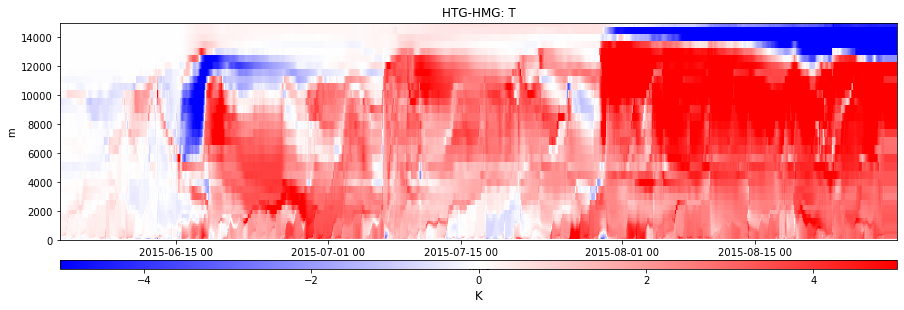

In [14]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_local.time, HTGcamDS_local.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_local.T.values - HMGcamDS_local.T.values)),
                               vmin=-5, vmax=5,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_local.T.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# axs.invert_yaxis()

axs.set_title('HTG-HMG: T', fontsize=12)
axs.set_ylabel('m')
axs.set_xlabel('Time')
axs.set_ylim([0,15000])




(0.0, 15000.0)

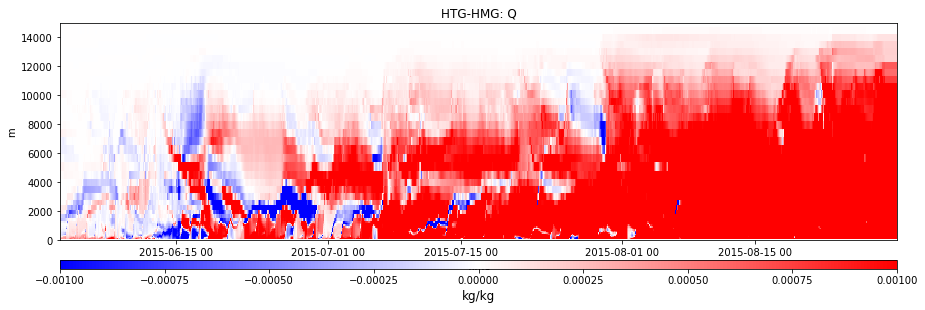

In [15]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_local.time, HTGcamDS_local.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_local.Q.values - HMGcamDS_local.Q.values)),
                               vmin=-0.001, vmax=0.001,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_local.Q.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# axs.invert_yaxis()

axs.set_title('HTG-HMG: Q', fontsize=12)
axs.set_ylabel('m')
axs.set_xlabel('Time')
axs.set_ylim([0,15000])





(3.0, 0.0)

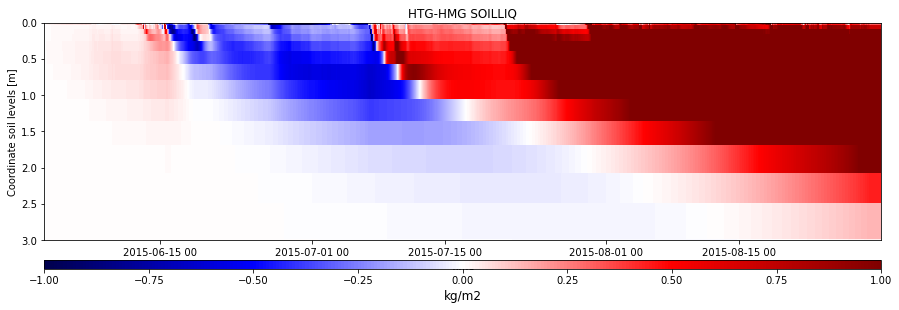

In [16]:
varPlot = 'SOILLIQ'
diffVar = HTGclmDS_all[varPlot].values[:,:,0] - HMGclmDS_all[varPlot].values[:,:,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGclmDS_all.time.values, HTGclmDS_all.levsoi.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-1,1.1,0.1),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGclmDS_all[varPlot].units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('Coordinate soil levels [m]')
axs.set_xlabel('Time')
axs.set_ylim([3,0])




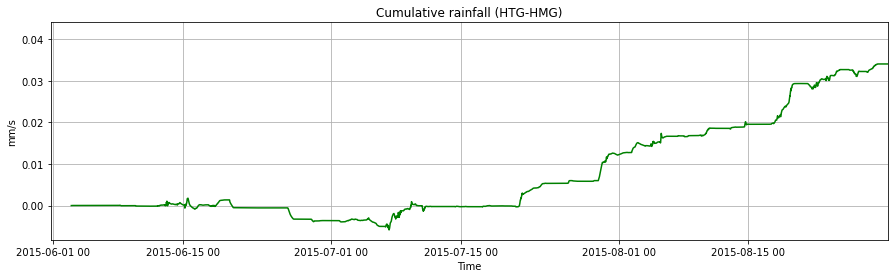

In [17]:
## CDF of rainfall over the summer 
fig,axs = plt.subplots(1,1, figsize=(15,4))

# axs.plot(HTGclmDS_all.time.values, HTGclmDS_all.RAIN.cumsum(dim='time'),'b-',label='HTG')
# axs.plot(HMGclmDS_all.time.values, HMGclmDS_all.RAIN.cumsum(dim='time'),'r-',label='HMG')

axs.plot(HTGclmDS_all.time.values, HTGclmDS_all.RAIN.cumsum(dim='time')-HMGclmDS_all.RAIN.cumsum(dim='time'),
         'g-',label='HTG-HMG')


startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])


 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    

axs.set_title('Cumulative rainfall (HTG-HMG)', fontsize=12)
axs.set_ylabel(HTGclmDS_all.RAIN.units)
axs.set_xlabel('Time')

axs.grid()



In [154]:
## Read in info on the actual forcing
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS_HTG = xr.open_dataset(nateForcingFileHTG, decode_times='True')

nateForcingFileHMG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateDS_HMG = xr.open_dataset(nateForcingFileHMG, decode_times='True')

## Convert forcing obs to local time
nateDS_local       = nateDS_HTG.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = nateDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
nateDS_local = nateDS_local.assign_coords({"time": localTimes})

# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([nateDS_local['time.year'].values,
                                                                nateDS_local['time.month'].values, 
                                                                nateDS_local['time.day'].values])
nateDS_local.coords['year_month_day'] = ('time', month_day_idx)

# Now sum over the day to get total amount of rainfall
nateDS_localDailySum  = nateDS_local.groupby('year_month_day').sum()
nateDS_localDailyMean = nateDS_local.groupby('year_month_day').mean()

In [178]:
np.where((nateDS_localDailyMean.year_month_day_level_0.values == np.asarray(iKeep_days)[iDay][0]) & 
         (nateDS_localDailyMean.year_month_day_level_1.values == np.asarray(iKeep_days)[iDay][1]) & 
         (nateDS_localDailyMean.year_month_day_level_2.values == np.asarray(iKeep_days)[iDay][2]))[0]

array([153])

In [190]:
set1 = set(HMGcamDS_local.year_month_day.values)
set2 = set(nateDS_local.year_month_day.values)

iKeep_days  = list(set1 & set2)
iKeep = []
for iDay in range(len(iKeep_days)):
    selDay = np.where((nateDS_localDailyMean.year_month_day_level_0.values == np.asarray(iKeep_days)[iDay][0]) & 
         (nateDS_localDailyMean.year_month_day_level_1.values == np.asarray(iKeep_days)[iDay][1]) & 
         (nateDS_localDailyMean.year_month_day_level_2.values == np.asarray(iKeep_days)[iDay][2]))[0]
    iKeep = np.append(iKeep, int(selDay))

# Keep just the days that are in the SCAM record 
nateDS_localDailyMean = nateDS_localDailyMean.isel(year_month_day=iKeep.astype('int'))


#### Mean diurnal cycles

In [19]:
# Get means a function of hour of day
hourlyMean_HMG         = HMGcamDS_local.groupby("time.hour").mean()
hourlyMean_HTG         = HTGcamDS_local.groupby("time.hour").mean()

hourlyMeanCLM_HMG      = HMGclmDS_local.groupby("time.hour").mean()
hourlyMeanCLM_HTG      = HTGclmDS_local.groupby("time.hour").mean()

hourlyMeanCLMpatch_HMG = HMGclmDS_patch_local.groupby("time.hour").mean()
hourlyMeanCLMpatch_HTG = HTGclmDS_patch_local.groupby("time.hour").mean()


In [20]:
## Test out getting standard deviation for each hour, not just mean too...
hourlyStd_HMG = HMGcamDS_local.groupby("time.hour").std(dim='time')
hourlyStd_HTG = HTGcamDS_local.groupby("time.hour").std(dim='time')

# Want to use standar *error*, which is the std divided by the sqrt of the number of samples
#   So first, let s get the number of samples per hour 
nTimes = np.full([24], np.nan)

for iHr in range(len(nTimes)): 
    nTimes[iHr] = len(np.where(HMGcamDS_local["time.hour"]==iHr)[0])

hourlyMean_HMG['SampleCount']         = (('hour'), nTimes)
hourlyMean_HTG['SampleCount']         = (('hour'), nTimes)
hourlyMeanCLM_HMG['SampleCount']      = (('hour'), nTimes)
hourlyMeanCLM_HTG['SampleCount']      = (('hour'), nTimes)
hourlyMeanCLMpatch_HMG['SampleCount'] = (('hour'), nTimes)
hourlyMeanCLMpatch_HTG['SampleCount'] = (('hour'), nTimes)


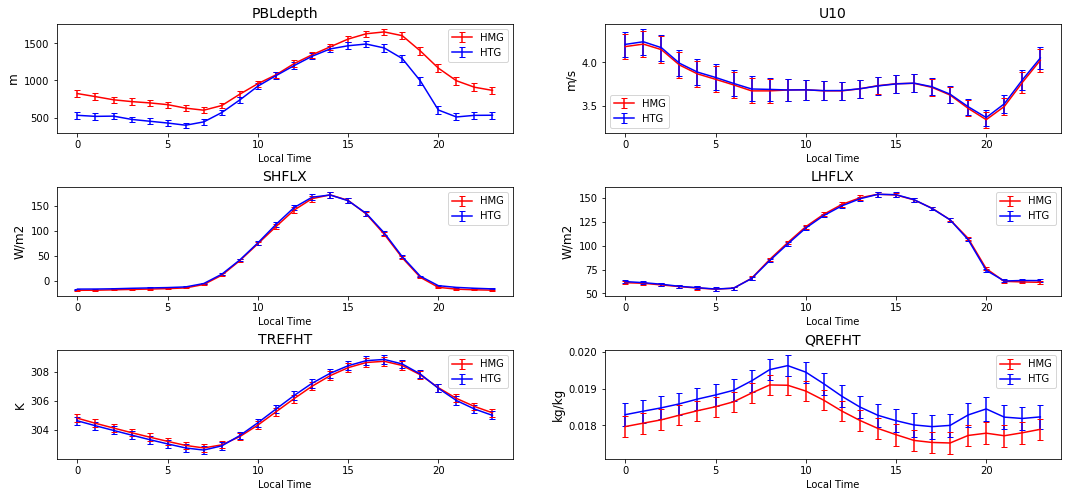

In [29]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
# ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                      fmt='r-',capsize=3,label='HMG')
    axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                      fmt='b-',capsize=3,label='HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS_local['T'].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS_local['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units, fontsize=12)
        

In [30]:
hourlyMean_HTG.lev.values

array([29406., 28295., 27133., 26003., 24864., 23762., 22690., 21736.,
       20921., 20317., 19898., 19478., 19056., 18633., 18208., 17783.,
       17326., 16843., 16389., 15959., 15522., 15079., 14628., 14171.,
       13706., 13235., 12755., 12269., 11781., 11294., 10796., 10292.,
        9777.,  9255.,  8723.,  8184.,  7634.,  7076.,  6508.,  5932.,
        5345.,  4750.,  4191.,  3663.,  3184.,  2746.,  2360.,  2019.,
        1731.,  1492.,  1307.,  1173.,  1046.,   924.,   808.,   697.,
         593.,   494.,   402.,   315.,   235.,   160.,    91.,    72.])

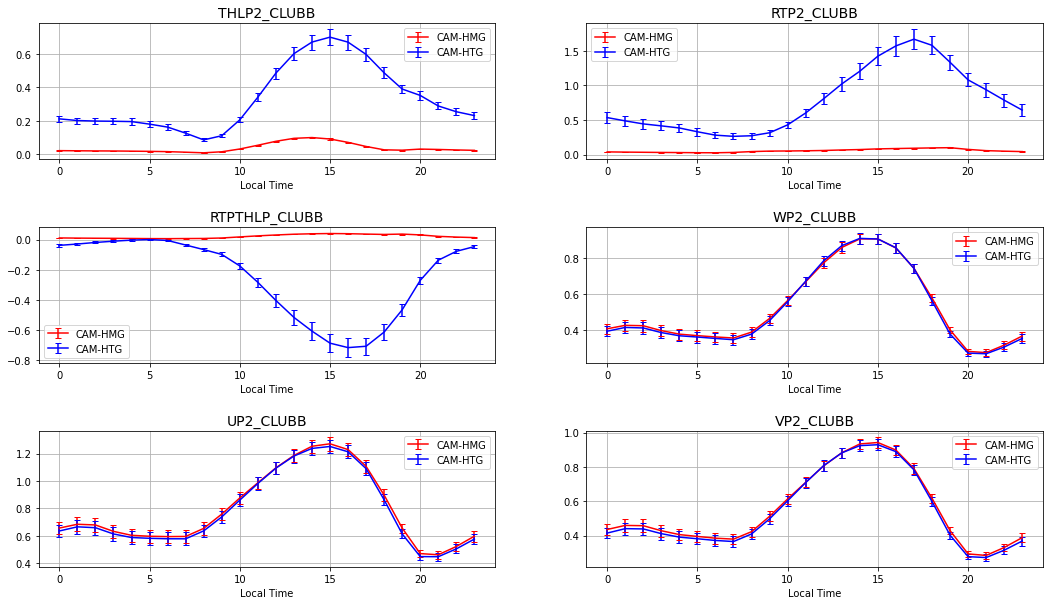

In [31]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
    
        

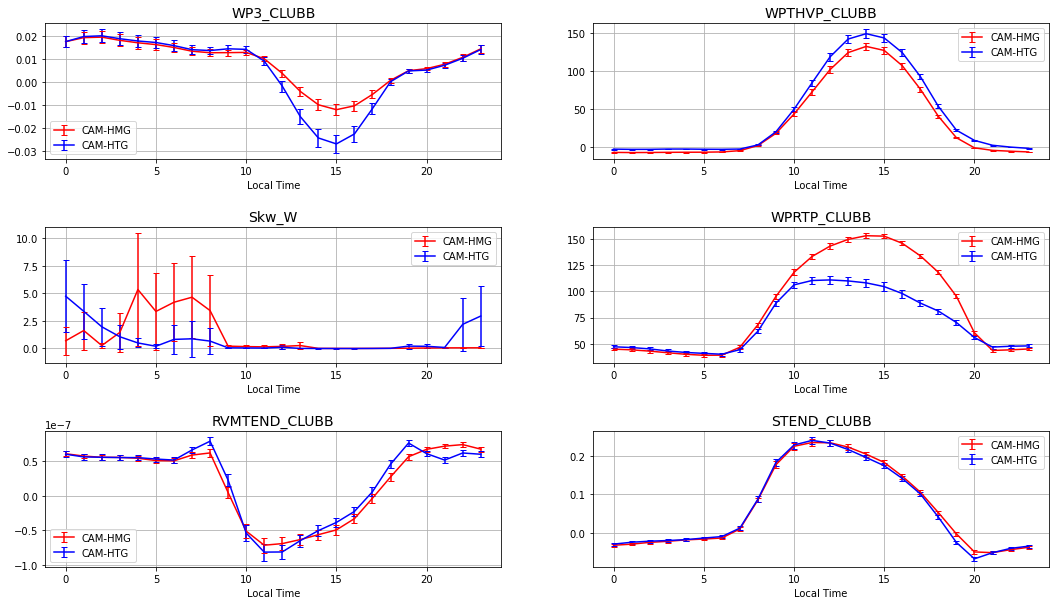

In [32]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','Skw_W','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
        
    elif ATM_varNames[iVar]=='Skw_W':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
        

**Would this all view better with actual profiles??** <br>
*Use DAILY MEANS*

In [21]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


In [259]:
# Add daily PRECT to clm means too
HMGclmDS_localDailyMean['PRECTdailySum'] = (('year_month_day'), np.squeeze(HMGcamDS_localDailySum['PRECT_mmPerDT'].values))
HTGclmDS_localDailyMean['PRECTdailySum'] = (('year_month_day'), np.squeeze(HTGcamDS_localDailySum['PRECT_mmPerDT'].values))

# # Add daily mean PBL depth too 
# HMGclmDS_localDailyMean['PBLdepth'] = (('year_month_day'), np.squeeze(HMGcamDS_localDailyMean['PBLdepth'].values))
# HTGclmDS_localDailyMean['PBLdepth'] = (('year_month_day'), np.squeeze(HTGcamDS_localDailyMean['PBLdepth'].values))

# Add daily PRECT to clm means too
HMGclmDS_localDailyMean['CLDTOT'] = (('year_month_day'), np.squeeze(HMGcamDS_localDailySum['CLDTOT'].values))
HTGclmDS_localDailyMean['CLDTOT'] = (('year_month_day'), np.squeeze(HTGcamDS_localDailySum['CLDTOT'].values))


                                            

In [213]:
# Select lowish-level for forcing (700 mb)
i700 = np.where(nateDS_localDailyMean.lev.values == 700.)[0]
nateDS_localDailyMean_700mb = nateDS_localDailyMean.isel(lev=i700)

# Add some forcing data
HMGclmDS_localDailyMean['q_adv_h'] = (('year_month_day'), np.squeeze(nateDS_localDailyMean_700mb['q_adv_h'].values))
HTGclmDS_localDailyMean['q_adv_h'] = (('year_month_day'), np.squeeze(nateDS_localDailyMean_700mb['q_adv_h'].values))
                                      
HMGclmDS_localDailyMean['T_adv_h'] = (('year_month_day'), np.squeeze(nateDS_localDailyMean_700mb['T_adv_h'].values))
HTGclmDS_localDailyMean['T_adv_h'] = (('year_month_day'), np.squeeze(nateDS_localDailyMean_700mb['T_adv_h'].values))

HMGclmDS_localDailyMean['q_adv_h_absVal'] = (('year_month_day'), np.abs(np.squeeze(nateDS_localDailyMean_700mb['q_adv_h'].values)))
HTGclmDS_localDailyMean['q_adv_h_absVal'] = (('year_month_day'), np.abs(np.squeeze(nateDS_localDailyMean_700mb['q_adv_h'].values)))
                                      
HMGclmDS_localDailyMean['T_adv_h_absVal'] = (('year_month_day'), np.abs(np.squeeze(nateDS_localDailyMean_700mb['T_adv_h'].values)))
HTGclmDS_localDailyMean['T_adv_h_absVal'] = (('year_month_day'), np.abs(np.squeeze(nateDS_localDailyMean_700mb['T_adv_h'].values)))


                                                                            

In [109]:
HTGclmDS_localDailyMean

<xarray.Dataset>
Dimensions:                        (cft: 2, glc_nec: 10, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, ltype: 9, natpft: 15, nvegwcs: 4, year_month_day: 352)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                         (levsoi) float32 0.01 0.04 0.09 ... 6.94 8.03
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 1.0
  * year_month_day                 (year_month_day) MultiIndex
  - year_month_day_level_0         (year_month_day) int64 2015 2015 ... 2018
  - year_month_day_level_1         (year_month_day) int64 6 6 6 6 6 ... 8 8 8 8
  - year_month_day_level_2         (year_month_day) int64 2 3 4 5 ... 26 27 28
Dimensions without coordinates: cft, glc_nec, lndgrid, ltype, natpft, nvegwcs
Data variables:
    mcdate                         (year_month_day) float64 2.015e+07 ... 2.0...
    mcsec                          (year_month_day) float64 1.407e+04 ... 5.2...
    mdcur                          (year_month_day) float64 2.0 2.25 ... 88.02
    mscur                          (year_month_day) float64 1.08e+04 ... 5.24...
    nstep                          (year_month_day) float64 153.0 ... 6.381e+03
    lon                            (year_month_day, lndgrid) float32 261.6 .....
    lat                            (year_month_day, lndgrid) float32 37.67 .....
    area                           (year_month_day, lndgrid) float32 7.68e+04...
    landfrac                       (year_month_day, lndgrid) float32 1.0 ... 1.0
    landmask                       (year_month_day, lndgrid) float64 1.0 ... 1.0
    pftmask                        (year_month_day, lndgrid) float64 1.0 ... 1.0
    nbedrock                       (year_month_day, lndgrid) float64 20.0 ......
    ZSOI                           (year_month_day, levgrnd, lndgrid) float32 ...
    DZSOI                          (year_month_day, levgrnd, lndgrid) float32 ...
    WATSAT                         (year_month_day, levgrnd, lndgrid) float32 ...
    SUCSAT                         (year_month_day, levgrnd, lndgrid) float32 ...
    BSW                            (year_month_day, levgrnd, lndgrid) float32 ...
    HKSAT                          (year_month_day, levgrnd, lndgrid) float32 ...
    ZLAKE                          (year_month_day, levlak, lndgrid) float32 ...
    DZLAKE                         (year_month_day, levlak, lndgrid) float32 ...
    ATM_TOPO                       (year_month_day, lndgrid) float32 0.0 ... 0.0
    BCDEP                          (year_month_day, lndgrid) float32 6.902e-1...
    BTRANMN                        (year_month_day, lndgrid) float32 nan ... nan
    DSL                            (year_month_day, lndgrid) float32 10.43 .....
    DSTDEP                         (year_month_day, lndgrid) float32 1.963e-1...
    DSTFLXT                        (year_month_day, lndgrid) float32 0.0 ... 0.0
    EFLXBUILD                      (year_month_day, lndgrid) float32 0.0 ... 0.0
    EFLX_DYNBAL                    (year_month_day, lndgrid) float32 0.0 ... 0.0
    EFLX_GRND_LAKE                 (year_month_day, lndgrid) float32 -54.2 .....
    EFLX_LH_TOT                    (year_month_day, lndgrid) float32 60.32 .....
    EFLX_LH_TOT_R                  (year_month_day, lndgrid) float32 67.89 .....
    ELAI                           (year_month_day, lndgrid) float32 0.5771 ....
    ERRH2O                         (year_month_day, lndgrid) float32 1.144e-1...
    ERRH2OSNO                      (year_month_day, lndgrid) float32 0.0 ... 0.0
    ERRSEB                         (year_month_day, lndgrid) float32 -6.243e-...
    ERRSOI                         (year_month_day, lndgrid) float32 -2.191e-...
    ERRSOL                         (year_month_day, lndgrid) float32 -2.786e-...
    ESAI                           (year_month_day, lndgrid) float32 0.1424 ....
    FCEV                  

In [260]:
# So what if we take, say, percentiles of a controlVar 
# controlVar = 'SOILWATER_10CM'
# controlVar = 'stdET'
# controlVar = 'FSH_TO_COUPLER'
# controlVar = 'PRECTdailySum'
# controlVar = 'U10'
# controlVar = 'TSA'
# controlVar = 'T_adv_h'
controlVar = 'CLDTOT'
pctSel     = np.arange(10,100,10) 

HTG_pctCtrlValues = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSel)
HMG_pctCtrlValues = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSel)

# pctSelThirds     = np.asarray([33.33, 66.66])
pctSelThirds     = np.asarray([25.0, 75.0])
HTG_pctCtrlValuesThirds = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSelThirds)
HMG_pctCtrlValuesThirds = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSelThirds)

#print('Control variable selected: ', HTGclmDS_local[controlVar].long_name)

In [261]:
## Maybe we do want consistent bin definitions, at least? 
binSelSame = np.full([len(pctSel)], np.nan)
for iBin in range(len(pctSel)):
    binSelSame[iBin] = np.nanmean([HTG_pctCtrlValues[iBin], HMG_pctCtrlValues[iBin]])
    
## Maybe we do want consistent bin definitions, at least? 
# for Thirds...
binSelSameThirds = np.full([len(pctSelThirds)], np.nan)
for iBin in range(len(pctSelThirds)):
    binSelSameThirds[iBin] = np.nanmean([HTG_pctCtrlValuesThirds[iBin], HMG_pctCtrlValuesThirds[iBin]])

print('Bottom third cutoff: %.2f' % (binSelSameThirds[0]))
print('Top third cutoff: %.2f' % (binSelSameThirds[1]))  

Bottom third cutoff: 38.25
Top third cutoff: 71.94


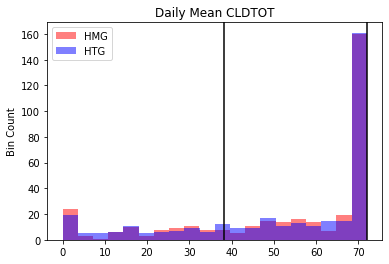

In [262]:
plt.hist((HMGclmDS_localDailyMean[controlVar].values).reshape([len(HMGclmDS_localDailyMean.year_month_day.values)]), 
         bins=20, facecolor='r',alpha=0.5)
plt.hist((HTGclmDS_localDailyMean[controlVar].values).reshape([len(HTGclmDS_localDailyMean.year_month_day.values)]), 
         bins=20, facecolor='b',alpha=0.5)
plt.legend(['HMG','HTG'])
plt.title('Daily Mean '+controlVar)
plt.ylabel('Bin Count')
# plt.xlabel(HMGclmDS_all[controlVar].units)

plt.axvline(binSelSameThirds[0], color='k')
plt.axvline(binSelSameThirds[1], color='k')

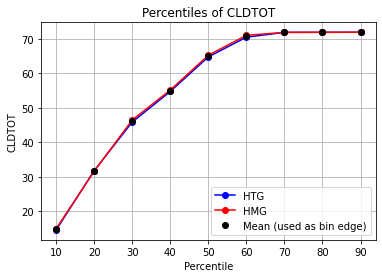

In [263]:
plt.plot(pctSel, HTG_pctCtrlValues, 'b-o', label='HTG')
plt.plot(pctSel, HMG_pctCtrlValues, 'r-o', label='HMG')
plt.plot(pctSel, binSelSame, 'ko', label='Mean (used as bin edge)')
plt.xlabel('Percentile')
plt.ylabel(controlVar)
plt.title('Percentiles of '+controlVar)
plt.legend()
plt.grid()


Now isolate arrays that correspond to those percentiles...

In [264]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnPercentile(fullDS, pctDS):
    iTimes = []
    
    for iTime in range(len(pctDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==pctDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==pctDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==pctDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayPct = fullDS.isel(time=iTimes)
    
    return(DS_dayPct)


In [265]:
# Now get all the times where daily mean controlVar falls into each bin
binSel = binSelSameThirds
HMGbin_bot30 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HMGbin_top30 = np.where((HMGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]

HTGbin_bot30 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin_top30 = np.where((HTGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]



In [266]:
## Want to use the same days in HMG and HTG bins (at least for wet/dry singular bins)

setHTG_bot30 = set(HTGbin_bot30)
setHMG_bot30 = set(HMGbin_bot30)
iKeep_bot30  = list(setHTG_bot30 & setHMG_bot30)

setHTG_top30 = set(HTGbin_top30)
setHMG_top30 = set(HMGbin_top30)
iKeep_top30  = list(setHTG_top30 & setHMG_top30)

print('Number of days with low '+controlVar+': ', len(iKeep_bot30))
print('Number of days with high '+controlVar+': ', len(iKeep_top30))


Number of days with low CLDTOT:  74
Number of days with high CLDTOT:  71


In [267]:
HMGcam_bot30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iKeep_bot30))
HMGclm_bot30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iKeep_bot30))

HTGcam_bot30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iKeep_bot30))
HTGclm_bot30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iKeep_bot30))


HMGcam_top30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iKeep_top30))
HMGclm_top30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iKeep_top30))

HTGcam_top30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iKeep_top30))
HTGclm_top30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iKeep_top30))



Text(0.5, 1.0, 'Lowest CLDTOT days by month')

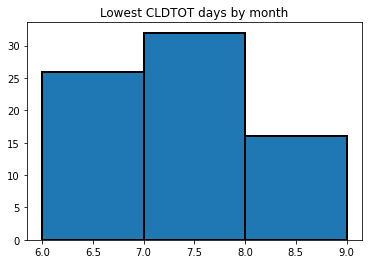

In [268]:
plt.hist(HMGcamDS_localDailyMean.isel(year_month_day=iKeep_bot30).year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('Lowest '+controlVar+' days by month')


Text(0.5, 1.0, 'Highest CLDTOT days by month')

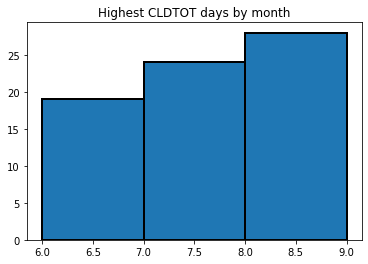

In [269]:
plt.hist(HMGcamDS_localDailyMean.isel(year_month_day=iKeep_top30).year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('Highest '+controlVar+' days by month')


**What if we look at a few bins for their average daily response**

In [270]:
hourlyMeanBot30_HTG = HTGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HTG = HTGcam_top30.groupby("time.hour").mean()

hourlyMeanBot30_HMG = HMGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HMG = HMGcam_top30.groupby("time.hour").mean()

## Also be able to get std error 
hourlyStdBot30_HTG = HTGcam_bot30.groupby("time.hour").std(dim='time')
hourlyStdTop30_HTG = HTGcam_top30.groupby("time.hour").std(dim='time')

hourlyStdBot30_HMG = HMGcam_bot30.groupby("time.hour").std(dim='time')
hourlyStdTop30_HMG = HMGcam_top30.groupby("time.hour").std(dim='time')

nSampleHrs_bot30 = np.full([24], np.nan)
nSampleHrs_top30 = np.full([24], np.nan)
for iHr in range(24):
    iSelHour_bot30 = np.where(HTGcam_bot30['time.hour'].values==iHr)[0]
    iSelHour_top30 = np.where(HTGcam_top30['time.hour'].values==iHr)[0]

    nSampleHrs_bot30[iHr] = len(iSelHour_bot30)
    nSampleHrs_top30[iHr] = len(iSelHour_top30)
    

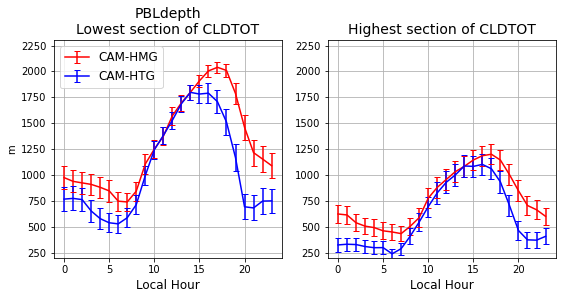

In [271]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
ATM_varNames = np.asarray(['PBLdepth'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 200])

iPlot=0
for iVar in range(len(varSel)):
    ## Plot lowest percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG')     
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
        
    axs[iPlot+0].set_title(varSel[iVar]+'\nLowest section of '+controlVar, fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    ## Plot top percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 
    
    axs[iPlot+1].set_title('\nHighest section of '+controlVar, fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2

    

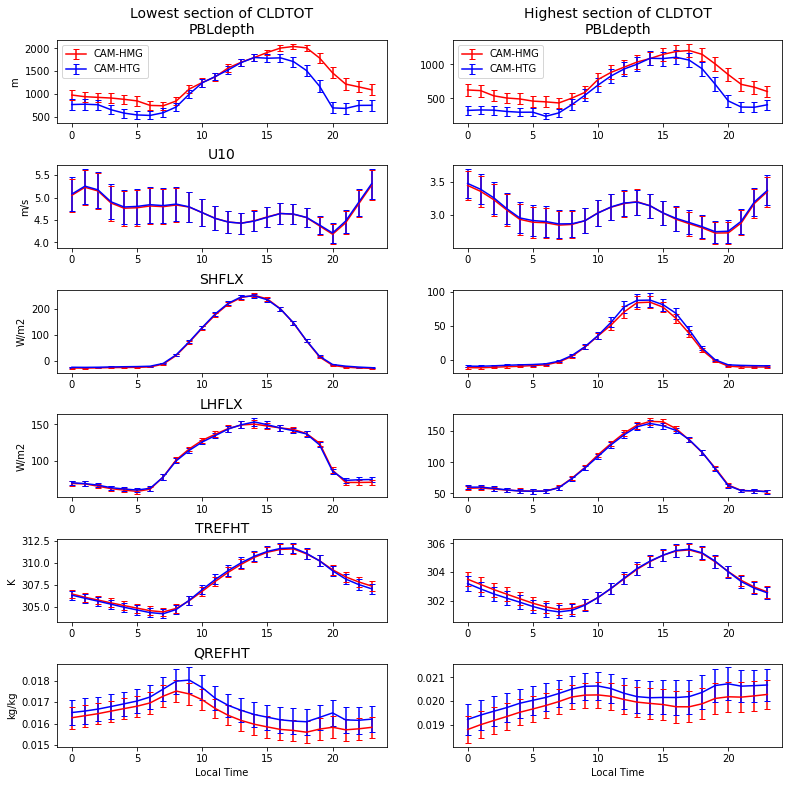

In [272]:
fig,axs = plt.subplots(6,2, figsize=(13,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

yMax = np.asarray([2400, 5.5, 250, 200, 310, 0.026])
yMin = np.asarray([ 100, 3,   -40, -5,  300, 0.013])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('Lowest section of '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('Highest section of '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

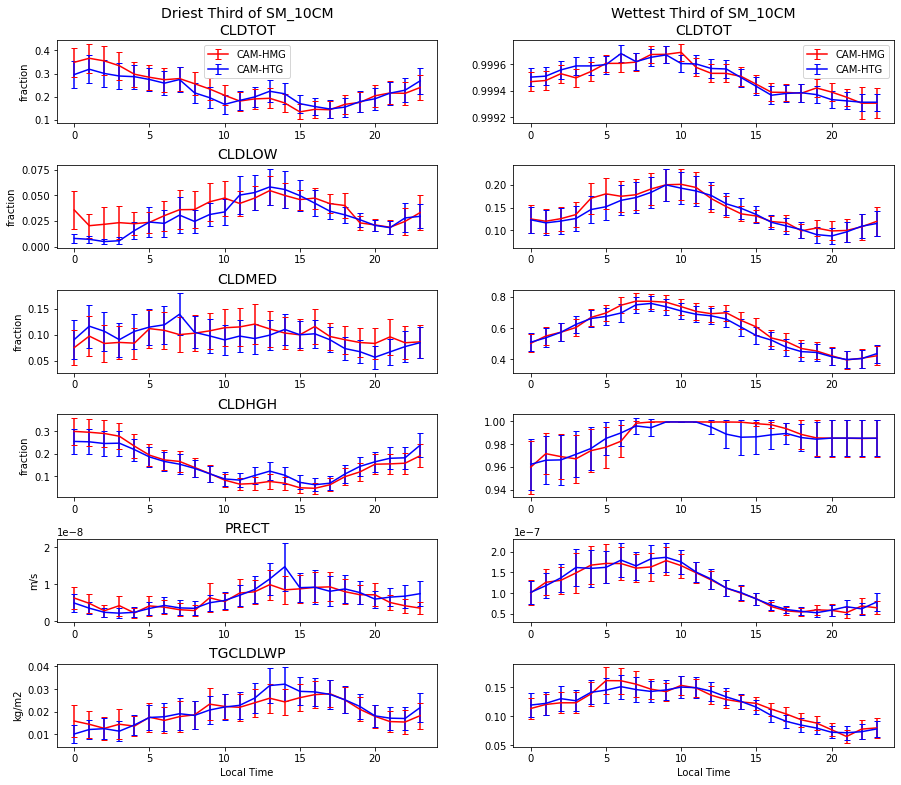

In [273]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['CLDTOT','CLDLOW','CLDMED','CLDHGH','PRECT','TGCLDLWP'])

yMax = np.asarray([2300, 7, 300, 300, 315, 0.025])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.001])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 

#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('Driest Third of SM_10CM\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('Wettest Third of SM_10CM\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

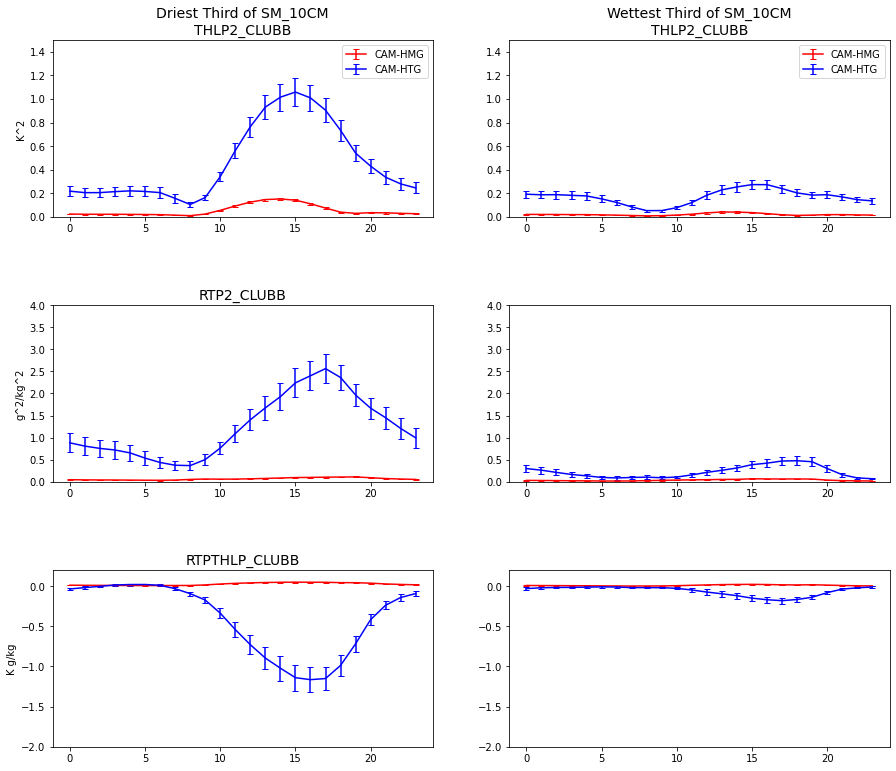

In [274]:
fig,axs = plt.subplots(3,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

#ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

# Define limits on y-axis by variable
# ylimMax = np.asarray([2.0, 4.75, 0.1, 1.2,  0.02, 250])
# ylimMin = np.asarray([0.0, 0.0, -2.25, 0.0, -0.06, -25])
yMax = np.asarray([1.5, 4.0,  0.2])
yMin = np.asarray([0.0, 0.0, -2.0])

iPlot = 0
for iVar in range(len(ATM_varNames)): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
     ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('Driest Third of SM_10CM\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('Wettest Third of SM_10CM\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
    if iVar==6:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])

    
    iPlot = iPlot+2
    

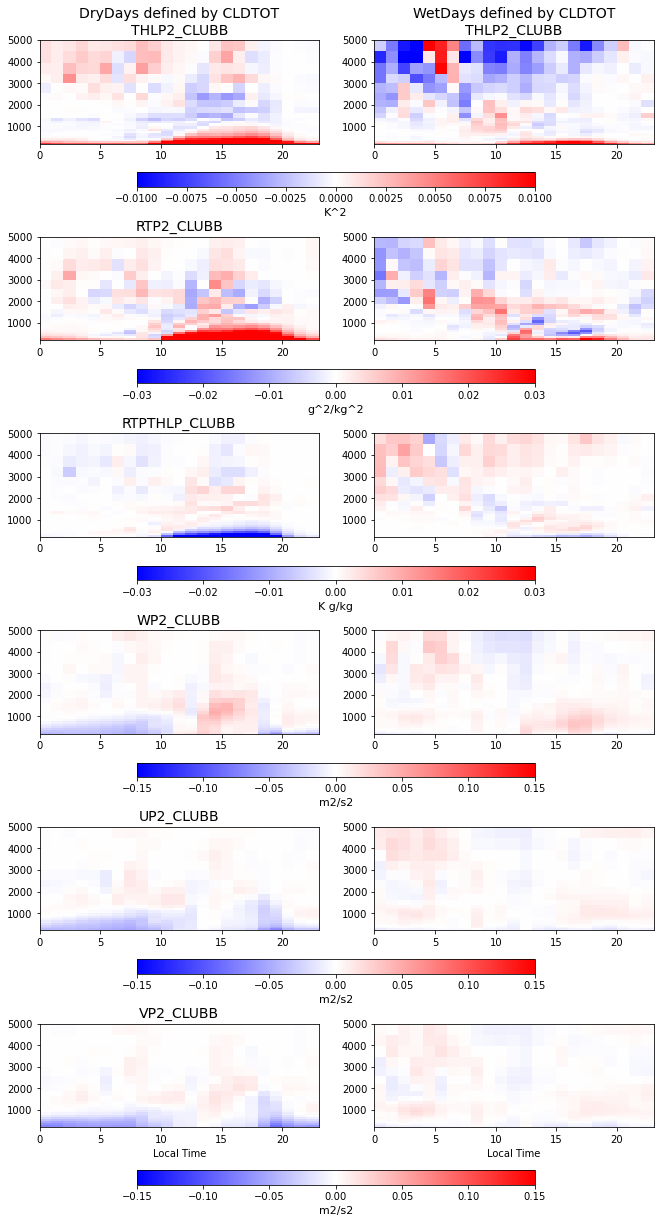

In [275]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.15, 0.15, 0.15])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].set_ylim([200,5000])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].set_ylim([200,5000])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

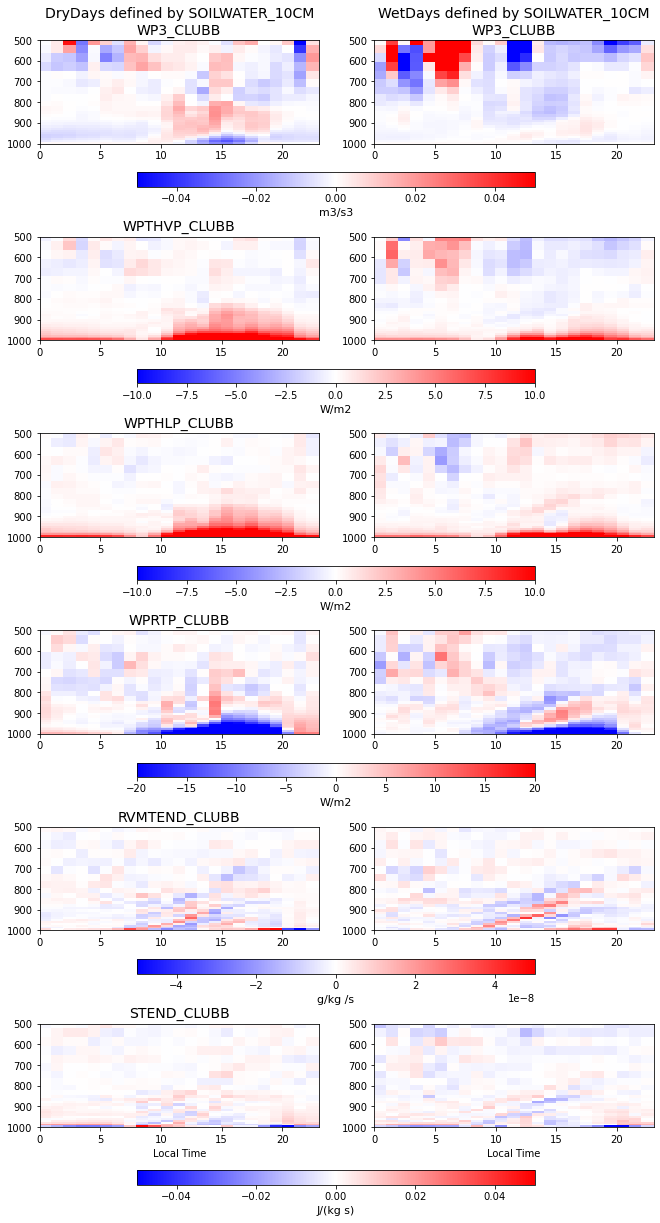

In [67]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

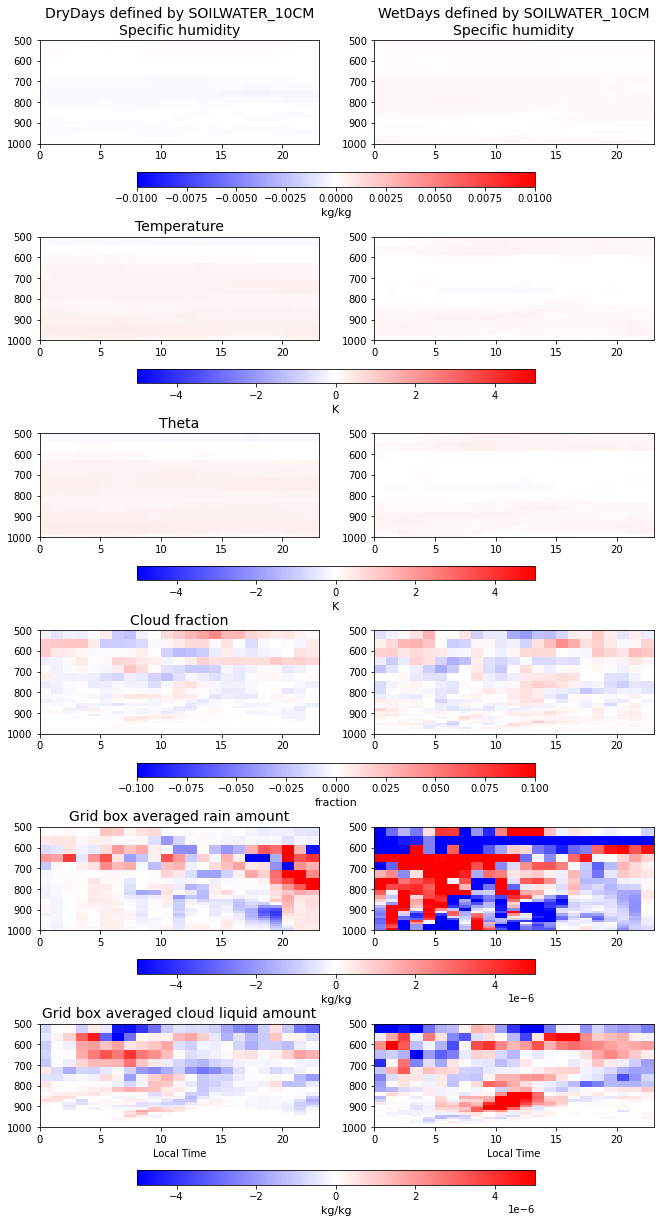

In [68]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['Q','T','theta','CLOUD','RAINQM','CLDLIQ'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 5, 5, 0.1, 0.000005, 0.000005])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    if ATM_varNames[iVar]=='theta':
        axs[iPlot].set_title('Theta',fontsize=14)
    else: 
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

**Now look at the percentiles' mean profiles averaged over a certain time of day**

In [65]:
# def getMeanOverHours(DS, startHr, endHr):
#     hourlyMean = DS.groupby("time.hour").mean()
    
#     # Get mean over some hours 
#     iHours    = np.where((hourlyMean
#                           .hour>=startHr) & (hourlyMean.hour<=endHr))[0]
#     DShrSel   = hourlyMean.isel(hour=iHours)
    
#     return(DShrSel.mean(dim='hour'))

In [276]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- Dry days (defined by bot30) ----------
    iTimeSel_bot30HMG = np.where((HMGcam_bot30["time.hour"].values>=startHr) & 
                                 (HMGcam_bot30["time.hour"].values<=endHr))[0]
    iTimeSel_bot30HTG = np.where((HTGcam_bot30["time.hour"].values>=startHr) & 
                                 (HTGcam_bot30["time.hour"].values<=endHr))[0]
    

    hourlyMean_botTimeSel_HMG = HMGcam_bot30.isel(time=iTimeSel_bot30HMG).mean(dim='time')
    hourlyMean_botTimeSel_HTG = HTGcam_bot30.isel(time=iTimeSel_bot30HTG).mean(dim='time')
    
    hourlyStd_botTimeSel_HMG = HMGcam_bot30.isel(time=iTimeSel_bot30HMG).std(dim='time')
    hourlyStd_botTimeSel_HTG = HTGcam_bot30.isel(time=iTimeSel_bot30HTG).std(dim='time')
    
    stdErr_bot_HMG = np.squeeze(hourlyStd_botTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_bot30HMG))
    stdErr_bot_HTG = np.squeeze(hourlyStd_botTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_bot30HTG))
    


    # ------- Wet days (defined by top30) ----------
    iTimeSel_top30HMG = np.where((HMGcam_top30["time.hour"].values>=startHr) & 
                                 (HMGcam_top30["time.hour"].values<=endHr))[0]
    iTimeSel_top30HTG = np.where((HTGcam_top30["time.hour"].values>=startHr) & 
                                 (HTGcam_top30["time.hour"].values<=endHr))[0]
    
    hourlyMean_topTimeSel_HMG = HMGcam_top30.isel(time=iTimeSel_top30HMG).mean(dim='time')
    hourlyMean_topTimeSel_HTG = HTGcam_top30.isel(time=iTimeSel_top30HTG).mean(dim='time')
    
    hourlyStd_topTimeSel_HMG = HMGcam_top30.isel(time=iTimeSel_top30HMG).std(dim='time')
    hourlyStd_topTimeSel_HTG = HTGcam_top30.isel(time=iTimeSel_top30HTG).std(dim='time')
    
    stdErr_top_HMG = np.squeeze(hourlyStd_topTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_top30HMG))
    stdErr_top_HTG = np.squeeze(hourlyStd_topTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_top30HTG))


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(9,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_topTimeSel_HMG[varSel].values)[0]==len(hourlyMean_topTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_topTimeSel_HMG[varSel].values)[0]==len(hourlyMean_topTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
    
    # Plot dry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values), 
                    hourlyMean_botTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values), 
                    hourlyMean_botTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\nLowest percentile days defined by '+controlVar+'\n(Hours '+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values) + (2*stdErr_bot_HMG)
    xmin1 = np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values) - (2*stdErr_bot_HMG)
    xmax2 = np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values) + (2*stdErr_bot_HTG)
    xmin2 = np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values) - (2*stdErr_bot_HTG)

    levSig = np.ones([len(hourlyMean_botTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_botTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_botTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_botTimeSel_HTG[varSel].values[iLev]):
                axs[0].plot(hourlyMean_botTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_botTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[0].plot(hourlyMean_botTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_botTimeSel_HTG[levSel].values[iLev], 
                        'bo')
    
    
    
    

    # Plot Wet days 
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wDry_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values), 
                    hourlyMean_topTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values), 
                    hourlyMean_topTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[1].set_title('\nTop Percentile days')
    axs[1].set_xlabel(unitLabel)
        # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values) + (2*stdErr_top_HMG)
    xmin1 = np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values) - (2*stdErr_top_HMG)
    xmax2 = np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values) + (2*stdErr_top_HTG)
    xmin2 = np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values) - (2*stdErr_top_HTG)

    levSig = np.ones([len(hourlyMean_topTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_topTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_topTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_topTimeSel_HTG[varSel].values[iLev]):
                axs[1].plot(hourlyMean_topTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_topTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[1].plot(hourlyMean_topTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_topTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            
            
    # Consistent settings across subplots 
    axs[0].set_ylim([50,maxLev])
    axs[1].set_ylim([50,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    return

In [277]:
## Add wind speed to underlying DS

windSpeed_botDays_HMG = np.sqrt((HMGcam_bot30.U.values**2.0) + (HMGcam_bot30.V.values**2.0))
windSpeed_botDays_HTG = np.sqrt((HTGcam_bot30.U.values**2.0) + (HTGcam_bot30.V.values**2.0))

windSpeed_topDays_HMG = np.sqrt((HMGcam_top30.U.values**2.0) + (HMGcam_top30.V.values**2.0))
windSpeed_topDays_HTG = np.sqrt((HTGcam_top30.U.values**2.0) + (HTGcam_top30.V.values**2.0))


HMGcam_bot30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_botDays_HMG))
HTGcam_bot30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_botDays_HTG))

HMGcam_top30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_topDays_HMG))
HTGcam_top30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_topDays_HTG))


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


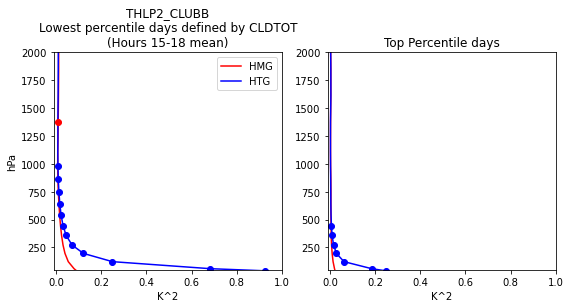

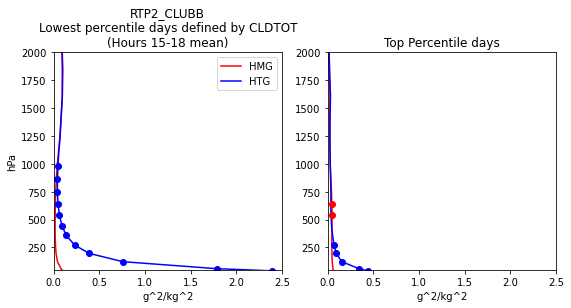

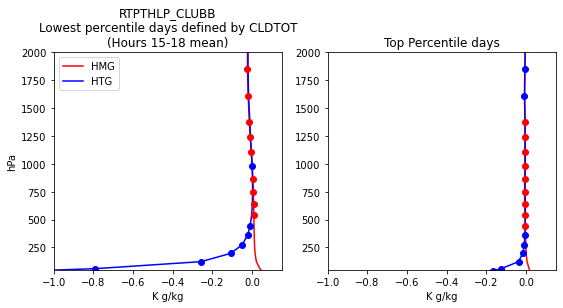

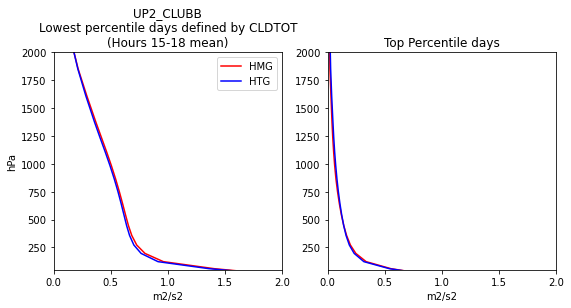

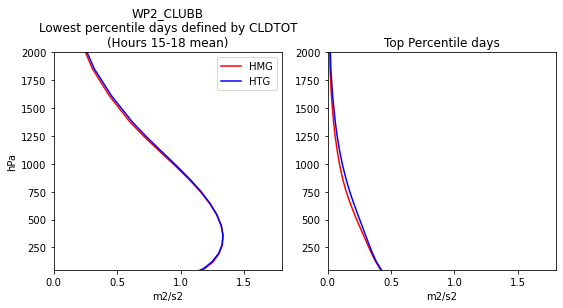

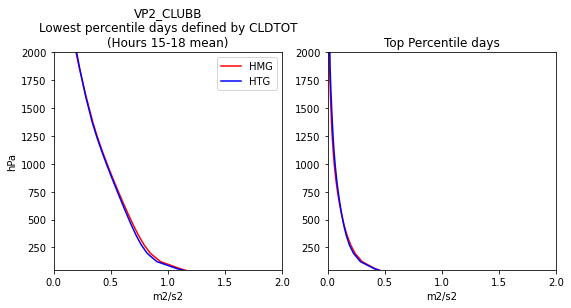

In [278]:
startHr = 15
endHr   = 18
maxLev  = 2000

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'THLP2_CLUBB', maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 1.0)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTP2_CLUBB', maxLev,
#                            0.0, 1.75)
                             0.0, 2.5)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTPTHLP_CLUBB', maxLev,
#                            -0.75, 0.15)
                             -1.00, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UP2_CLUBB', maxLev,
#                            0.0, 2.0)
                             0.0, 2.0)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP2_CLUBB', maxLev,
#                            0.0, 0.8)
                             0.0, 1.8)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'VP2_CLUBB', maxLev,
#                            0.0, 2.0)
                             0.0, 2.0)


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


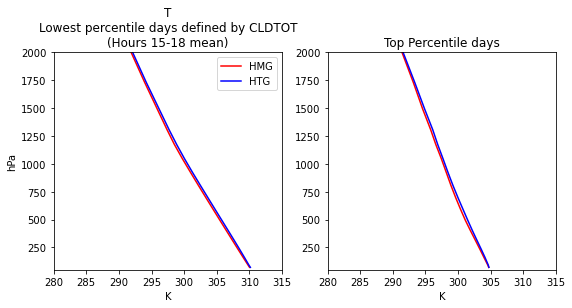

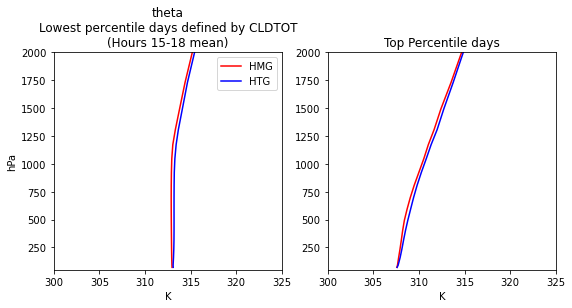

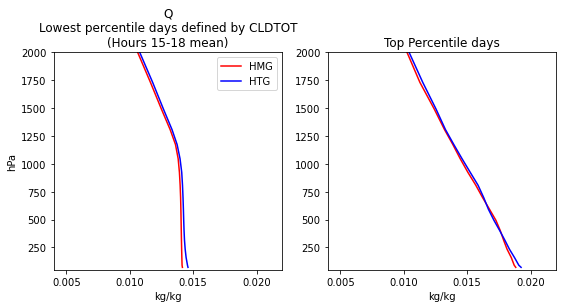

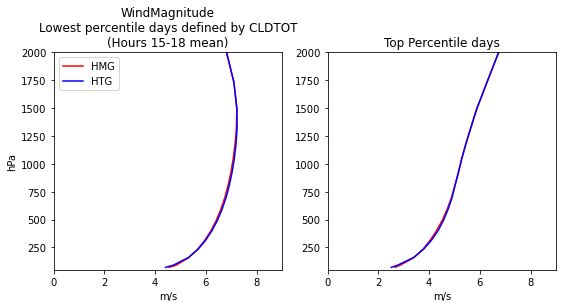

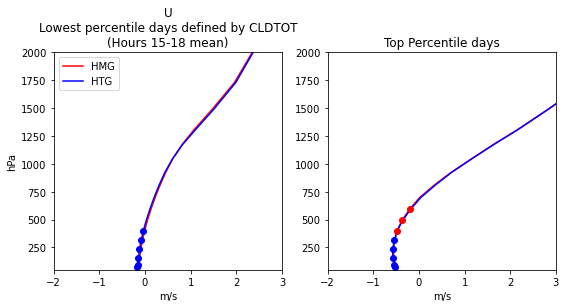

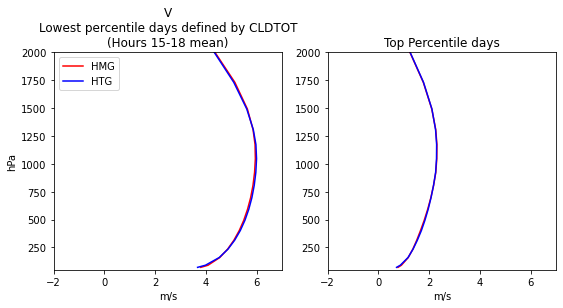

In [279]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'T', maxLev,
#                            280, 310)
                           280, 315)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'theta', maxLev,
#                            280, 310)
                           300, 325)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'Q', maxLev,
#                            0.006, 0.022)
                           0.004, 0.022)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WindMagnitude', maxLev,
#                            0.006, 0.022)
                           0, 9)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'U', maxLev,
                           -2, 3)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'V', maxLev,
                           -2, 7)


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


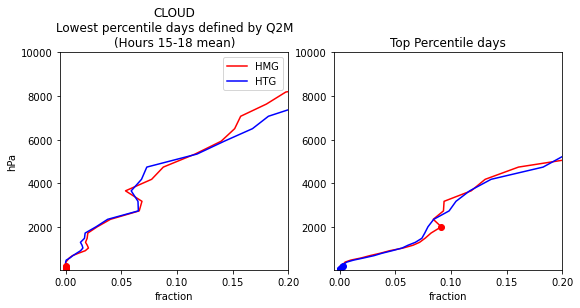

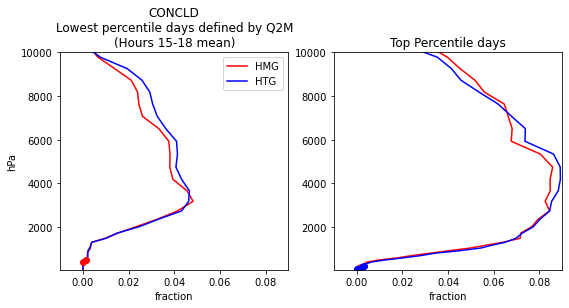

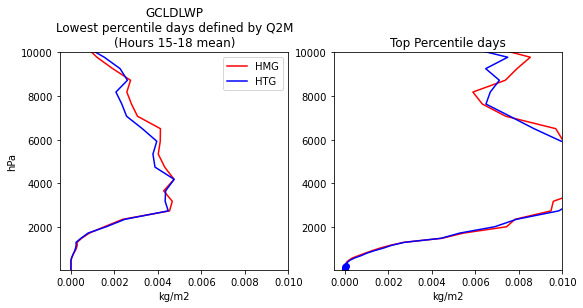

In [152]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CLOUD', 10000,
#                            -0.01, 0.3)
                           -0.005, 0.2)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CONCLD', 10000,
                           -0.01, 0.09)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'GCLDLWP', 10000,
                           -0.0005, 0.01)


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


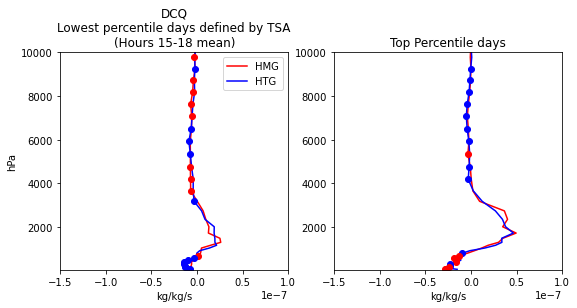

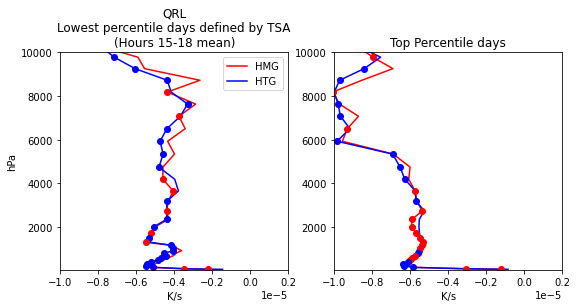

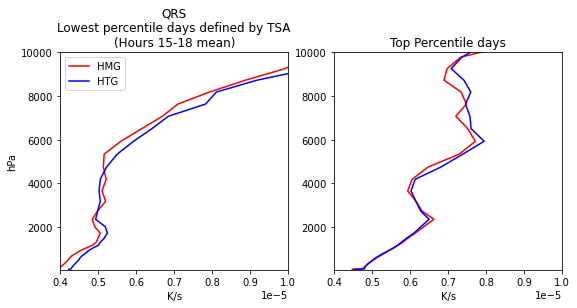

In [133]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'DCQ', 10000,
                           -0.15e-6, 0.1e-6) 

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr,'QRL', 10000,
                           -1e-5, 0.2e-5) 

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'QRS',10000,
                           0.4e-5, 1e-5) 



Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


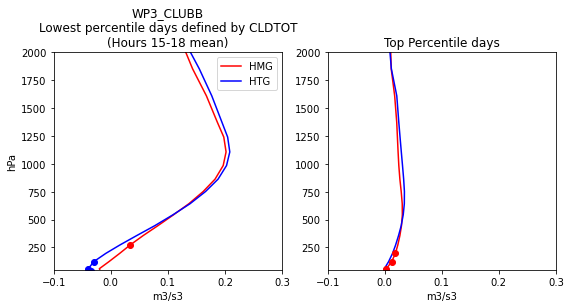

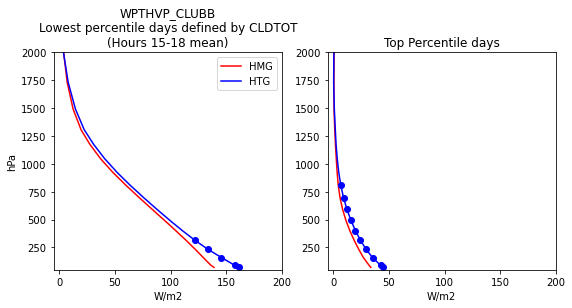

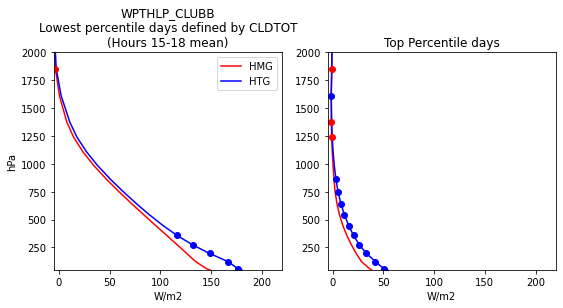

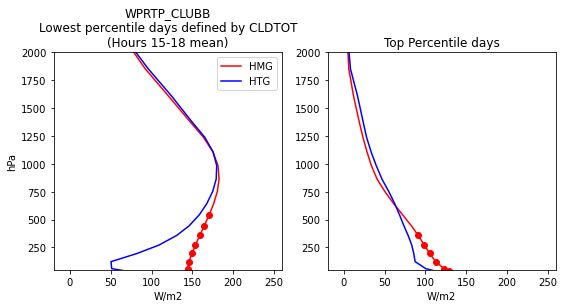

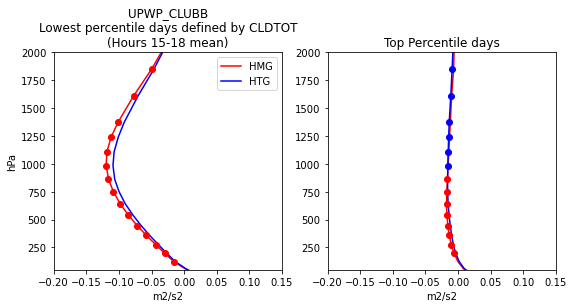

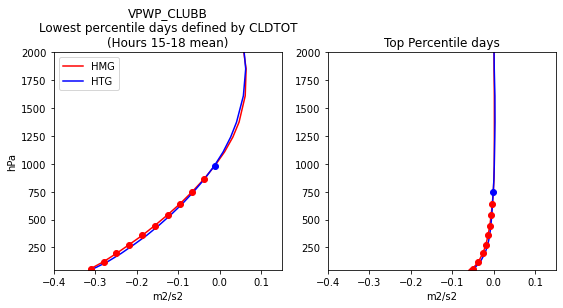

In [280]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP3_CLUBB', maxLev,
#                            -0.02, 0.1)
                           -0.1, 0.3)

# plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'Skw_W', maxLev,
# #                            -0.02, 0.1)
#                            -0.1, 1.8)


plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHVP_CLUBB', maxLev,
#                            -5, 60)
                           -5, 200)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHLP_CLUBB', maxLev,
#                            -5, 80)
                           -5, 220)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPRTP_CLUBB', maxLev,
#                            -10, 120)
                            -20, 260)                                      

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UPWP_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.2, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'VPWP_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.4, 0.15)


#### What about wD/wW/dD/dW day classifications? 

In [187]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)


In [188]:
## First, need to get daily rain amounts 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()



In [189]:
timeArr = []
for iT in range(len(HMGcamDS_localDailySum.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(HMGcamDS_localDailySum.year_month_day.values[iT][0],
                                               HMGcamDS_localDailySum.year_month_day.values[iT][1],
                                               HMGcamDS_localDailySum.year_month_day.values[iT][2]))
    

(0.0, 30.0)

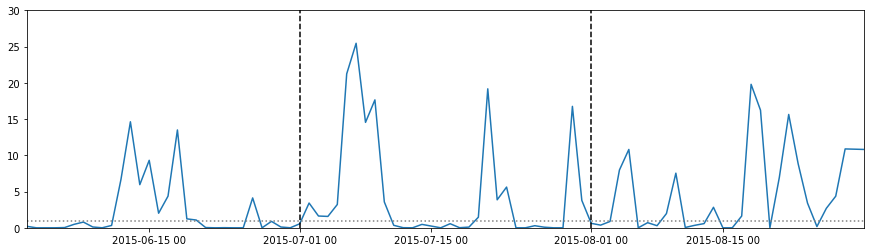

In [64]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')
axs.set_ylim([0,30])

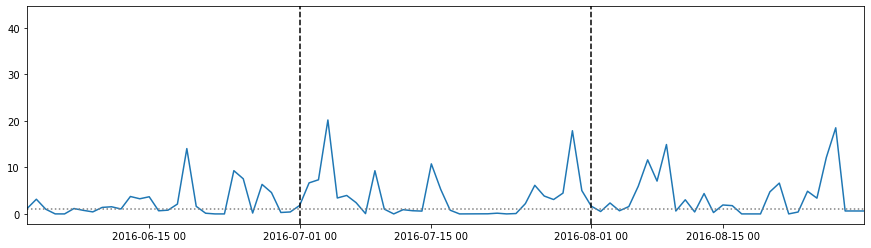

In [65]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

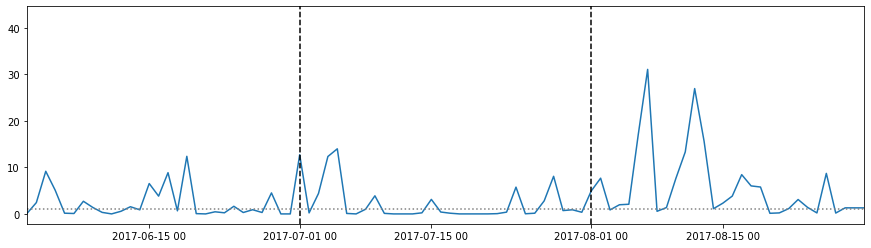

In [64]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2017
endYear    = 2017

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

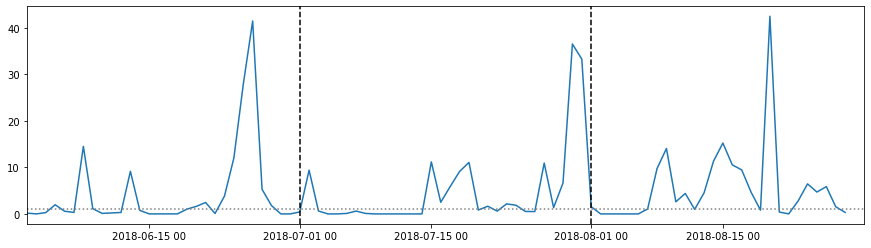

In [63]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

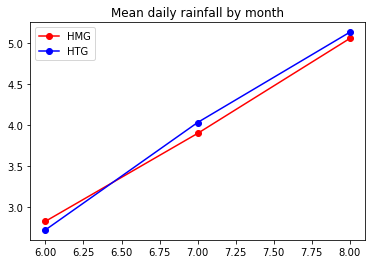

In [71]:
# June mean rain: 
iJune = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==6)[0]
iJuly = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==7)[0]
iAug  = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==8)[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.legend(['HMG','HTG'])


(1.0, 6.0)

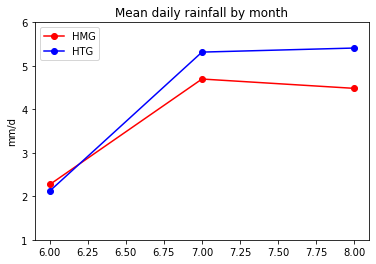

In [77]:
# June mean rain: 
iJune = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==6))[0]
iJuly = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==7))[0]
iAug  = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) & 
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==8))[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.ylabel('mm/d')
plt.legend(['HMG','HTG'])

plt.ylim([1, 6])

Number of total days in record:   352
Number of dry days (< 1.000):     172
Number of wet days (>= 1.000):    180


Text(0.5, 1.0, 'Wet days by month')

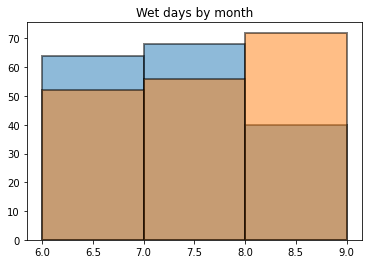

In [230]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))


iSelDryDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0]
dryDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelDryDays)
plt.hist(dryDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Dry days by month')

iSelWetDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0]
wetDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelWetDays)
plt.hist(wetDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Wet days by month')



In [190]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1


classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
# HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
# HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
# HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
# HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
# HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
# HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)

## Keep only days that agree on classification between HMG and HTG
setHMG_dDry = set(idDry_HMG)
setHTG_dDry = set(idDry_HTG)
iKeep_dDry  = list(setHMG_dDry & setHTG_dDry)
HMG_dDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)
HTG_dDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)


setHMG_dWet = set(idWet_HMG)
setHTG_dWet = set(idWet_HTG)
iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
HMG_dWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)
HTG_dWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)


setHMG_wDry = set(iwDry_HMG)
setHTG_wDry = set(iwDry_HTG)
iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
HMG_wDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)
HTG_wDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)


setHMG_wWet = set(iwWet_HMG)
setHTG_wWet = set(iwWet_HTG)
iKeep_wWet  = list(setHMG_wWet & setHTG_wWet)
HMG_wWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)
HTG_wWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)



In [191]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDry.year_month_day.values), len(HTG_dDry.year_month_day.values)) )
print('dWet: %6i %16i' % (len(HMG_dWet.year_month_day.values), len(HTG_dWet.year_month_day.values)) )
print('wDry: %6i %16i' % (len(HMG_wDry.year_month_day.values), len(HTG_wDry.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWet.year_month_day.values), len(HTG_wWet.year_month_day.values)) )


   Number of days in each category   
         HMG              HTG   
dDry:    102              102
dWet:     49               49
wDry:     49               49
wWet:    106              106


Text(0.5, 1.0, 'dDry days by month')

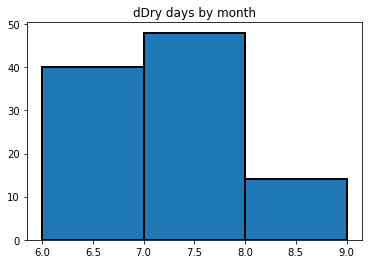

In [67]:
plt.hist(HMG_dDry.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('dDry days by month')

Text(0.5, 1.0, 'wDry days by month')

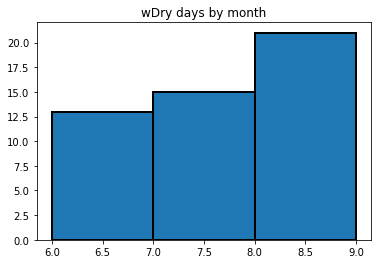

In [52]:
plt.hist(HMG_wDry.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('wDry days by month')

Text(0.5, 1.0, 'dWet days by month')

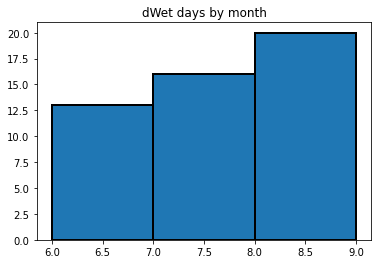

In [53]:
plt.hist(HMG_dWet.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('dWet days by month')

Text(0.5, 1.0, 'wWet days by month')

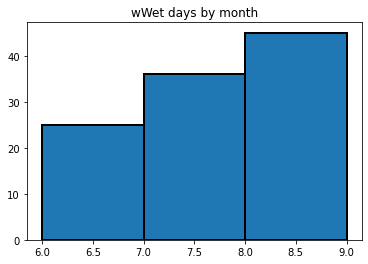

In [68]:
plt.hist(HMG_wWet.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('wWet days by month')

In [192]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [193]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wDry)
dWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dWet)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wDry)
dWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dWet)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)


In [71]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dDry)
wDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wDry)
dWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dWet)
wWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wWet)

dDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dDry)
wDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wDry)
dWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dWet)
wWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wWet)

In [72]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dDry)
wDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wDry)
dWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dWet)
wWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wWet)

dDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dDry)
wDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wDry)
dWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dWet)
wWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wWet)

In [194]:
# Get means a function of hour of day
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wDry_HMG = wDryDays_HMG.groupby("time.hour").mean()
hourlyMean_wDry_HTG = wDryDays_HTG.groupby("time.hour").mean()

hourlyMean_dWet_HMG = dWetDays_HMG.groupby("time.hour").mean()
hourlyMean_dWet_HTG = dWetDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()

# Get std as function of hour of day
hourlyStd_dDry_HMG = dDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTG = dDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wDry_HMG = wDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wDry_HTG = wDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dWet_HMG = dWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dWet_HTG = dWetDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMG = wWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTG = wWetDays_HTG.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDry = np.full([24], np.nan)
nTimes_wDry = np.full([24], np.nan)
nTimes_dWet = np.full([24], np.nan)
nTimes_wWet = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr] = len(np.where(dDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wDry[iHr] = len(np.where(wDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_dWet[iHr] = len(np.where(dWetDays_HMG["time.hour"]==iHr)[0])
    nTimes_wWet[iHr] = len(np.where(wWetDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

hourlyMean_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
hourlyMean_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

hourlyMean_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
hourlyMean_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

hourlyMean_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)



In [74]:
## For some reason, the CLM DS's can't run .std, so just make a function that will do it for a selected var
'''
Get standard error for a CLM variable per hour 

All inputs are a string: varSel is the variable to get SE for (assumed 1D)
                         modelComponent is whether this is a variable in CAM or CLM
                         dayClass is the 4-letter abbreviation of day class (dDry, wDry, etc.)

'''

def get_hourlySE(varSel, modelComponent, dayClass):
    
    # Select data 
    if modelComponent=='CAM':
        
        if dayClass=='dDry':
            dsHMG = dDryDays_HMG
            dsHTG = dDryDays_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDays_HMG
            dsHTG = wDryDays_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDays_HMG
            dsHTG = dWetDays_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDays_HMG
            dsHTG = wWetDays_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    elif modelComponent=='CLM':
        
        if dayClass=='dDry':
            dsHMG = dDryDaysCLM_HMG
            dsHTG = dDryDaysCLM_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDaysCLM_HMG
            dsHTG = wDryDaysCLM_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDaysCLM_HMG
            dsHTG = dWetDaysCLM_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDaysCLM_HMG
            dsHTG = wWetDaysCLM_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    else: 
        print('Please select either "CAM" or "CLM" as valid model component options')
        
    ## Now get standard error for selected variable
    varSE_HMG = np.full([24], np.nan)
    varSE_HTG = np.full([24], np.nan)
    
    for iHr in range(24):
        iselHr = np.where(dsHMG["time.hour"].values==iHr)[0]
        
        varHr_HMG = np.squeeze(dsHMG[varSel].values[iselHr,:])
        varSE_HMG[iHr] = np.nanstd(varHr_HMG)/np.sqrt(len(varHr_HMG))
        
        varHr_HTG = np.squeeze(dsHTG[varSel].values[iselHr,:])
        varSE_HTG[iHr] = np.nanstd(varHr_HTG)/np.sqrt(len(varHr_HTG))
    
    return(varSE_HMG, varSE_HTG)


In [75]:
# Get means a function of hour of day
hourlyMeanCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").mean()

# # Get std a function of hour of day
# hourlyStdCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").std(dim='time')

# # Number of obs going into the means 
# hourlyMeanCLM_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
# hourlyMeanCLM_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

# hourlyMeanCLM_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
# hourlyMeanCLM_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

# hourlyMeanCLM_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
# hourlyMeanCLM_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

# hourlyMeanCLM_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
# hourlyMeanCLM_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)


In [76]:
# Get means a function of hour of day
hourlyMeanPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").mean()

# # Get std a function of hour of day
# hourlyStdPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").std(dim='time')

# # Number of obs going into the means 
# hourlyMeanPatch_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
# hourlyMeanPatch_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

# hourlyMeanPatch_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
# hourlyMeanPatch_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

# hourlyMeanPatch_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
# hourlyMeanPatch_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

# hourlyMeanPatch_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
# hourlyMeanPatch_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)


In [77]:
## Print some summary daily means for each case 

print('                   dDry      wDry      dWet      wWet')
print('                   -----     -----     -----     -----')
print('Daily rain (HMG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HMG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HMG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_wWet.PRECT_mmPerDT.values)))
print('           (HTG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HTG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HTG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_wWet.PRECT_mmPerDT.values)))
print()
varSel = 'TGCLDLWP'
print('Daily TGCLDLWP (HMG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('               (HTG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDTOT'
print('Daily CLDTOT (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDLOW'
print('Daily CLDLOW (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDMED'
print('Daily CLDMED (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'CLDHGH'
print('Daily CLDHGH (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'QFLX_EVAP_TOT'
print('Daily ET (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('         (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))
print()
varSel = 'FSH'
print('Daily SHFLX (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('            (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))

print()
varSel = 'SOILWATER_10CM'
print('Daily SM_10CM (HMG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('              (HTG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))





                   dDry      wDry      dWet      wWet
                   -----     -----     -----     -----
Daily rain (HMG):   0.17     0.31      5.44      9.12
           (HTG):   0.19     0.33      5.32      9.28

Daily TGCLDLWP (HMG): 1.73e-02 3.34e-02  9.07e-02  1.18e-01
               (HTG): 1.80e-02 3.28e-02  8.96e-02  1.21e-01

Daily CLDTOT (HMG): 0.52     0.69      0.86      0.92
             (HTG): 0.49     0.75      0.85      0.93

Daily CLDLOW (HMG): 0.02     0.07      0.09      0.17
             (HTG): 0.02     0.06      0.08      0.16

Daily CLDMED (HMG): 0.18     0.22      0.53      0.50
             (HTG): 0.17     0.25      0.53      0.47

Daily CLDHGH (HMG): 0.45     0.61      0.79      0.88
             (HTG): 0.43     0.66      0.79      0.89

Daily ET (HMG):  3.95e-05   3.53e-05   4.19e-05   3.73e-05
         (HTG):  3.94e-05   3.54e-05   4.19e-05   3.70e-05

Daily SHFLX (HMG):  5.79e+01   5.22e+01   2.47e+01   2.32e+01
            (HTG):  6.04e+01   5.48e+01   2.

Text(0.5, 0, 'Local Hour')

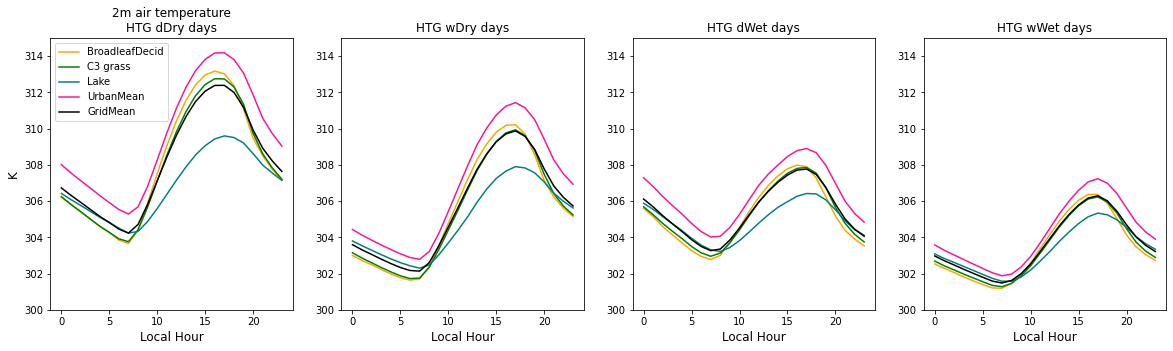

In [78]:
varSel = 'TSA'

## Get urban mean
iUrban = np.where((colType>=70) & (colType<80))[0]

varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wDry = np.nansum(hourlyMeanPatch_wDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_dWet = np.nansum(hourlyMeanPatch_dWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

patchLabels[0] = 'BroadleafDecid'


yMax = np.asarray([315])
yMin = np.asarray([300])

fig,axs = plt.subplots(1,4, figsize=(20,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 0]),
         color='orange', label=patchLabels[0])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 1]),
         color='green', label=patchLabels[1])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
         color='deeppink',label='UrbanMean')
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',fontsize=10)
axs[0].set_title(HTGclmDS_patch_local[varSel].long_name+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])


## wDry days 
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, varSel_urban_wDry,
         color='deeppink',label='UrbanMean')
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG[varSel].values, 'k-',label='GridMean')
axs[1].set_title('\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])


## dWet days 
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, varSel_urban_dWet,
         color='deeppink',label='UrbanMean')
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG[varSel].values, 'k-',label='GridMean')
axs[2].set_title('\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])


## wWet days 
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
         color='deeppink',label='UrbanMean')
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel].values, 'k-',label='GridMean')
axs[3].set_title('\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])


axs[0].set_ylabel(HTGclmDS_patch_local[varSel].units, fontsize=12)
axs[0].set_xlabel('Local Hour', fontsize=12)
axs[1].set_xlabel('Local Hour', fontsize=12)
axs[2].set_xlabel('Local Hour', fontsize=12)
axs[3].set_xlabel('Local Hour', fontsize=12)

axs[0].grid()


Text(0.5, 0, 'Local Hour')

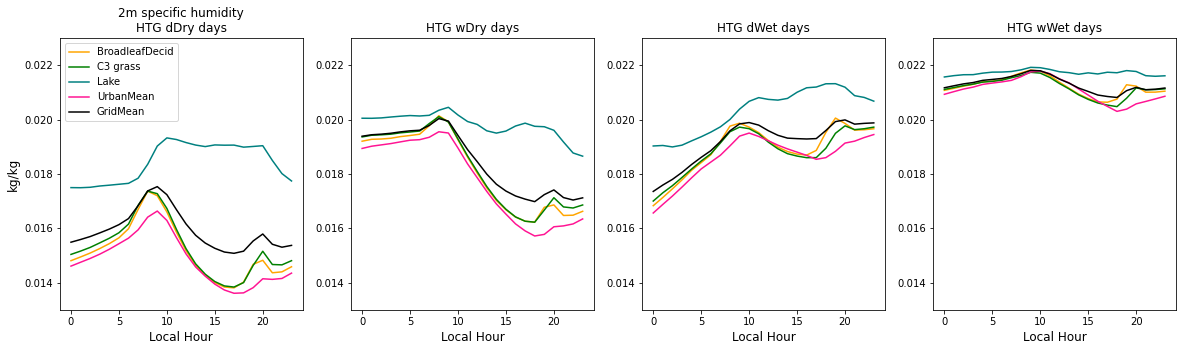

In [79]:
varSel = 'Q2M'

## Get urban mean
iUrban = np.where((colType>=70) & (colType<80))[0]

varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wDry = np.nansum(hourlyMeanPatch_wDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_dWet = np.nansum(hourlyMeanPatch_dWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])


yMax = np.asarray([0.023])
yMin = np.asarray([0.013])

fig,axs = plt.subplots(1,4, figsize=(20,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 0]),
         color='orange', label=patchLabels[0])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 1]),
         color='green', label=patchLabels[1])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
         color='deeppink',label='UrbanMean')
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',fontsize=10)
axs[0].set_title(HTGclmDS_patch_local[varSel].long_name+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])


## wDry days 
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, varSel_urban_wDry,
         color='deeppink',label='UrbanMean')
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG[varSel].values, 'k-',label='GridMean')
axs[1].set_title('\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])


## dWet days 
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, varSel_urban_dWet,
         color='deeppink',label='UrbanMean')
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG[varSel].values, 'k-',label='GridMean')
axs[2].set_title('\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])


## wWet days 
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
         color='deeppink',label='UrbanMean')
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel].values, 'k-',label='GridMean')
axs[3].set_title('\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])


axs[0].set_ylabel(HTGclmDS_patch_local[varSel].units, fontsize=12)
axs[0].set_xlabel('Local Hour', fontsize=12)
axs[1].set_xlabel('Local Hour', fontsize=12)
axs[2].set_xlabel('Local Hour', fontsize=12)
axs[3].set_xlabel('Local Hour', fontsize=12)


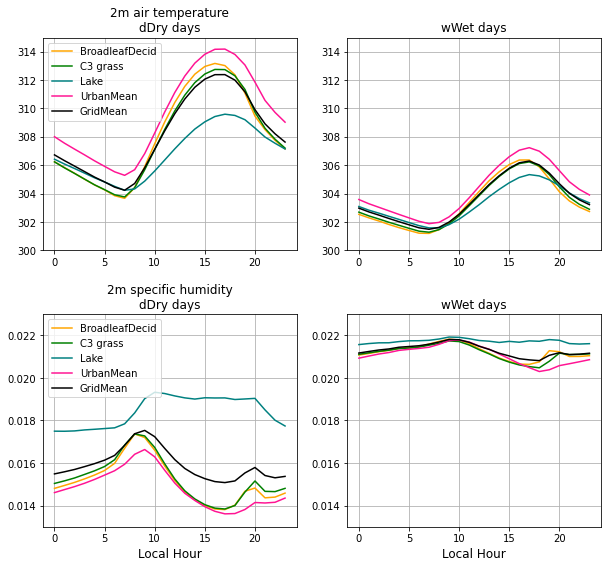

In [377]:
## Figure for manuscript

varSel = np.asarray(['TSA','Q2M'])
patchLabels[0] = 'BroadleafDecid'

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)


yMax = np.asarray([315, 0.023])
yMin = np.asarray([300, 0.013])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    ## dDry days 
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 0]),
             color='orange', label=patchLabels[0])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 1]),
             color='green', label=patchLabels[1])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
             color='deeppink',label='UrbanMean')
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot].legend(loc='upper left',fontsize=10)
    axs[iPlot].set_title(HTGclmDS_patch_local[varSel[iVar]].long_name+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 0]),
             color='orange',label=patchLabels[0])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 1]),
             color='green',label=patchLabels[1])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
             color='deeppink',label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()


In [81]:
HMGcamDS_local.ilev.values[-1]

41.0

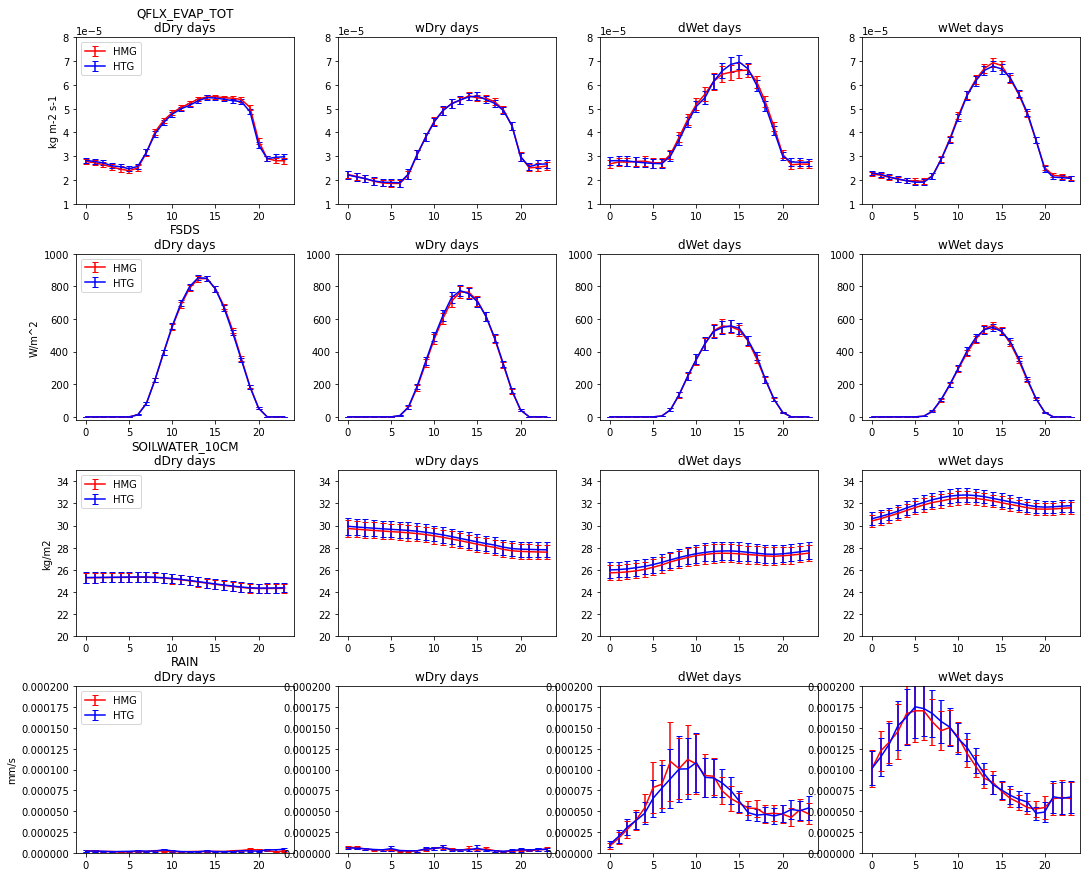

In [72]:
varSel = np.asarray(['QFLX_EVAP_TOT', 'FSDS','SOILWATER_10CM','RAIN'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([8e-5, 1000, 35, 2e-4])
yMin = np.asarray([1e-5, -20,  20, 0])

iPlot=0
for iVar in range(len(varSel)):
    
    # First get SE 
    HMGse_dDry, HTGse_dDry = get_hourlySE(varSel[iVar], 'CLM', 'dDry')
    HMGse_wDry, HTGse_wDry = get_hourlySE(varSel[iVar], 'CLM', 'wDry')
    HMGse_dWet, HTGse_dWet = get_hourlySE(varSel[iVar], 'CLM', 'dWet')
    HMGse_wWet, HTGse_wWet = get_hourlySE(varSel[iVar], 'CLM', 'wWet')
    
    
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HMG[varSel[iVar]].values),
                          yerr = 2*HMGse_dDry,
                          fmt='r-',capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[iPlot+0].set_ylabel(HTGclmDS_local['PBLH'].units)
    else: 
        axs[iPlot+0].set_ylabel(HTGclmDS_local[varSel[iVar]].units)
    

    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_wDry,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_wDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_dWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HMG[varSel[iVar]].values), 
                          yerr=2*HMGse_wWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HTG[varSel[iVar]].values), 
                          yerr=2*HTGse_wWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4

    



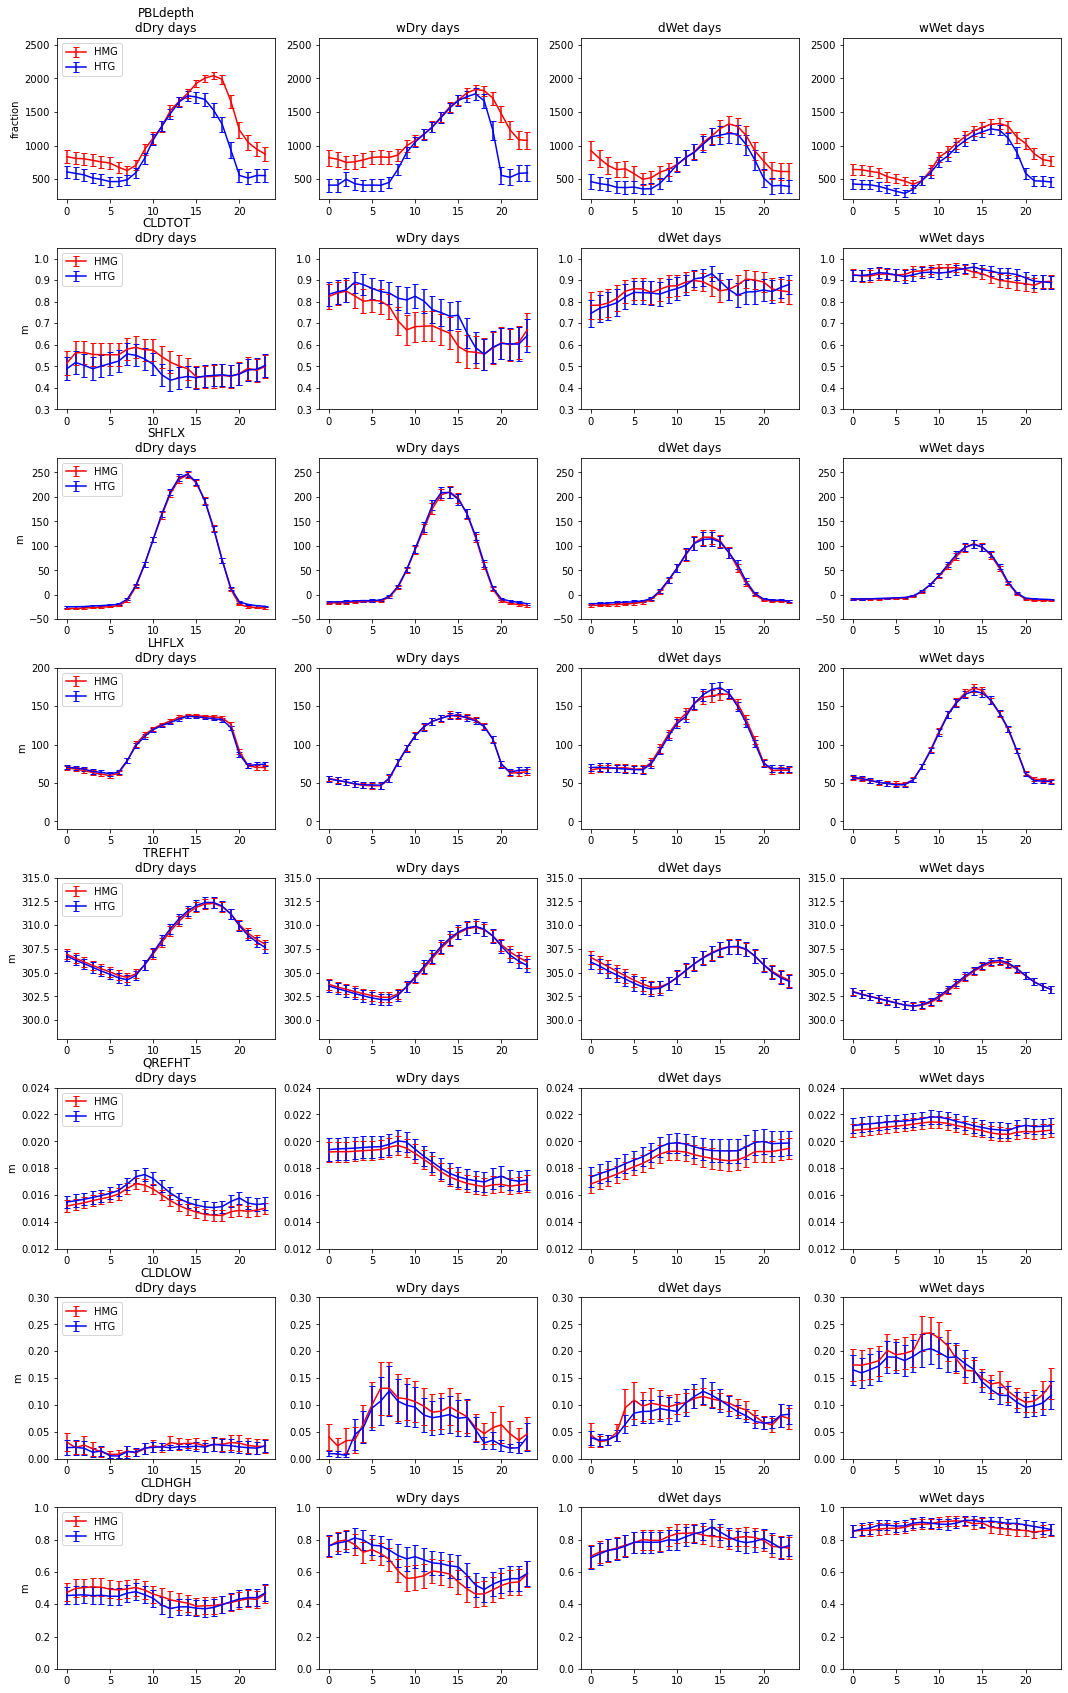

In [82]:
varSel = np.asarray(['PBLdepth','CLDTOT','SHFLX','LHFLX','TREFHT','QREFHT','CLDLOW','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,30))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2600, 1.05, 280, 200, 315, 0.0240, 0.3, 1.0])
yMin = np.asarray([ 200, 0.3,  -50, -10, 298, 0.0120, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b-', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')
#     axs[iPlot+0].grid()


    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





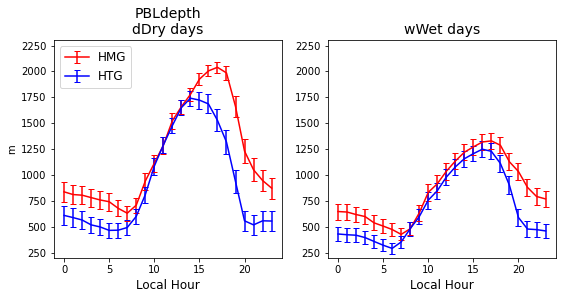

In [83]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 200])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2







In [124]:
print('HMG: ', np.squeeze(hourlyMean_dDry_HMG['PBLdepth'].values))
print()
print('HG: ', np.squeeze(hourlyMean_dDry_HTG['PBLdepth'].values))

HMG:  [ 837.01844917  810.823834    804.81105846  781.39740452  758.49789746
  741.59663883  677.85606077  630.69588975  708.40691376  940.43874383
 1113.6720894  1285.00095767 1523.04178197 1659.20650397 1777.14980835
 1924.91040489 2005.03322042 2039.92071254 1985.36496169 1661.63568521
 1230.81746808 1049.95267141  946.65309733  872.99217225]

HG:  [ 609.55202546  588.27613212  564.99647164  518.10745948  497.93047179
  464.87905067  466.7280303   492.54405359  600.00778664  809.43815842
 1085.27381906 1288.59555288 1476.60270696 1649.98343406 1741.58269505
 1722.79731601 1686.2094474  1527.37812941 1317.8719813   936.43762385
  557.13515008  518.05714869  557.18532314  555.14267633]


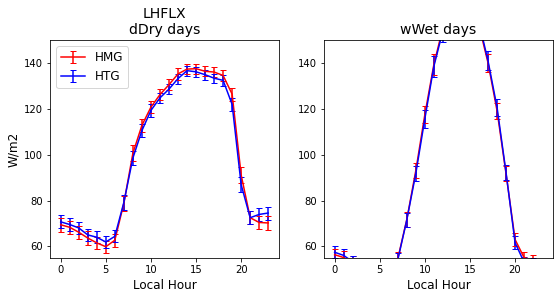

In [116]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['LHFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([150])
yMin = np.asarray([ 55])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


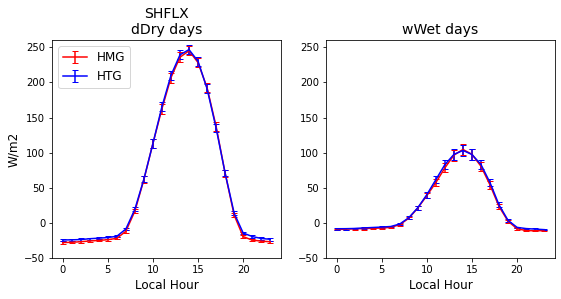

In [85]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['SHFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([260])
yMin = np.asarray([ -50])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



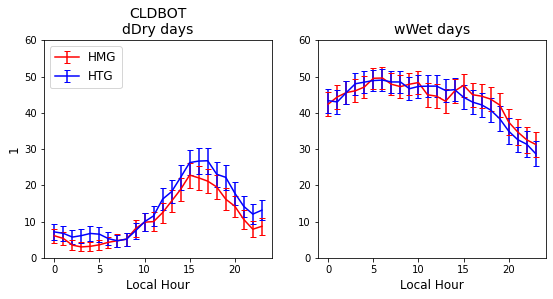

In [135]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['CLDBOT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([60])
yMin = np.asarray([ 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




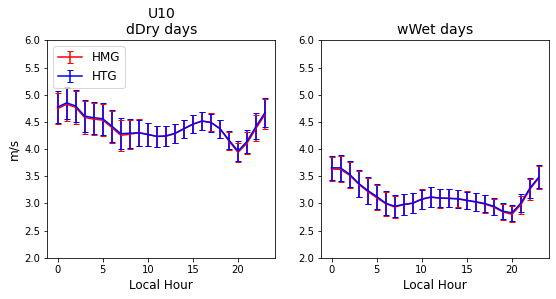

In [173]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['U10'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([6])
yMin = np.asarray([2])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



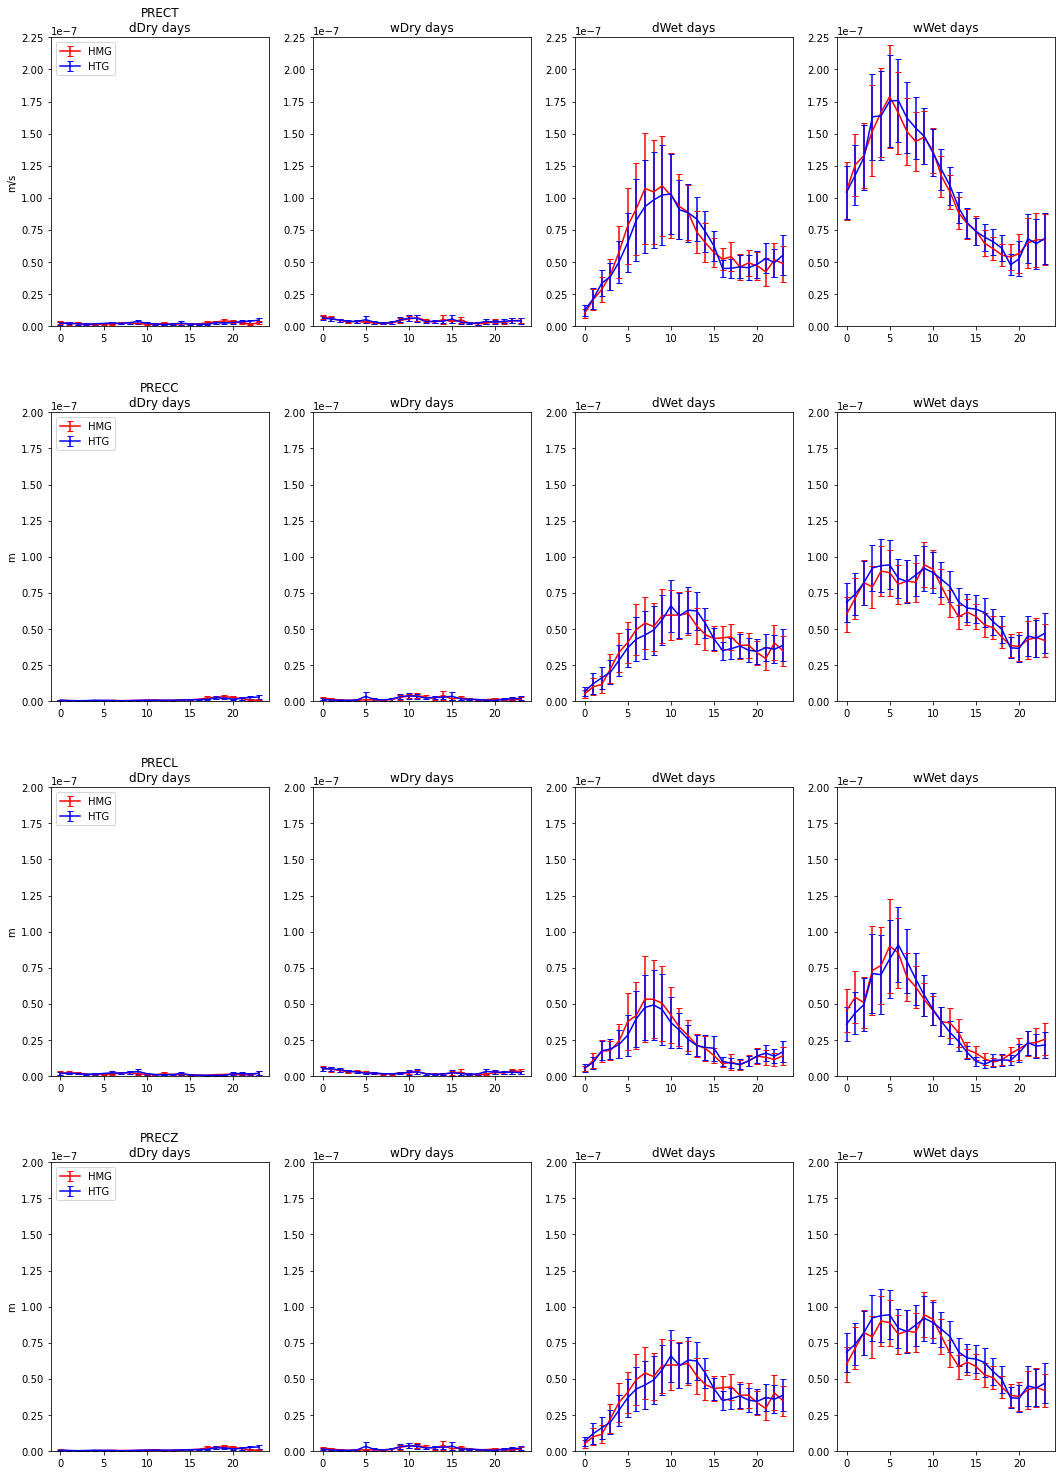

In [77]:
varSel = np.asarray(['PRECT','PRECC','PRECL','PRECZ'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.25e-7, 2e-7, 2e-7, 2e-7])
yMin = np.asarray([ 0.0,  0.0,  0, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






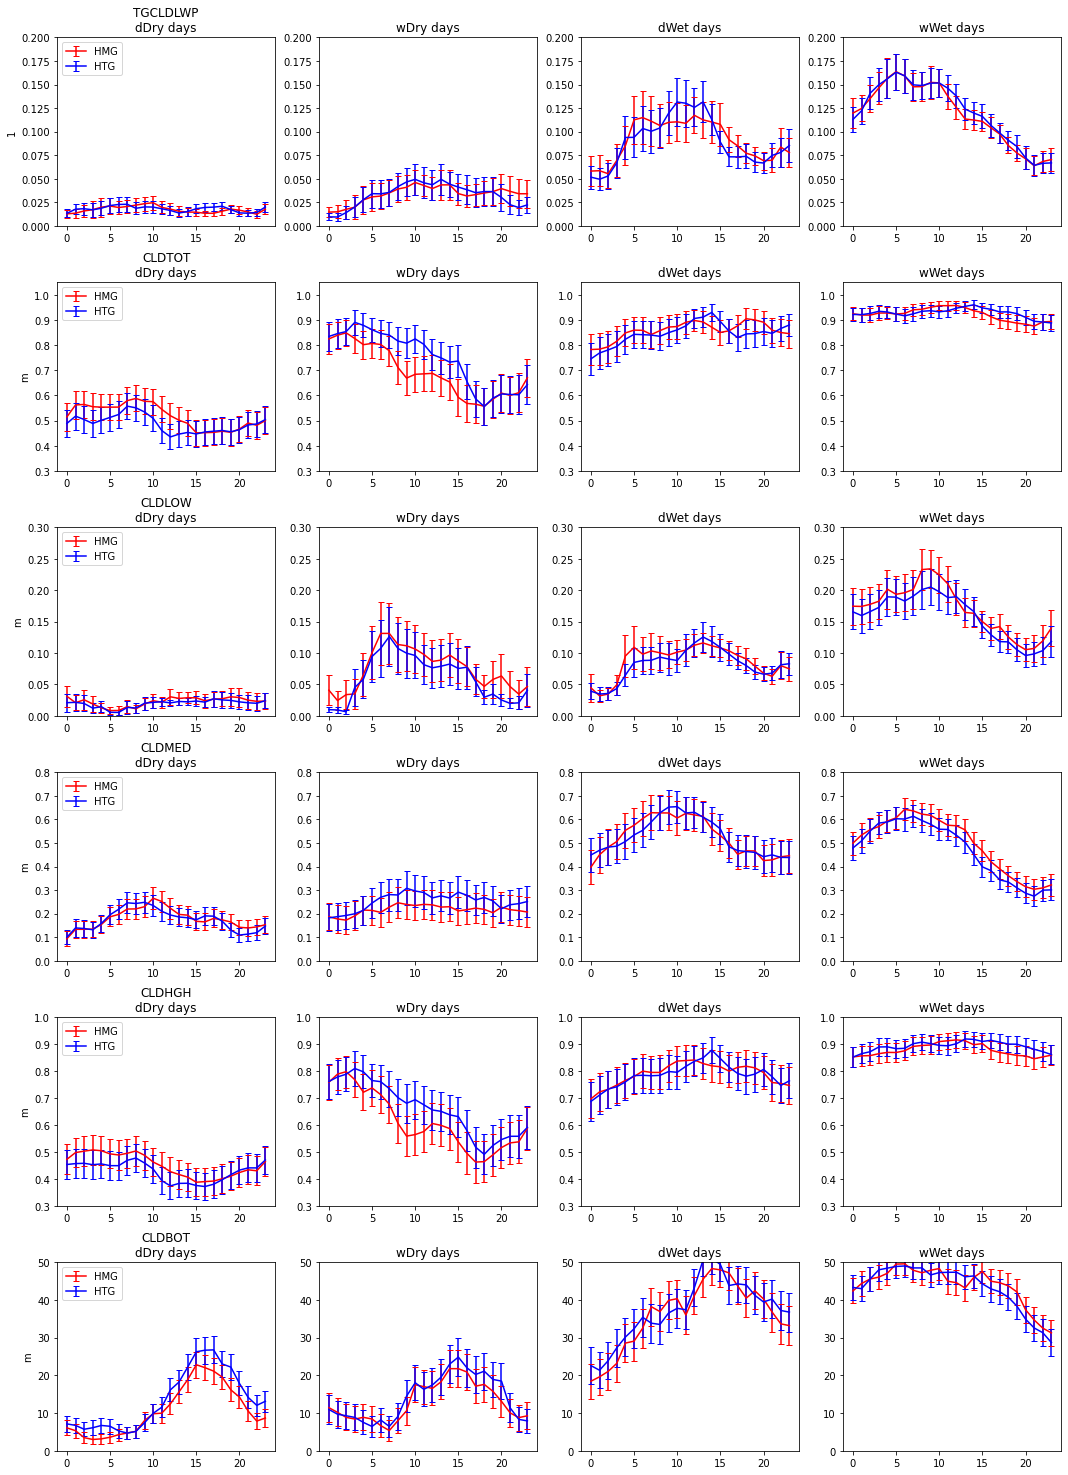

In [78]:
varSel = np.asarray(['TGCLDLWP','CLDTOT','CLDLOW','CLDMED','CLDHGH','CLDBOT'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.20, 1.05, 0.3, 0.8,   1, 50])
yMin = np.asarray([ 0.0,  0.3,   0,   0, 0.3,  0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





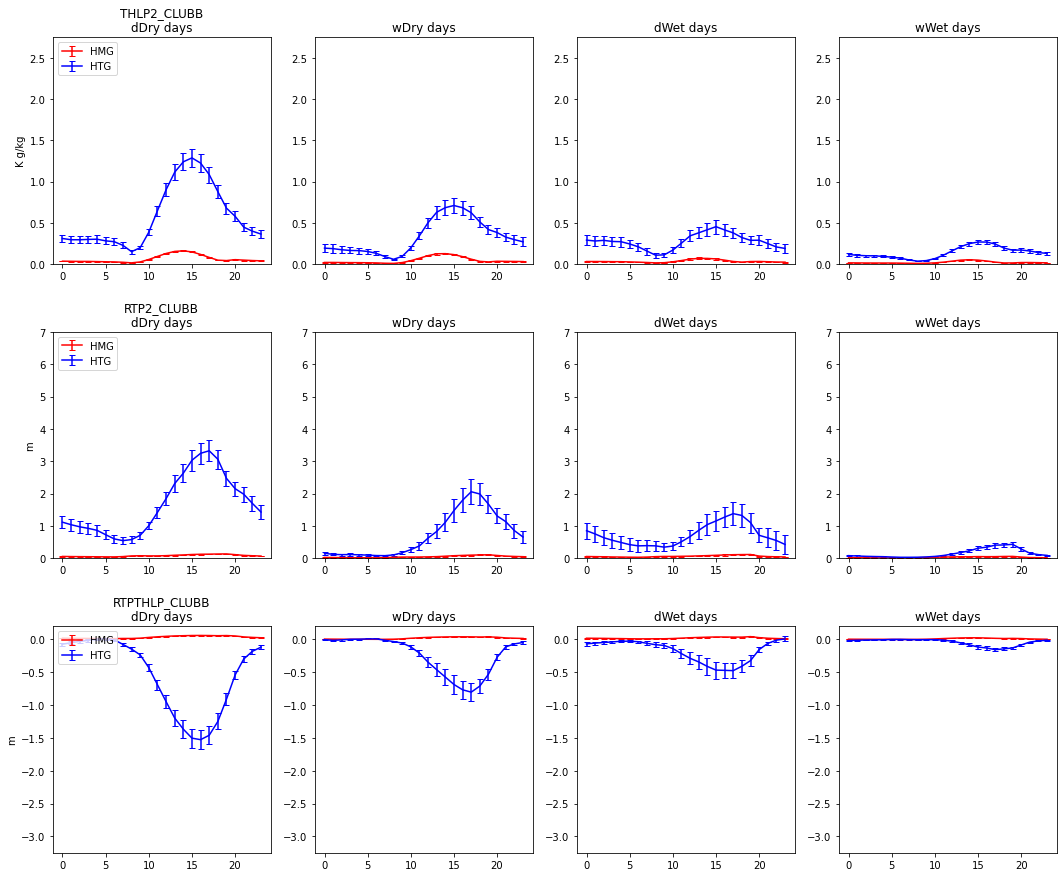

In [79]:
varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.75, 7.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.25])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
#     ax2 = axs[iPlot+0].twinx()
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





In [128]:
HTGcamDS_local.ilev.values[-1]

356.0

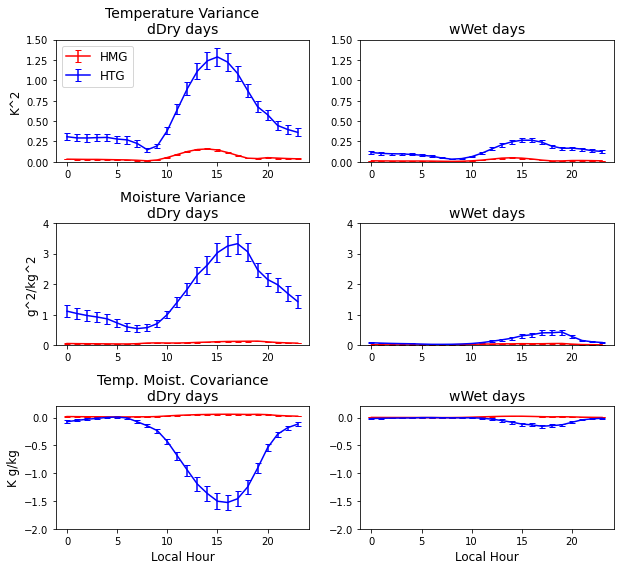

In [126]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([1.5, 4.0,  0.2])
yMin = np.asarray([0.0, 0.0, -2.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2






In [118]:
HMGcamDS_local.ilev[-1]

<xarray.DataArray 'ilev' ()>
array(41.)
Coordinates:
    ilev     float64 41.0

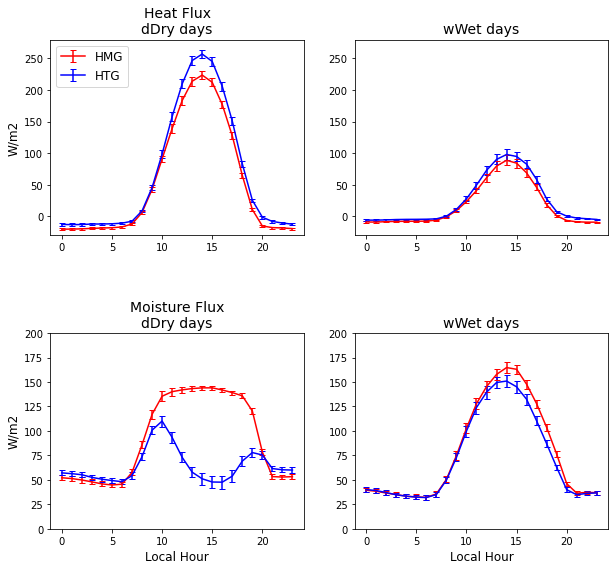

In [81]:
## Fig for manuscript 

varSel = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([280, 200])
yMin = np.asarray([-30.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2







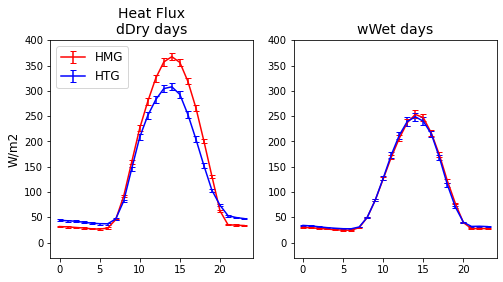

In [123]:
## FCombine the two heat fluxes

varSel = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB'])

fig,axs = plt.subplots(len(varSel)-1,2, figsize=(8,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([400, 200])
yMin = np.asarray([-30.0, 0.0])

iPlot=0
for iVar in range(len(varSel)-1):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:])+np.squeeze(hourlyMean_dDry_HMG[varSel[iVar+1]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:])+np.squeeze(hourlyMean_dDry_HTG[varSel[iVar+1]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:])+np.squeeze(hourlyMean_wWet_HMG[varSel[iVar+1]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:])+np.squeeze(hourlyMean_wWet_HTG[varSel[iVar+1]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2








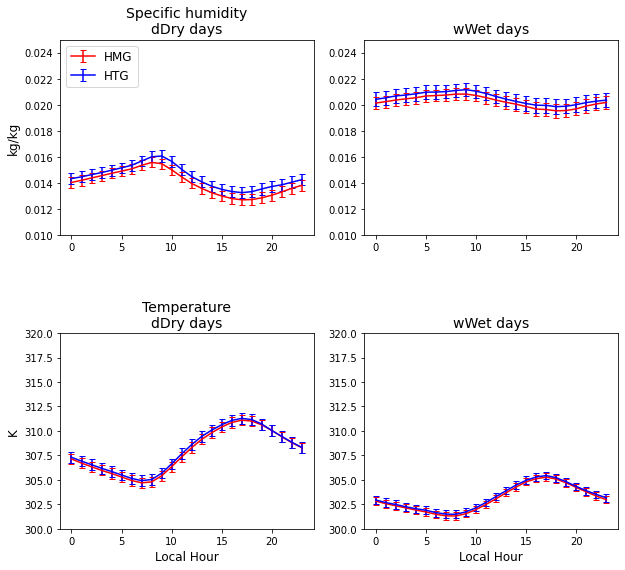

In [128]:
## Fig for manuscript 

varSel = np.asarray(['Q','T'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.025, 320])
yMin = np.asarray([0.01,  300])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2








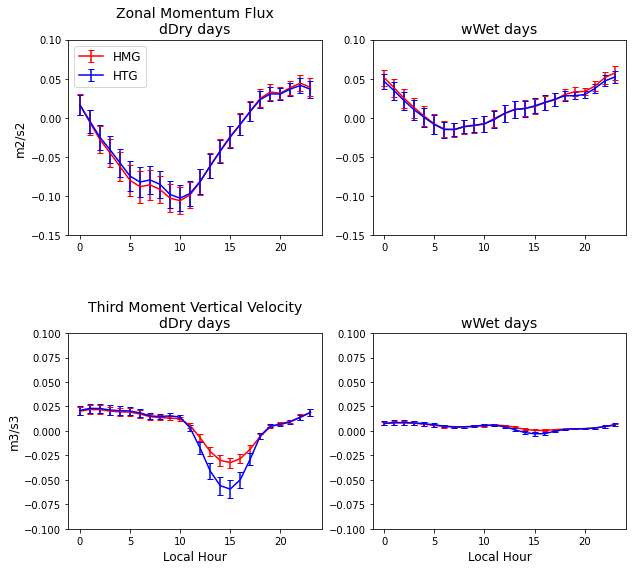

In [379]:
## Fig for manuscript 

varSel = np.asarray(['UPWP_CLUBB','WP3_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.1, 0.1])
yMin = np.asarray([-0.15, -0.1])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2








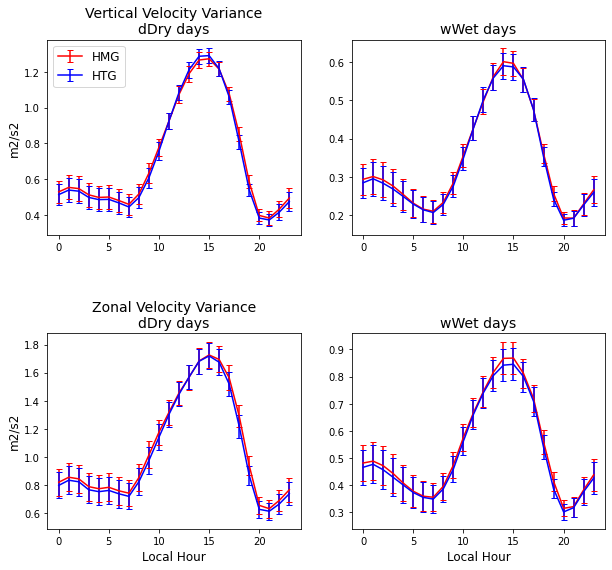

In [381]:
## Fig for manuscript 

varSel = np.asarray(['WP2_CLUBB','UP2_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
# yMax = np.asarray([0.1, 0.1])
# yMin = np.asarray([-0.15, -0.1])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2





In [82]:
print('Number of times in dDryDays_HMG: ', len(dDryDays_HMG.time.values))
print('Number of times with finite lowest level value: ', np.sum(np.isfinite(dDryDays_HMG.WPTHLP_CLUBB.values[:,-1,0,0])))
print('Number of times with NaN lowest level value: ', np.sum(np.isnan(dDryDays_HMG.WPTHLP_CLUBB.values[:,-1,0,0])))
print()
print('Number of times in wWetyDays_HMG: ', len(wWetDays_HMG.time.values))
print('Number of times with finite lowest level value: ', np.sum(np.isfinite(wWetDays_HMG.WPTHLP_CLUBB.values[:,-1,0,0])))
print('Number of times with NaN lowest level value: ', np.sum(np.isnan(wWetDays_HMG.WPTHLP_CLUBB.values[:,-1,0,0])))


Number of times in dDryDays_HMG:  7289
Number of times with finite lowest level value:  6873
Number of times with NaN lowest level value:  416

Number of times in wWetyDays_HMG:  7560
Number of times with finite lowest level value:  7414
Number of times with NaN lowest level value:  146


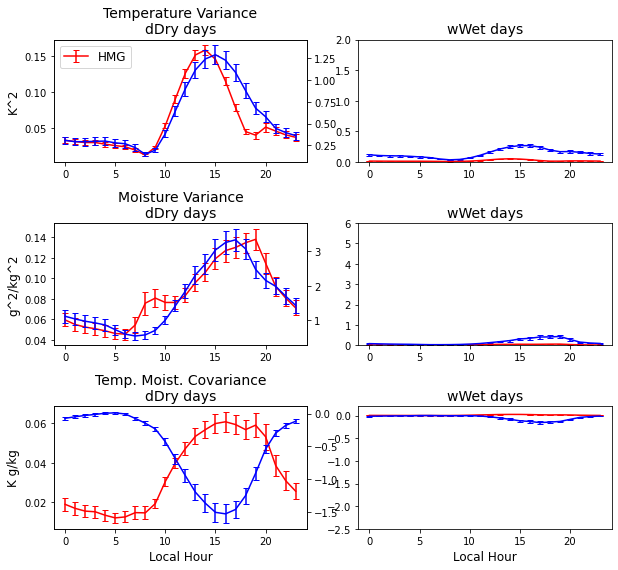

In [90]:
## Plot with two y-axes 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.0, 6.0,  0.2])
yMin = np.asarray([0.0, 0.0, -2.5])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs2 = axs[iPlot+0].twinx()
    axs2.errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




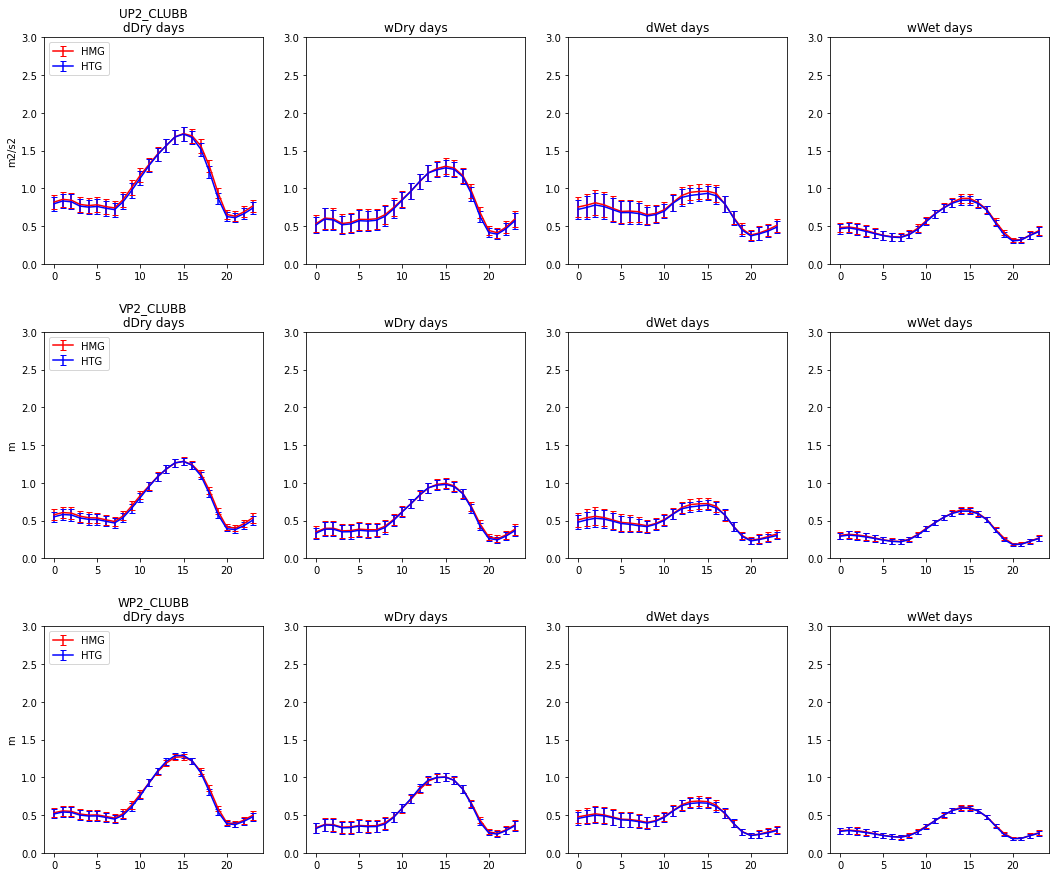

In [91]:
varSel = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([3, 3,  3])
yMin = np.asarray([0.0, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    

    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






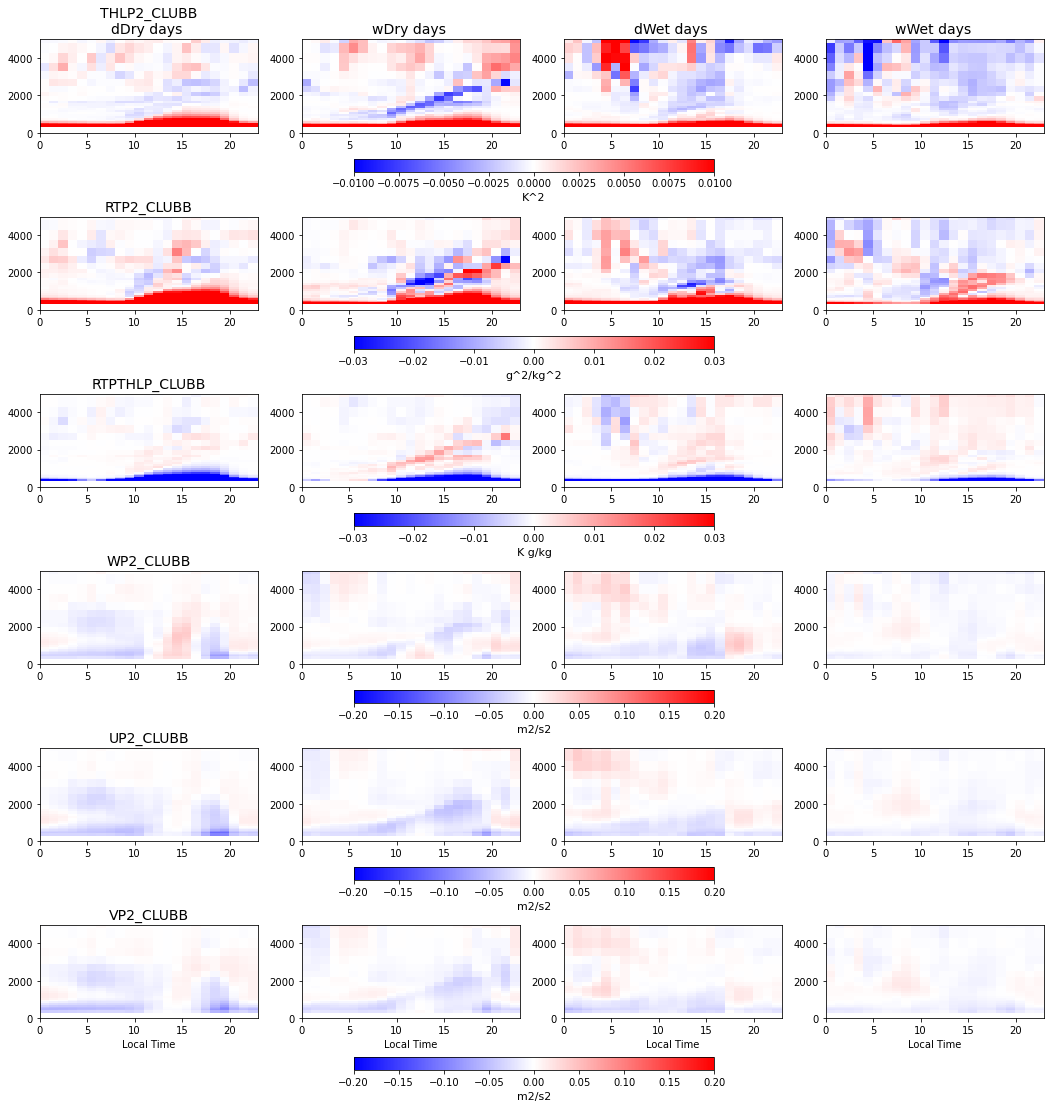

In [79]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.2, 0.2, 0.2])
yLim = 600

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].set_ylim([0,5000])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].set_ylim([0,5000])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].set_ylim([0,5000]) 
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].set_ylim([0,5000])
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

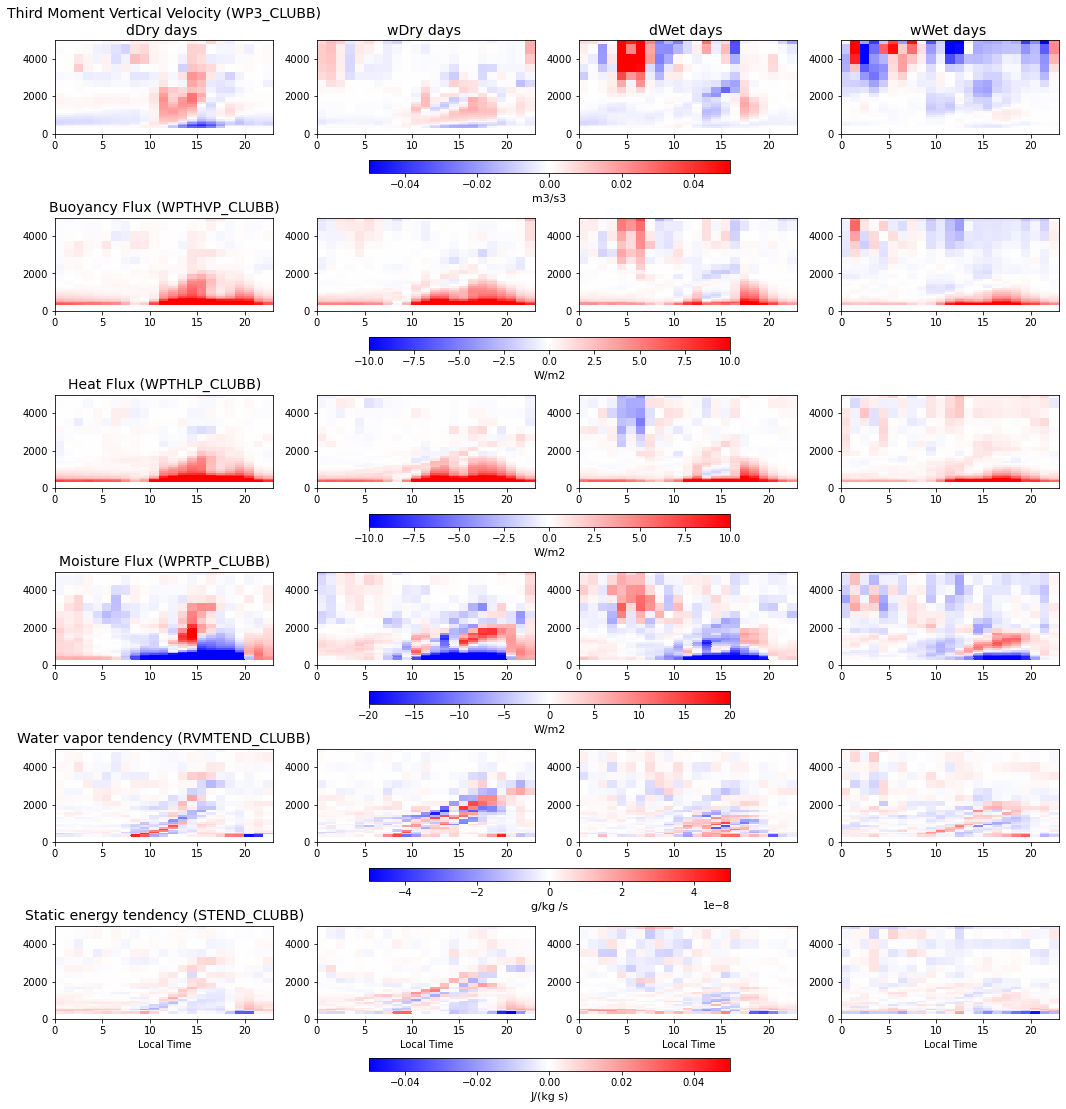

In [81]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 600

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].set_ylim([0,5000])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].set_ylim([0,5000])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_local[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].set_ylim([0,5000])  
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].set_ylim([0,5000])  
    
    axs[iPlot].set_title(HTGcamDS_local[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')',fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(HTGcamDS_local[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')'+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nT')

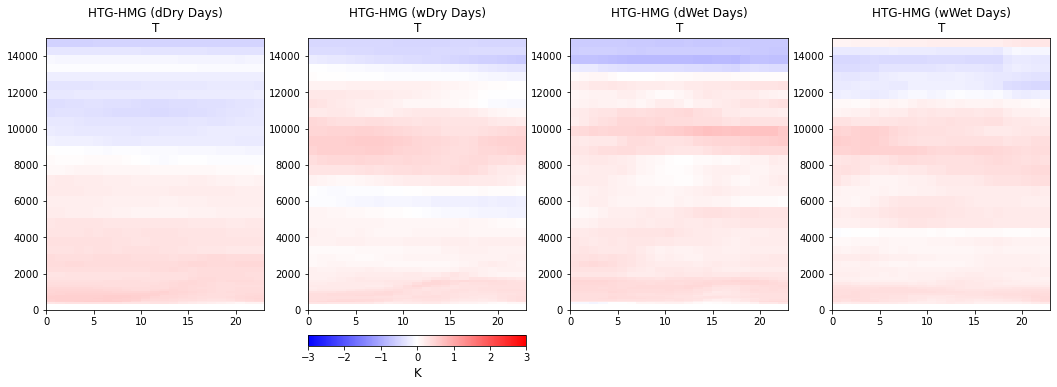

In [82]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = -3
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,15000])
axs[1].set_ylim([0,15000])
axs[2].set_ylim([0,15000])
axs[3].set_ylim([0,15000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG (wWet Days)\nT')

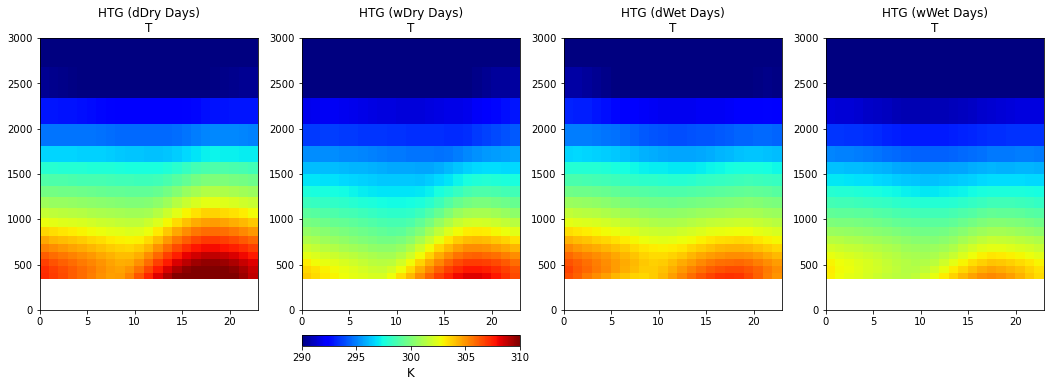

In [84]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = 290
cMax = 310 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')


# Consistent settings 
axs[0].set_ylim([0,3000])
axs[1].set_ylim([0,3000])
axs[2].set_ylim([0,3000])
axs[3].set_ylim([0,3000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG (dDry Days)\n'+varSel)
axs[1].set_title('HTG (wDry Days)\n'+varSel)
axs[2].set_title('HTG (dWet Days)\n'+varSel)
axs[3].set_title('HTG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nQ')

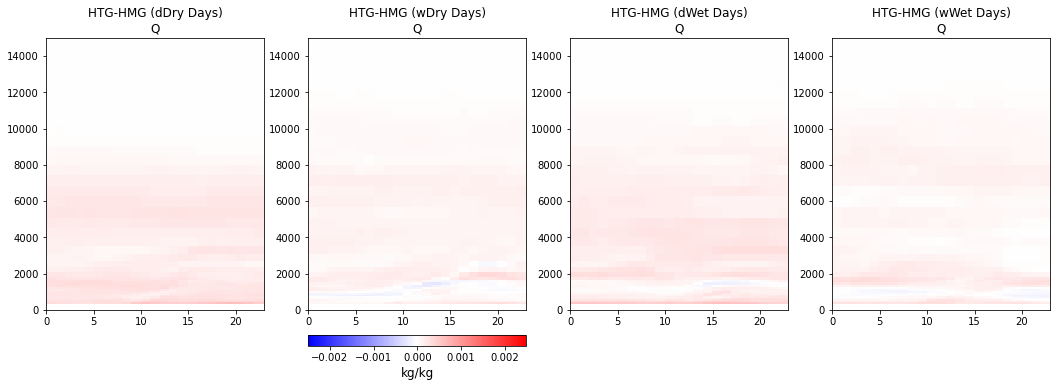

In [85]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'Q' 
cMin = -0.0025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,15000])
axs[1].set_ylim([0,15000])
axs[2].set_ylim([0,15000])
axs[3].set_ylim([0,15000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nU')

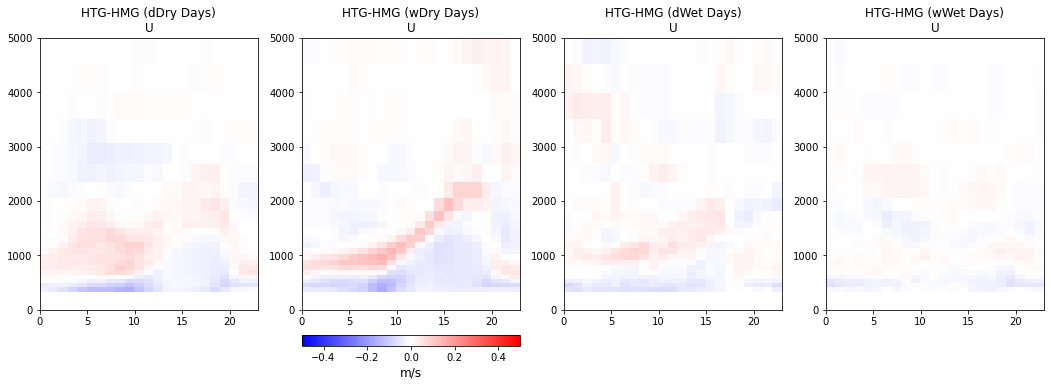

In [87]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'U' 
cMin = -0.5
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,5000])
axs[1].set_ylim([0,5000])
axs[2].set_ylim([0,5000])
axs[3].set_ylim([0,5000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\n')

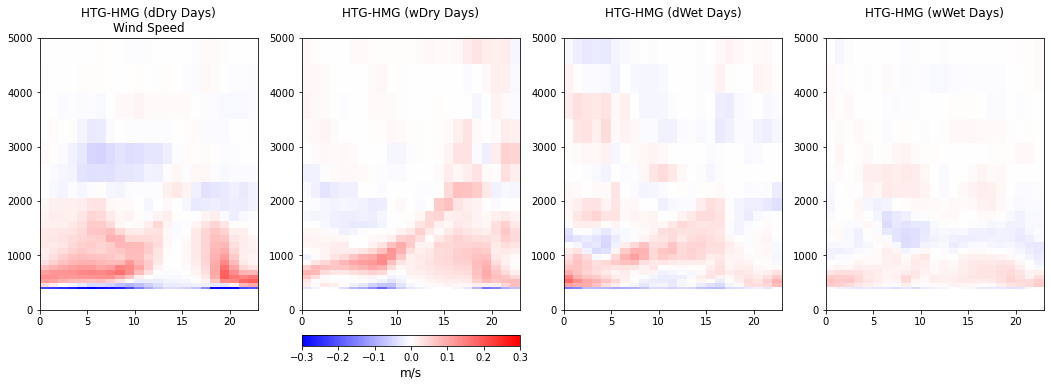

In [96]:
# Wind speed difference 
windSpeed_dDry_HTG = np.sqrt((hourlyMean_dDry_HTG['U'].values**2) + (hourlyMean_dDry_HTG['V'].values**2))
windSpeed_dDry_HMG = np.sqrt((hourlyMean_dDry_HMG['U'].values**2) + (hourlyMean_dDry_HMG['V'].values**2))

windSpeed_wDry_HTG = np.sqrt((hourlyMean_wDry_HTG['U'].values**2) + (hourlyMean_wDry_HTG['V'].values**2))
windSpeed_wDry_HMG = np.sqrt((hourlyMean_wDry_HMG['U'].values**2) + (hourlyMean_wDry_HMG['V'].values**2))

windSpeed_dWet_HTG = np.sqrt((hourlyMean_dWet_HTG['U'].values**2) + (hourlyMean_dWet_HTG['V'].values**2))
windSpeed_dWet_HMG = np.sqrt((hourlyMean_dWet_HMG['U'].values**2) + (hourlyMean_dWet_HMG['V'].values**2))

windSpeed_wWet_HTG = np.sqrt((hourlyMean_wWet_HTG['U'].values**2) + (hourlyMean_wWet_HTG['V'].values**2))
windSpeed_wWet_HMG = np.sqrt((hourlyMean_wWet_HMG['U'].values**2) + (hourlyMean_wWet_HMG['V'].values**2))

hourlyMean_dDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HTG))
hourlyMean_dDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HMG))
hourlyMean_wDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HTG))
hourlyMean_wDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HMG))
hourlyMean_dWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HTG))
hourlyMean_dWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HMG))
hourlyMean_wWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HTG))
hourlyMean_wWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HMG))


fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cMin = -0.3
cMax = -cMin 

# Define differences 
diffVar_dDry = windSpeed_dDry_HTG-windSpeed_dDry_HMG
diffVar_wDry = windSpeed_wDry_HTG-windSpeed_wDry_HMG
diffVar_dWet = windSpeed_dWet_HTG-windSpeed_dWet_HMG
diffVar_wWet = windSpeed_wWet_HTG-windSpeed_wWet_HMG

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local['U'].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,5000])
axs[1].set_ylim([0,5000])
axs[2].set_ylim([0,5000])
axs[3].set_ylim([0,5000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+'Wind Speed')
axs[1].set_title('HTG-HMG (wDry Days)\n')
axs[2].set_title('HTG-HMG (dWet Days)\n')
axs[3].set_title('HTG-HMG (wWet Days)\n')





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLDLIQ')

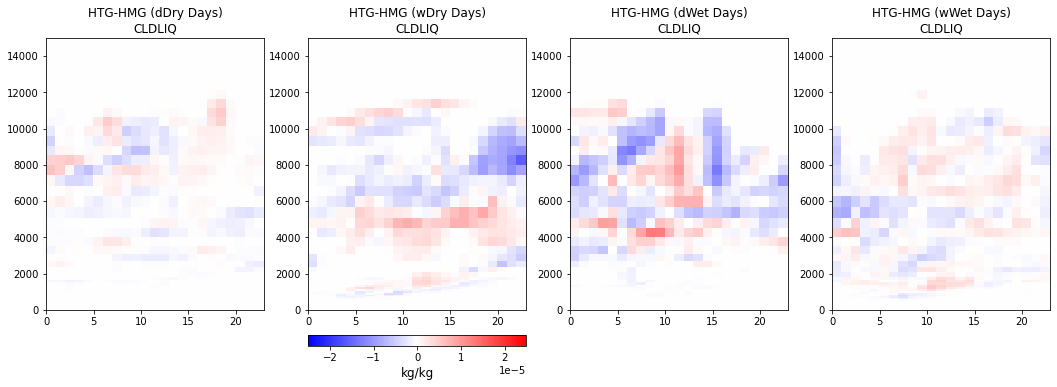

In [89]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLDLIQ' 
cMin = -0.000025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,15000])
axs[1].set_ylim([0,15000])
axs[2].set_ylim([0,15000])
axs[3].set_ylim([0,15000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLOUD')

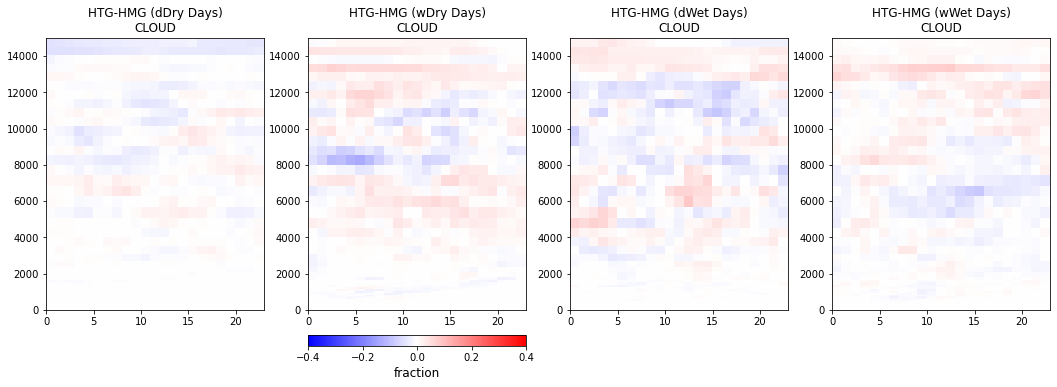

In [90]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLOUD' 
cMin = -0.4
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,15000])
axs[1].set_ylim([0,15000])
axs[2].set_ylim([0,15000])
axs[3].set_ylim([0,15000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCONCLD')

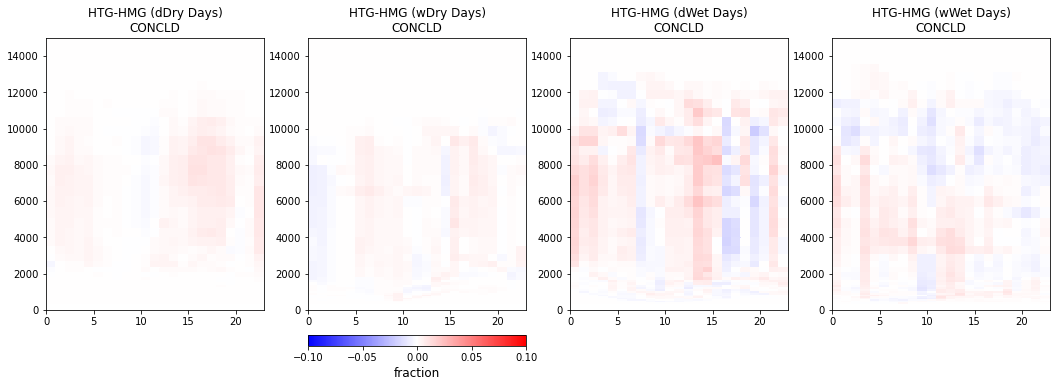

In [91]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CONCLD' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([0,15000])
axs[1].set_ylim([0,15000])
axs[2].set_ylim([0,15000])
axs[3].set_ylim([0,15000])

# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






In [195]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    


    # ------- wDry days ----------
    iTimeSel_wDryHMG = np.where((wDryDays_HMG["time.hour"].values>=startHr) & 
                                (wDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wDryHTG = np.where((wDryDays_HTG["time.hour"].values>=startHr) & 
                                (wDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).mean(dim='time')
    hourlyMean_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).mean(dim='time')
    
    hourlyStd_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).std(dim='time')
    hourlyStd_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).std(dim='time')
    
    stdErr_wDry_HMG = np.squeeze(hourlyStd_wDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wDryHMG))
    stdErr_wDry_HTG = np.squeeze(hourlyStd_wDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wDryHTG))


    # ------- dWet days ----------
    iTimeSel_dWetHMG = np.where((dWetDays_HMG["time.hour"].values>=startHr) & 
                                (dWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dWetHTG = np.where((dWetDays_HTG["time.hour"].values>=startHr) & 
                                (dWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).mean(dim='time')
    hourlyMean_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).mean(dim='time')
    
    hourlyStd_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).std(dim='time')
    hourlyStd_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).std(dim='time')
    
    stdErr_dWet_HMG = np.squeeze(hourlyStd_dWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dWetHMG))
    stdErr_dWet_HTG = np.squeeze(hourlyStd_dWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dWetHTG))


    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,4, figsize=(17,5))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
    elif varSel=='TKE':
        unitLabel = HTGcamDS_local['UP2_CLUBB'].units
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
                axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                        'bo')
    
    
    
    

    # Plot wDry days 
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wDry_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
                    hourlyMean_wDryTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
                    hourlyMean_wDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[1].set_title(varSel+'\nwDry days')
    axs[1].set_xlabel(unitLabel)
        # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) + (2*stdErr_wDry_HMG)
    xmin1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) - (2*stdErr_wDry_HMG)
    xmax2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) + (2*stdErr_wDry_HTG)
    xmin2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) - (2*stdErr_wDry_HTG)

    levSig = np.ones([len(hourlyMean_wDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev]):
                axs[1].plot(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[1].plot(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            
            

    # Plot dWet days 
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
                    hourlyMean_dWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
                    hourlyMean_dWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[2].set_title(varSel+'\ndWet days')
    axs[2].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) + (2*stdErr_dWet_HMG)
    xmin1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) - (2*stdErr_dWet_HMG)
    xmax2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) + (2*stdErr_dWet_HTG)
    xmin2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) - (2*stdErr_dWet_HTG)

    levSig = np.ones([len(hourlyMean_dWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev]):
                axs[2].plot(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[2].plot(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[3].legend()
    axs[3].set_title(varSel+'\nwWet days')
    axs[3].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
                axs[3].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[3].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    axs[2].set_ylim([minLev,maxLev])
    axs[3].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    axs[2].set_xlim([xMin,xMax])
    axs[3].set_xlim([xMin,xMax])
    
#     axs[0].invert_yaxis()
#     axs[1].invert_yaxis()
#     axs[2].invert_yaxis()
#     axs[3].invert_yaxis()
    
    return

In [196]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    

    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
        titleStr   = varSel
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
        titleStr   = varSel
    elif varSel=='Skw_W':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='TKE':
        unitLabel = HTGcamDS_local['UP2_CLUBB'].units
        titleStr = varSel
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
        titleStr   = HTGcamDS_local[varSel].long_name
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')
    
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
#     axs[1].legend()
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
#     axs[0].invert_yaxis()
#     axs[1].invert_yaxis()

    
    return

In [328]:
print(' level (hPa)      levSig         HMGval   HMG+/-       HTGval  HTG+/-')
for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
    print('%7.2f %14i %15.2e %10.2e %12.2e  %6.2e' % (hourlyMean_dDryTimeSel_HMG[levSel].values[iLev],
                                       levSig[iLev],
                                       hourlyMean_dDryTimeSel_HMG[varSel].values[iLev],
                                       (2*stdErr_dDry_HMG[iLev]),
                                       hourlyMean_dDryTimeSel_HTG[varSel].values[iLev],
                                       (2*stdErr_dDry_HTG[iLev])))

 level (hPa)      levSig         HMGval   HMG+/-       HTGval  HTG+/-
   2.95              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   4.34              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   6.31              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   8.88              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  12.26              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  16.46              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  21.58              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  27.17              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  32.83              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  37.60              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  41.23              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  45.15              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  49.40              0        0.00e+00   0.00e+00     

In [197]:
## Add wind speed to underlying DS

windSpeed_dDryDays_HMG = np.sqrt((dDryDays_HMG.U.values**2.0) + (dDryDays_HMG.V.values**2.0))
windSpeed_dDryDays_HTG = np.sqrt((dDryDays_HTG.U.values**2.0) + (dDryDays_HTG.V.values**2.0))

windSpeed_wDryDays_HMG = np.sqrt((wDryDays_HMG.U.values**2.0) + (wDryDays_HMG.V.values**2.0))
windSpeed_wDryDays_HTG = np.sqrt((wDryDays_HTG.U.values**2.0) + (wDryDays_HTG.V.values**2.0))

windSpeed_dWetDays_HMG = np.sqrt((dWetDays_HMG.U.values**2.0) + (dWetDays_HMG.V.values**2.0))
windSpeed_dWetDays_HTG = np.sqrt((dWetDays_HTG.U.values**2.0) + (dWetDays_HTG.V.values**2.0))

windSpeed_wWetDays_HMG = np.sqrt((wWetDays_HMG.U.values**2.0) + (wWetDays_HMG.V.values**2.0))
windSpeed_wWetDays_HTG = np.sqrt((wWetDays_HTG.U.values**2.0) + (wWetDays_HTG.V.values**2.0))


dDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMG))
dDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTG))

wDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HMG))
wDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HTG))

dWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HMG))
dWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HTG))

wWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMG))
wWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTG))



In [103]:
startHr = 15
endHr   = 17
# startHr = 12
# endHr   = 17
maxLev  = 2500
minLev  = 0

Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


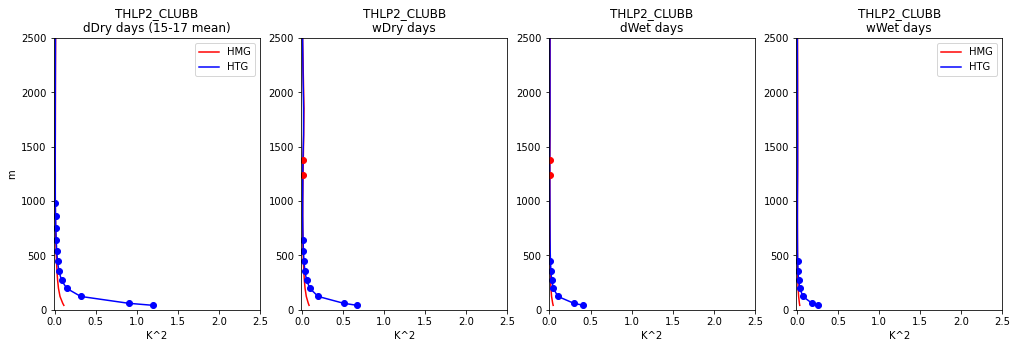

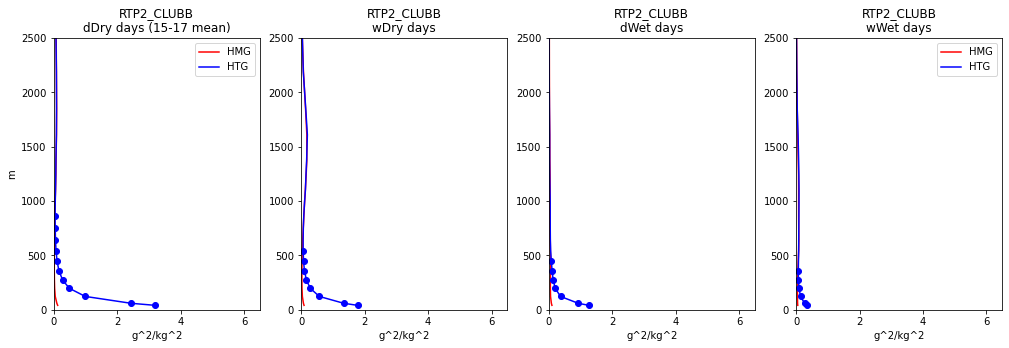

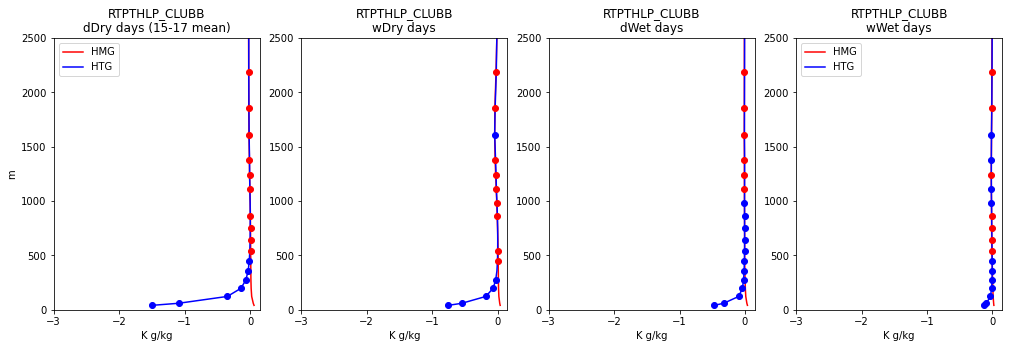

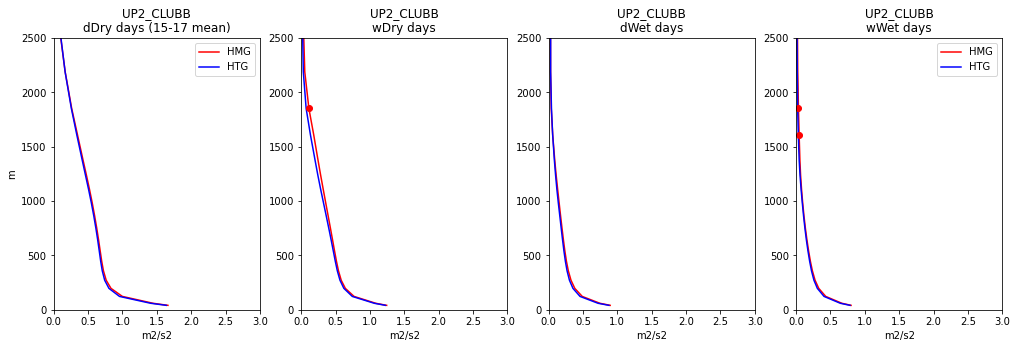

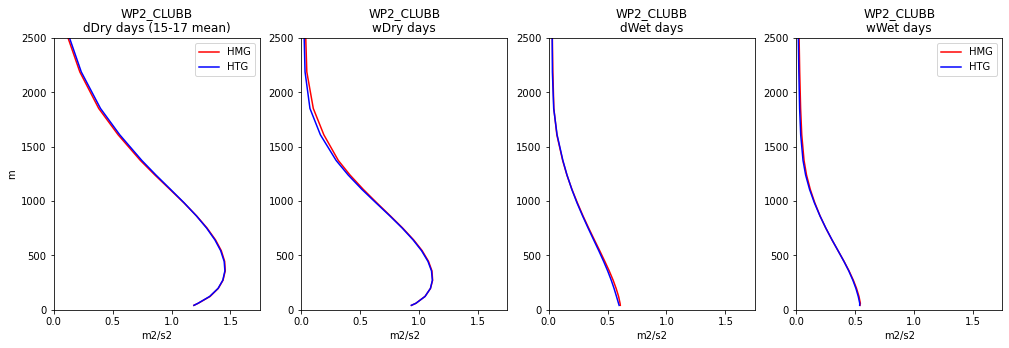

In [104]:

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'THLP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 2.5)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 6.5)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTPTHLP_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             -3.00, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UP2_CLUBB',minLev, maxLev,
#                            0.0, 2.0)
                             0.0, 3.0)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP2_CLUBB',minLev, maxLev,
#                            0.0, 0.8)
                             0.0, 1.75)



In [281]:
startHr = 15
endHr   = 18
maxLev  = 2000
minLev  = 0

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             0.0, 1.6)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 3.0)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'VP2_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             0.0, 3.0)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'TKE', minLev, maxLev,
#                            -0.75, 0.15)
                             0.0, 3.0)


NameError: name 'plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion' is not defined

Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


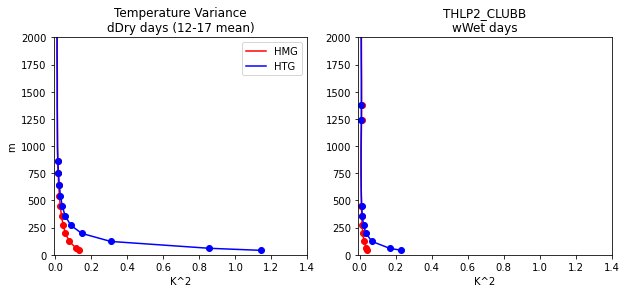

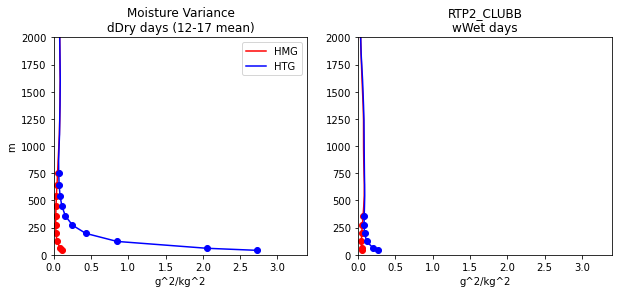

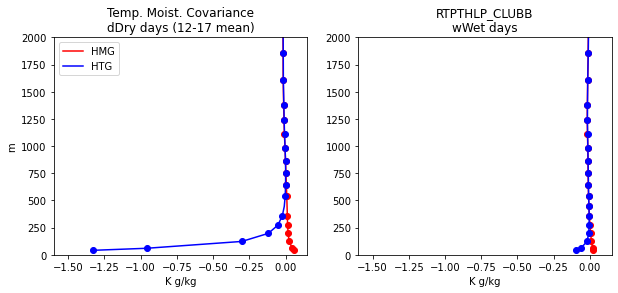

In [200]:
startHr = 12
endHr   = 17
maxLev  = 2000
minLev  = 0

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'THLP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 1.4)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 3.4)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTPTHLP_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             -1.6, 0.15)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


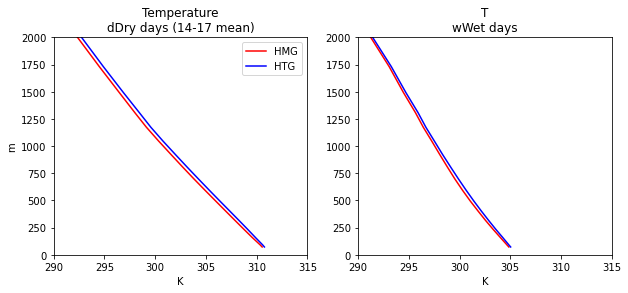

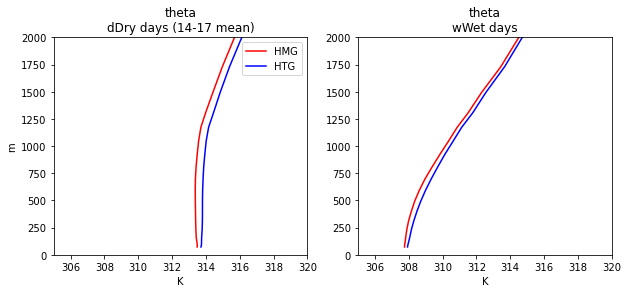

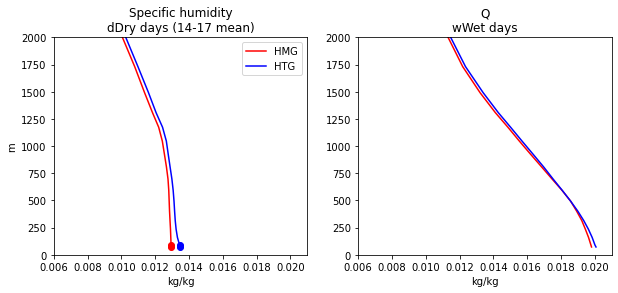

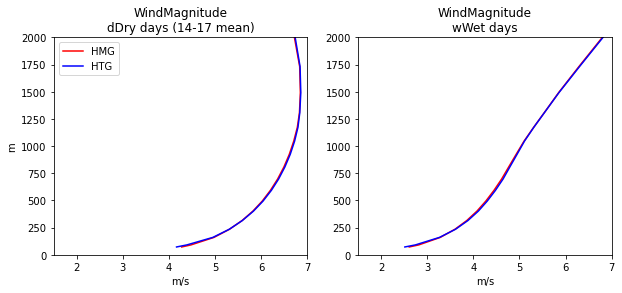

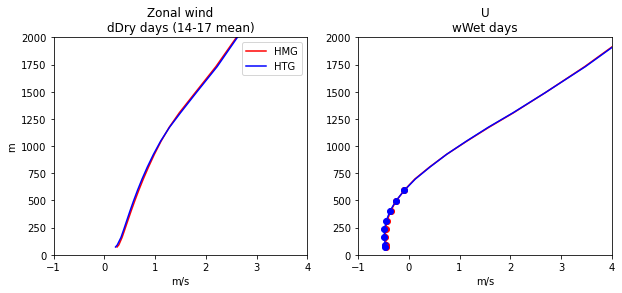

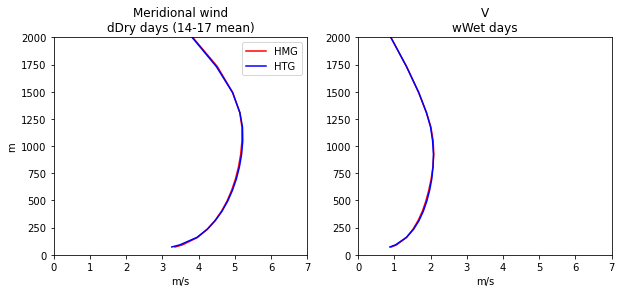

In [211]:
startHr = 14
endHr   = 17
maxLev = 2000

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'T', minLev, maxLev,
#                            280, 310)
                           290, 315)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'theta', minLev, maxLev,
#                            280, 310)
                           305, 320)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Q', minLev, maxLev,
#                            0.006, 0.022)
                           0.006, 0.021)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WindMagnitude', minLev, maxLev,
#                            0.006, 0.022)
                           1.5, 7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'U', minLev, maxLev,
#                            0.006, 0.022)
                           -1, 4)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'V', minLev, maxLev,
#                            0.006, 0.022)
                           0, 7)


Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


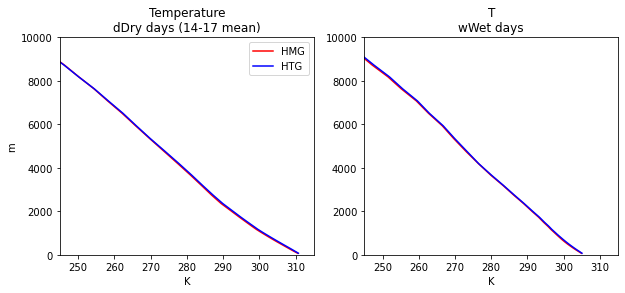

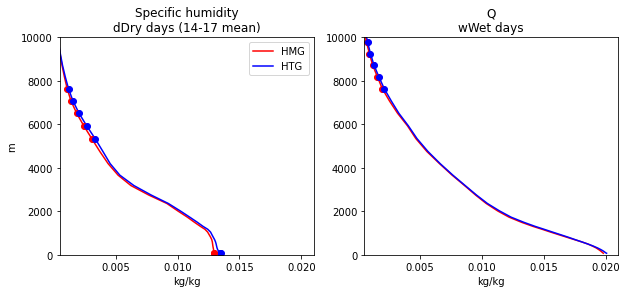

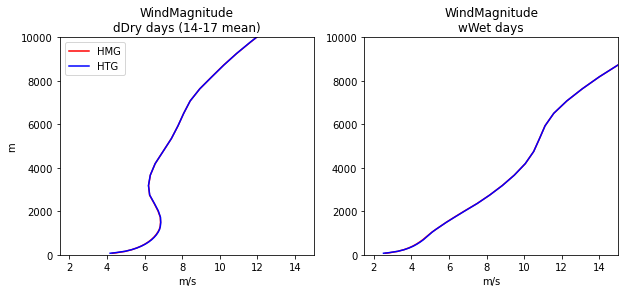

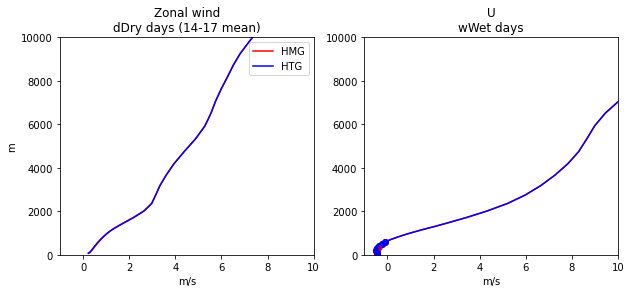

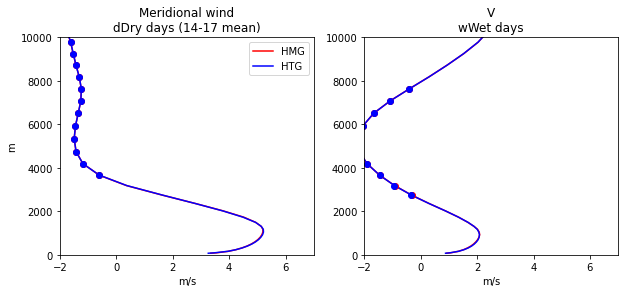

In [214]:
startHr = 14
endHr   = 17
maxLev = 10000

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'T', minLev, maxLev,
#                            280, 310)
                           245, 315)

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'theta', minLev, maxLev,
# #                            280, 310)
#                            305, 320)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Q', minLev, maxLev,
#                            0.006, 0.022)
                           0.0005, 0.021)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WindMagnitude', minLev, maxLev,
#                            0.006, 0.022)
                           1.5, 15)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'U', minLev, maxLev,
#                            0.006, 0.022)
                           -1, 10)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'V', minLev, maxLev,
#                            0.006, 0.022)
                           -2, 7)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


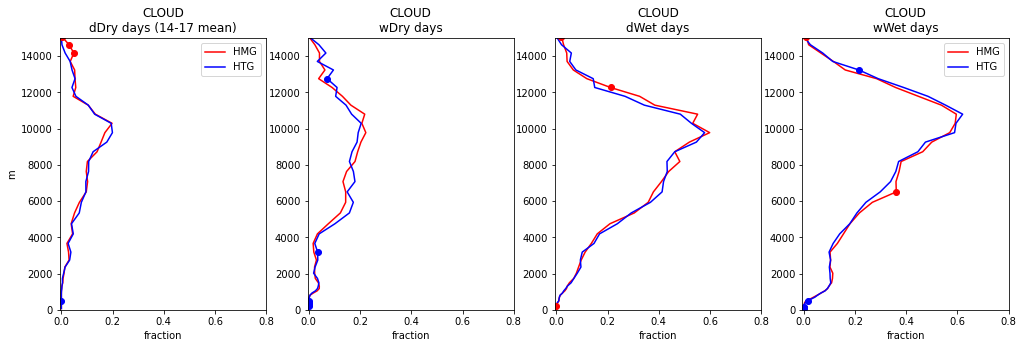

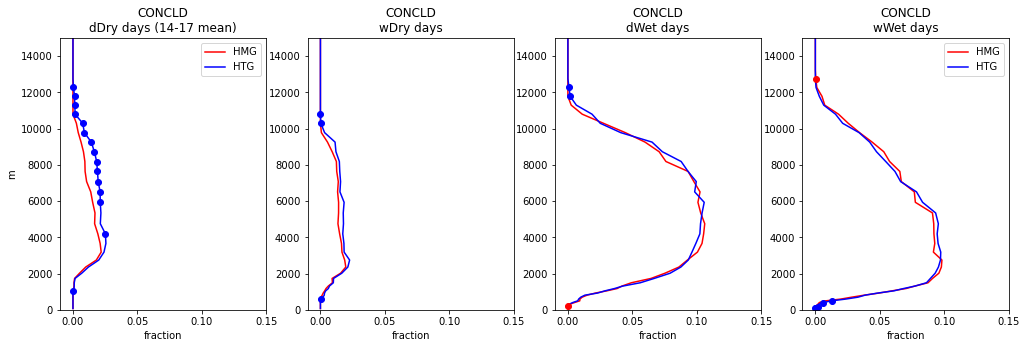

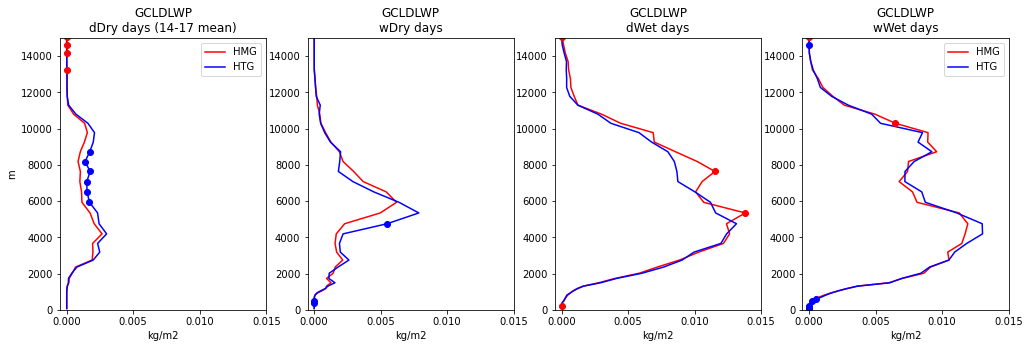

In [215]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CLOUD', minLev, 15000,
#                            -0.01, 0.3)
                           -0.005, 0.8)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CONCLD', minLev, 15000,
                           -0.01, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'GCLDLWP', minLev, 15000,
                           -0.0005, 0.015)


Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


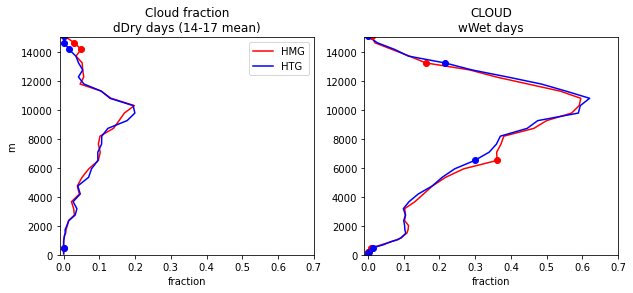

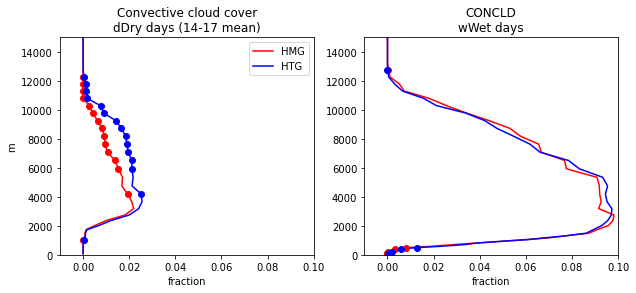

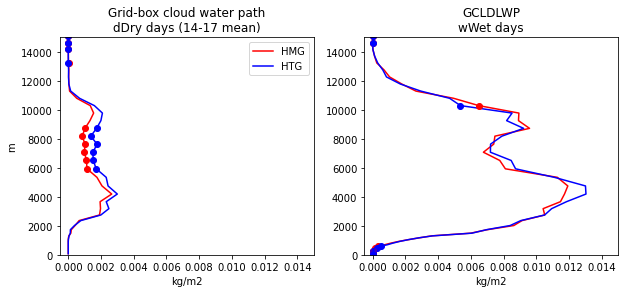

In [216]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUD', minLev, 15000,
#                            -0.01, 0.3)
                           -0.01, 0.7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CONCLD', minLev, 15000,
                           -0.01, 0.1)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'GCLDLWP', minLev, 15000,
                           -0.0005, 0.015)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


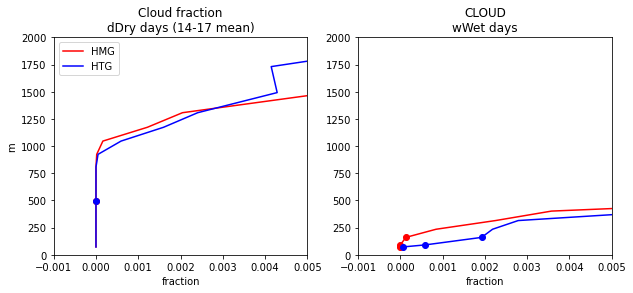

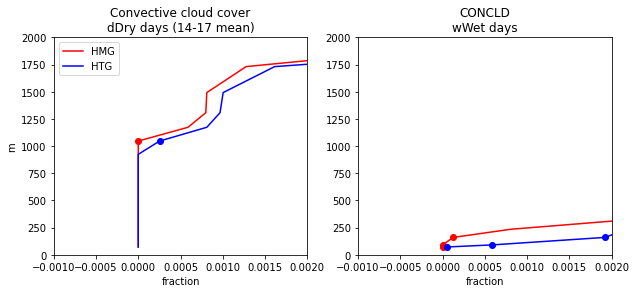

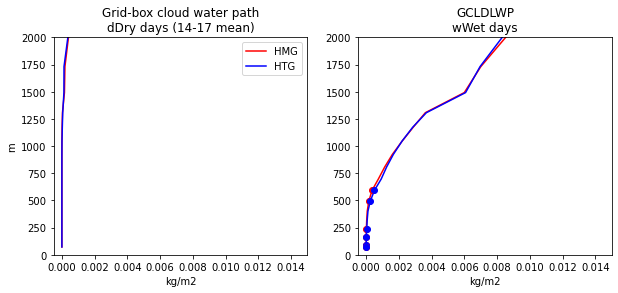

In [217]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(14,17, 'CLOUD', minLev, 2000,
#                            -0.01, 0.3)
                           -0.001, 0.005)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(14,17, 'CONCLD', minLev, 2000,
                           -0.001, 0.002)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(14,17, 'GCLDLWP', minLev,2000,
                           -0.0005, 0.015)




Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


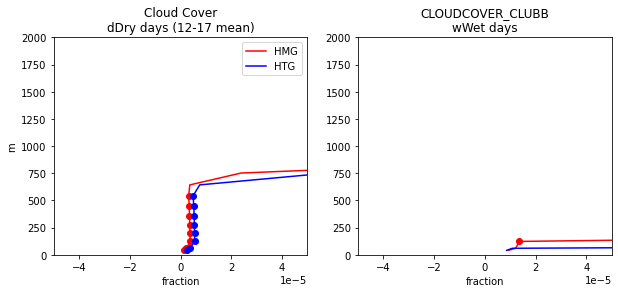

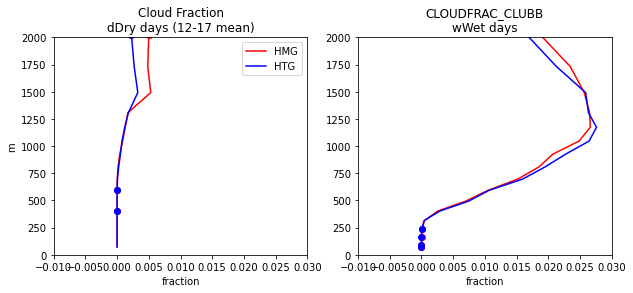

In [177]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUDCOVER_CLUBB', minLev, maxLev,
#                            -0.01, 0.1) 
                             -0.00005, 0.00005) 
# To zoom in on dry day increase in HTG cloudcover_clubb: -0.00001, 0.00001)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUDFRAC_CLUBB', minLev, maxLev,
                           -0.01, 0.03)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


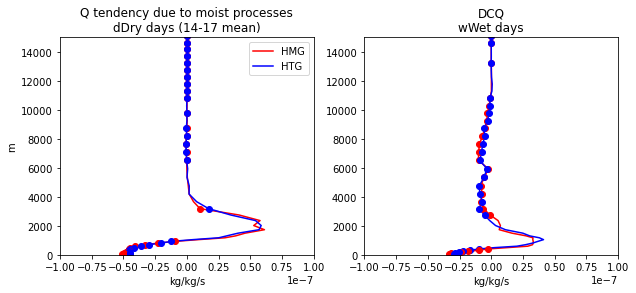

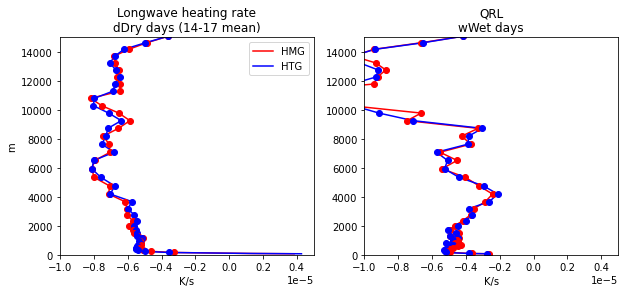

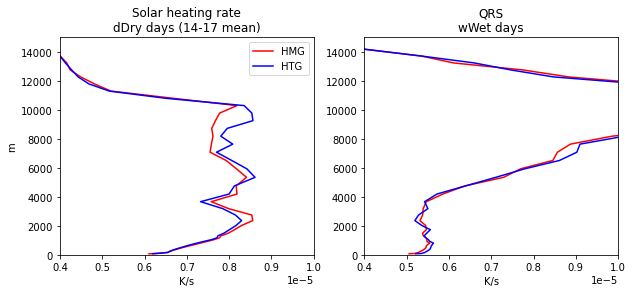

In [223]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DCQ', minLev, 15000,
                           -0.1e-6, 0.1e-6) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTCOND', 800,
#                            0, 15e-5) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTV', 800,
#                            -1e-8, 1e-8) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRL', minLev, 15000,
                           -1e-5, 0.5e-5) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRS', minLev, 15000,
                           0.4e-5, 1e-5) 


Means computed over the inclusive period of 9 to 12.
Means computed over the inclusive period of 9 to 12.
Means computed over the inclusive period of 9 to 12.


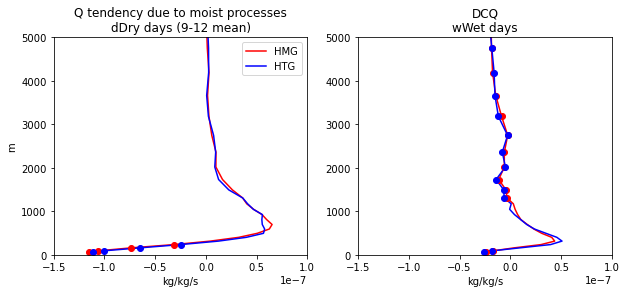

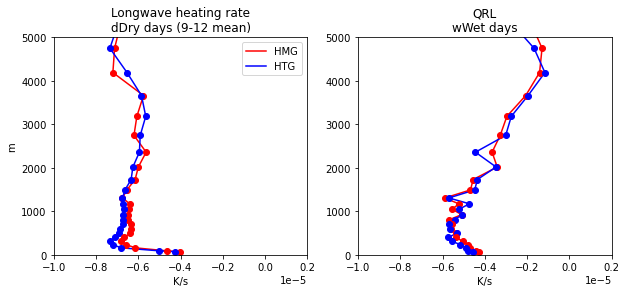

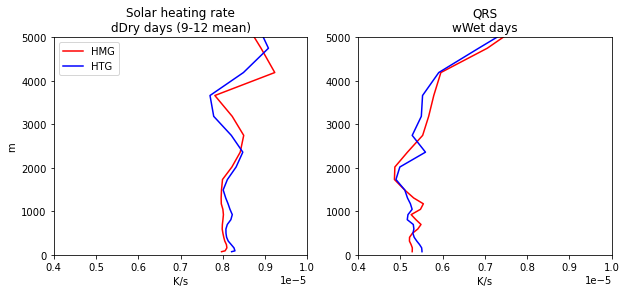

In [219]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'DCQ', minLev, 5000,
                           -0.15e-6, 0.1e-6) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTCOND', 800,
#                            0, 15e-5) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTV', 800,
#                            -1e-8, 1e-8) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'QRL', minLev, 5000,
                           -1e-5, 0.2e-5) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'QRS', minLev, 5000,
                           0.4e-5, 1e-5) 



Means computed over the inclusive period of 14 to 17.


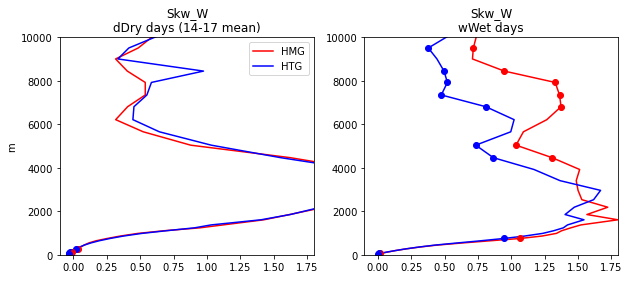

In [220]:

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Skw_W', minLev, maxLev,
#                            -0.02, 0.1)
                           -0.1, 1.8)


Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


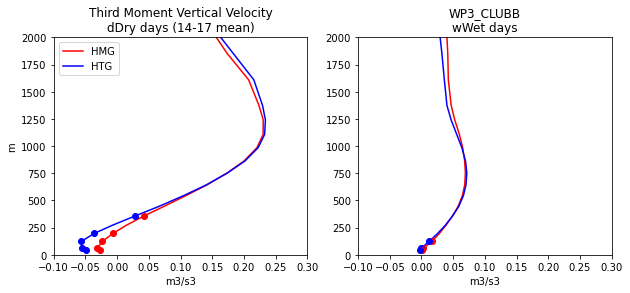

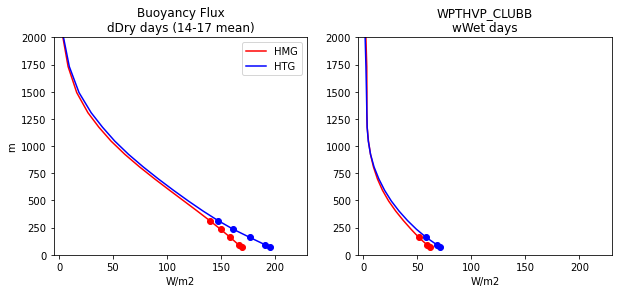

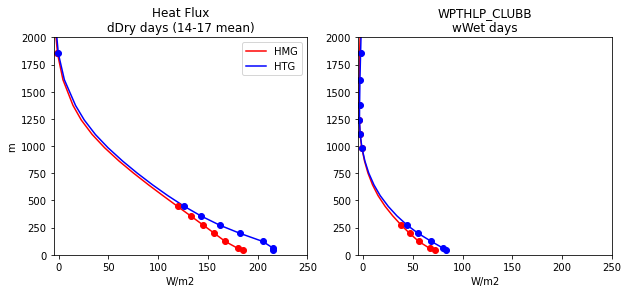

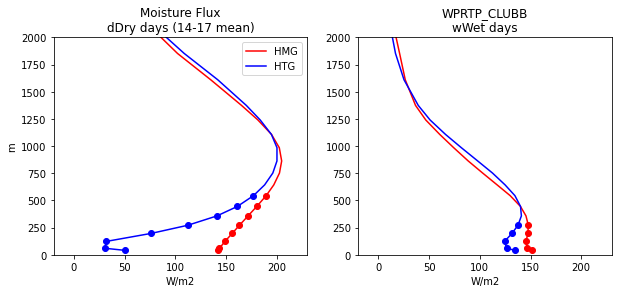

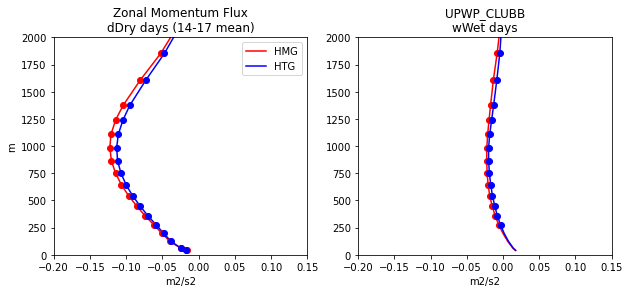

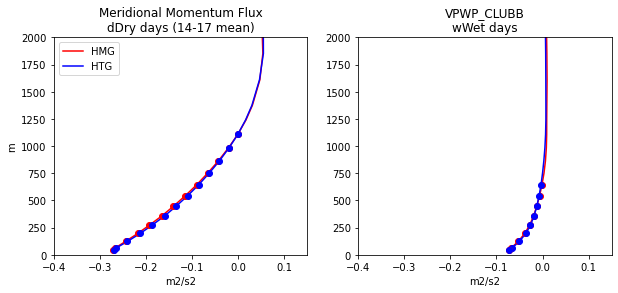

In [221]:
maxLev=2000

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP3_CLUBB', minLev, maxLev,
#                            -0.02, 0.1)
                           -0.1, 0.3)


plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHVP_CLUBB', minLev, maxLev,
#                            -5, 60)
                           -5, 230)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHLP_CLUBB', minLev, maxLev,
#                            -5, 80)
                           -5, 250)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPRTP_CLUBB', minLev, maxLev,
#                            -10, 120)
                            -20, 230)       

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UPWP_CLUBB', minLev, maxLev,
#                            0.0, 2.0)
                             -0.2, 0.15)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'VPWP_CLUBB', minLev, maxLev,
#                            0.0, 2.0)
                             -0.4, 0.15)

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WM_ZT_CLUBB', minLev, maxLev,
# #                            0.0, 2.0)
#                              -0.01, 0.002)

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'STEND_CLUBB', minLev, maxLev,
#                             -0.01, 0.3)   

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UTEND_CLUBB', minLev, maxLev,
#                             -0.2e-3, 0.5e-3)   

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RCMTEND_CLUBB', maxLev,
#                             -0.5e-10, 0.5e-10)   


Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


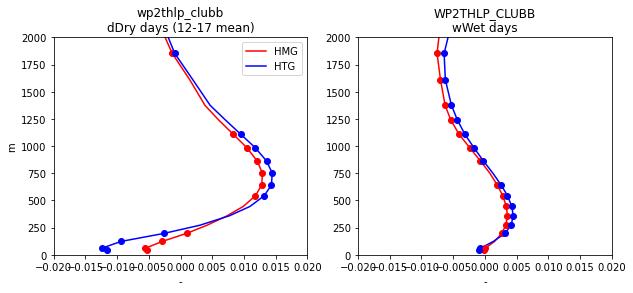

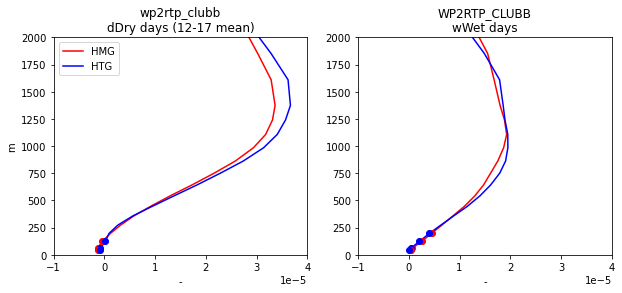

In [182]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP2THLP_CLUBB', minLev, maxLev,
#                            -5, 60)
                           -2e-2, 2e-2)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP2RTP_CLUBB', minLev, maxLev,
#                            -5, 80)
                           -1e-5, 4e-5)

Means computed over the inclusive period of 12 to 17.


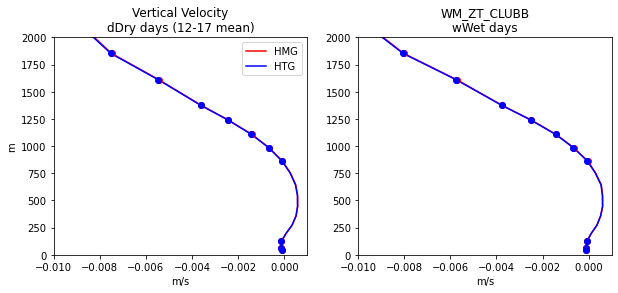

In [183]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WM_ZT_CLUBB', minLev, maxLev,
#                            -5, 60)
                           -10e-3, 1e-3)

Means computed over the inclusive period of 9 to 12.


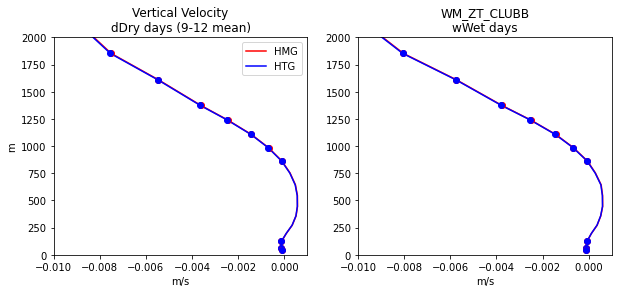

In [163]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'WM_ZT_CLUBB', minLev, maxLev,
#                            -5, 60)
                           -10e-3, 1e-3)

Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


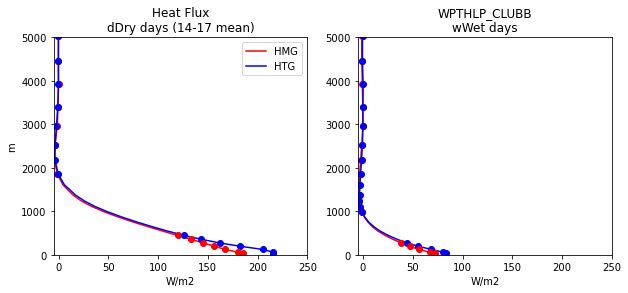

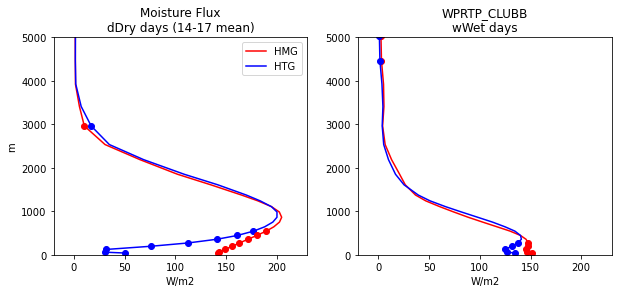

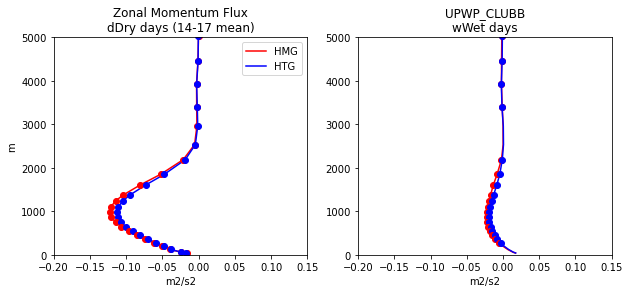

In [222]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHLP_CLUBB', minLev, 5000,
#                            -5, 80)
                           -5, 250)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPRTP_CLUBB', minLev, 5000,
#                            -10, 120)
                            -20, 230)       

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UPWP_CLUBB', minLev, 5000,
#                            0.0, 2.0)
                             -0.2, 0.15)

Means computed over the inclusive period of 9 to 12.
Means computed over the inclusive period of 9 to 12.
Means computed over the inclusive period of 9 to 12.


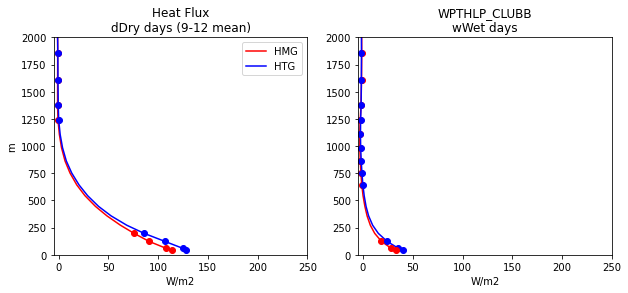

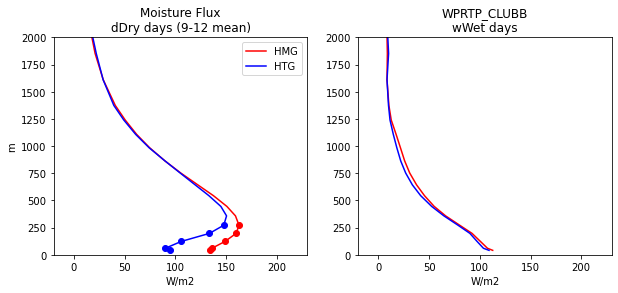

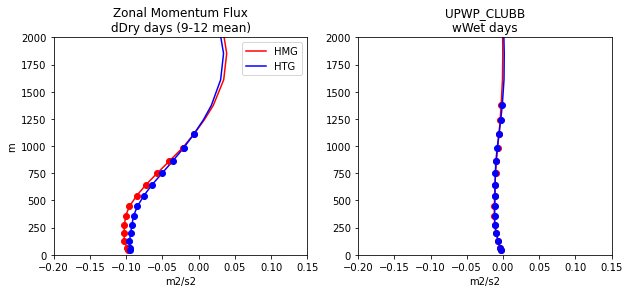

In [162]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'WPTHLP_CLUBB', minLev, 2000,
#                            -5, 80)
                           -5, 250)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'WPRTP_CLUBB', minLev, 2000,
#                            -10, 120)
                            -20, 230)       

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(9,12, 'UPWP_CLUBB', minLev, 2000,
#                            0.0, 2.0)
                             -0.2, 0.15)

Taking means over 14-17 h (local time)


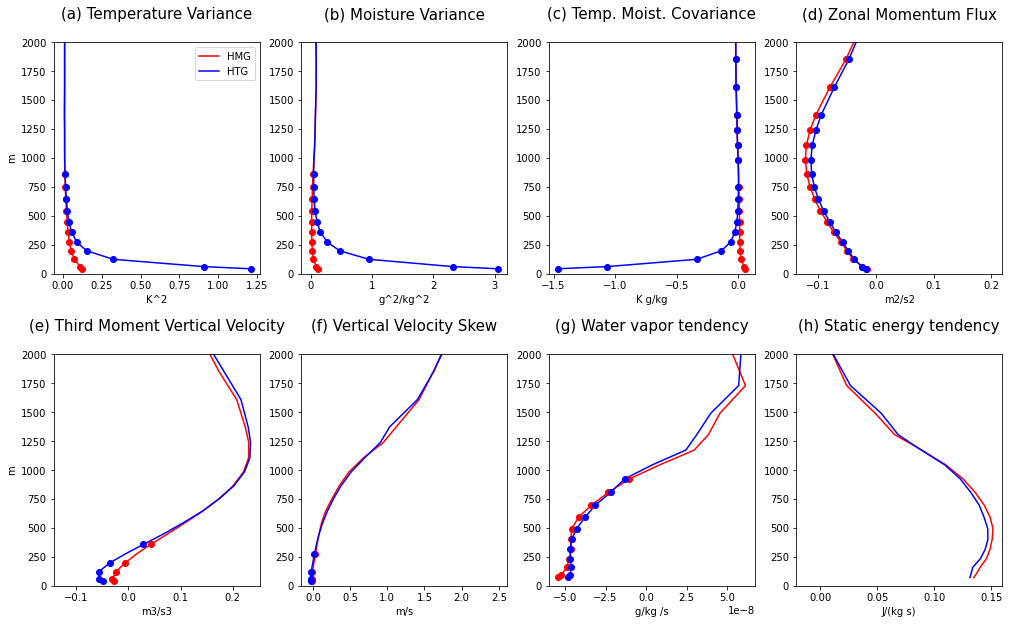

In [281]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UPWP_CLUBB',
#                      'WP3_CLUBB','Skw_W','WPTHLP_CLUBB','WPRTP_CLUBB'])
                       'WP3_CLUBB','Skw_W','RVMTEND_CLUBB','STEND_CLUBB'])
startHr = 14
endHr   = 17
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(8):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='Skw_W':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Vertical Velocity Skew\n', fontsize=15)
        unitLabel = 'm/s'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])





Taking means over 14-17 h (local time)


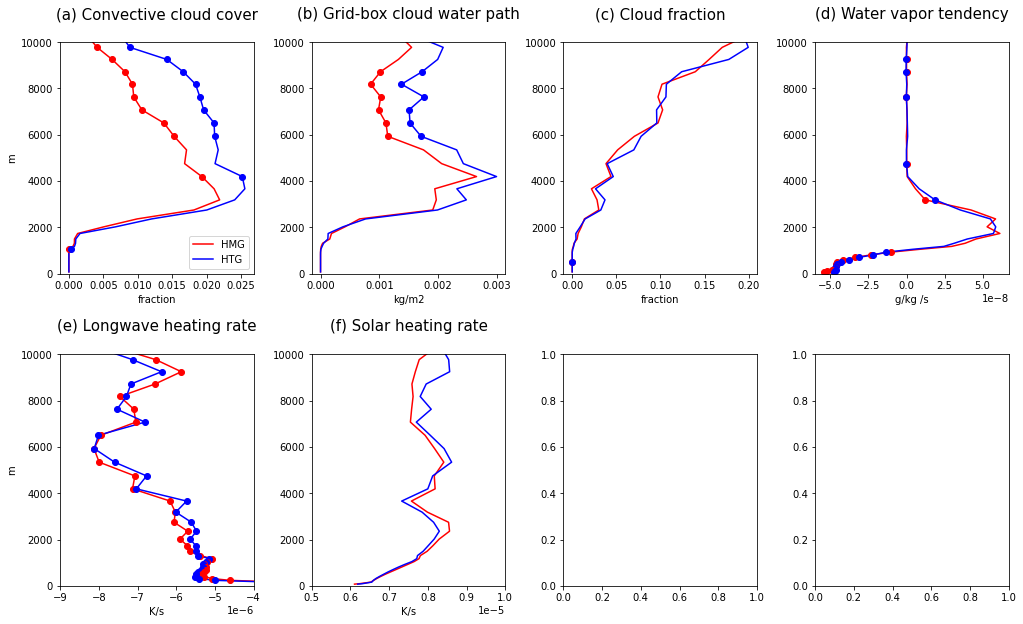

In [300]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['CONCLD','GCLDLWP','CLOUD','RVMTEND_CLUBB','QRL','QRS'])
startHr = 14
endHr   = 17
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35,wspace=0.3)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,10000])

    if varList[iPlot]=='QRL':
        axs[iPlot].set_xlim([-0.9e-5, -.4e-5])
    elif varList[iPlot]=='QRS':
        axs[iPlot].set_xlim([0.5e-5, 1e-5])






Taking means over 14-17 h (local time)


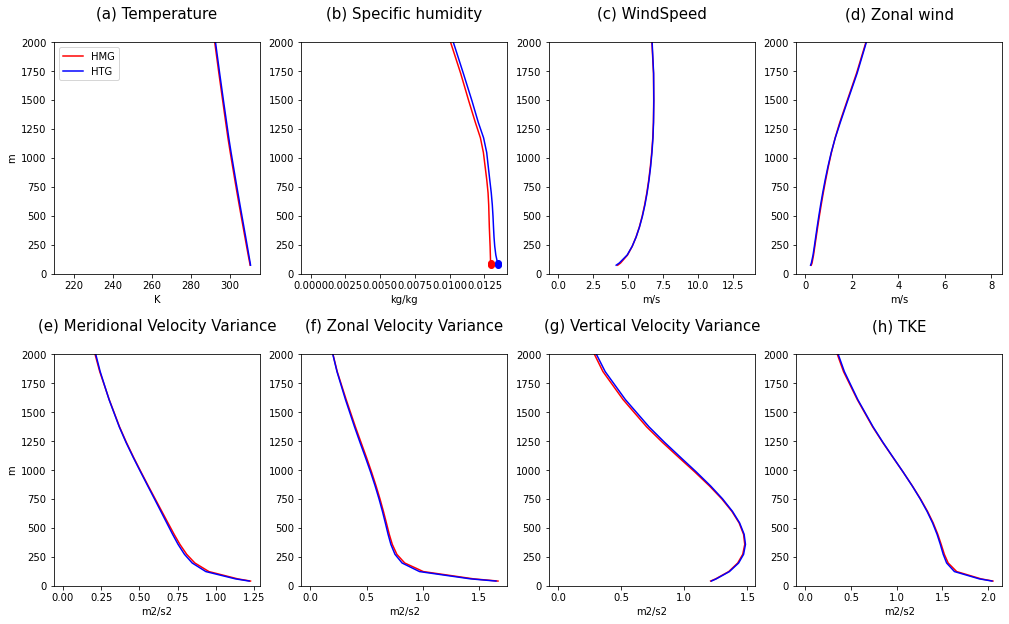

In [375]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
startHr = 14
endHr   = 17
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])






Text(0.5, 1.0, 'du/dz')

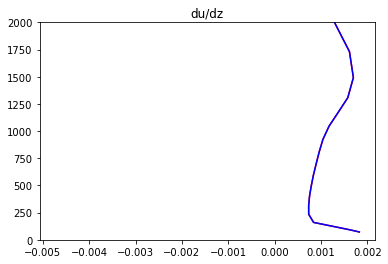

In [257]:
iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                        (dDryDays_HMG["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                        (dDryDays_HTG["time.hour"].values<=endHr))[0]


hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')

pvar        = hourlyMean_dDryTimeSel_HMG['U'].isel(lat=0,lon=0)
pvar['lev'] = HMGcamDS_local['lev'].values
dvardzHMG   = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

pvarHTG        = hourlyMean_dDryTimeSel_HTG['U'].isel(lat=0,lon=0)
pvarHTG['lev'] = HTGcamDS_local['lev'].values
dvardzHTG      = pvarHTG.differentiate("lev") # Find field gradient wrt HEIGHT!

plt.plot(dvardzHMG,HMGcamDS_local['lev'].values,'r')
plt.plot(dvardzHMG,HTGcamDS_local['lev'].values,'b')
plt.ylim([0,2000])
plt.title('du/dz')


Text(0.5, 1.0, 'dT/dz')

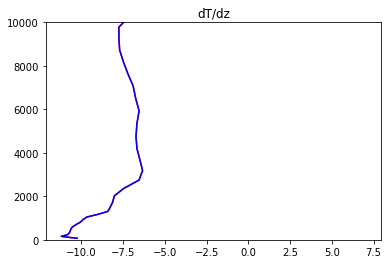

In [307]:
iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                        (dDryDays_HMG["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                        (dDryDays_HTG["time.hour"].values<=endHr))[0]


hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')

pvar        = hourlyMean_dDryTimeSel_HMG['T'].isel(lat=0,lon=0)
pvar['lev'] = HMGcamDS_local['lev'].values
dvardzHMG   = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

pvarHTG        = hourlyMean_dDryTimeSel_HTG['T'].isel(lat=0,lon=0)
pvarHTG['lev'] = HTGcamDS_local['lev'].values
dvardzHTG      = pvarHTG.differentiate("lev") # Find field gradient wrt HEIGHT!

plt.plot(dvardzHMG*1000,HMGcamDS_local['lev'].values,'r')
plt.plot(dvardzHMG*1000,HTGcamDS_local['lev'].values,'b')
plt.ylim([0,10000])
plt.title('dT/dz')
# plt.xlim([-0.012, -0.005])


Taking means over 8-11 h (local time)


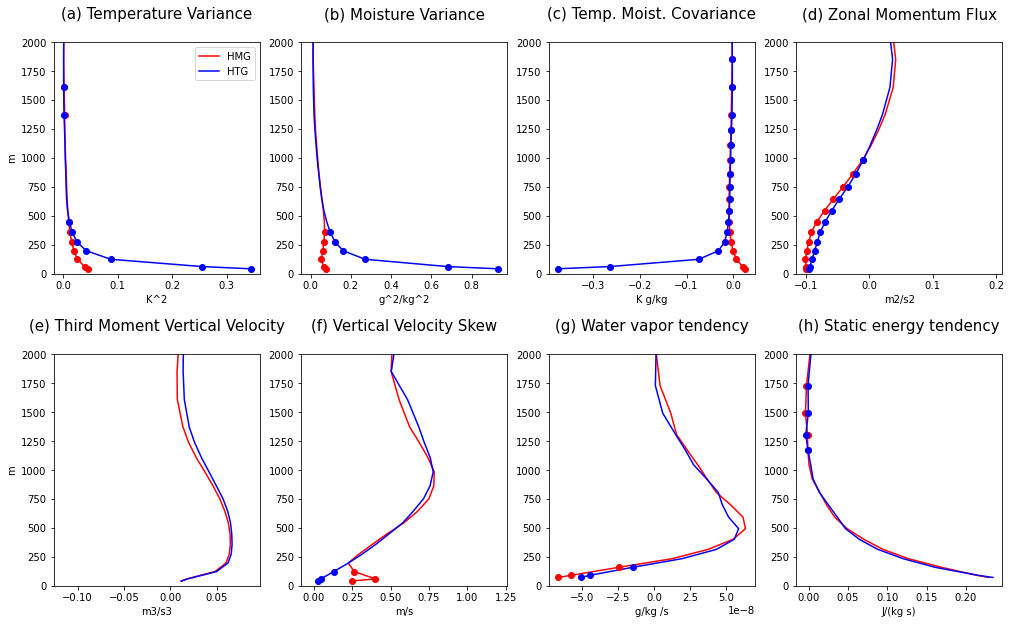

In [280]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UPWP_CLUBB',
#                      'WP3_CLUBB','Skw_W','WPTHLP_CLUBB','WPRTP_CLUBB'])
                       'WP3_CLUBB','Skw_W','RVMTEND_CLUBB','STEND_CLUBB'])
startHr = 8
endHr   = 11
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(8):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='Skw_W':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Vertical Velocity Skew\n', fontsize=15)
        unitLabel = 'm/s'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])




Taking means over 7-10 h (local time)


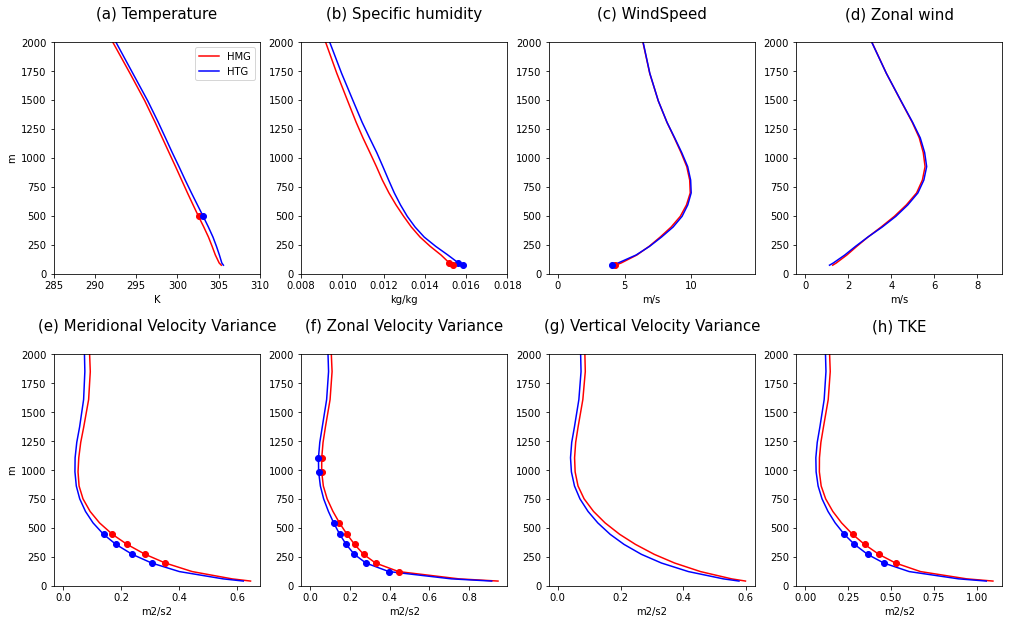

In [376]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
startHr = 7
endHr   = 10
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])

    if varList[iPlot]=='T':
        axs[iPlot].set_xlim([285,310])
    elif varList[iPlot]=='Q':
        axs[iPlot].set_xlim([0.008, 0.018])



Taking means over 7-19 h (local time)


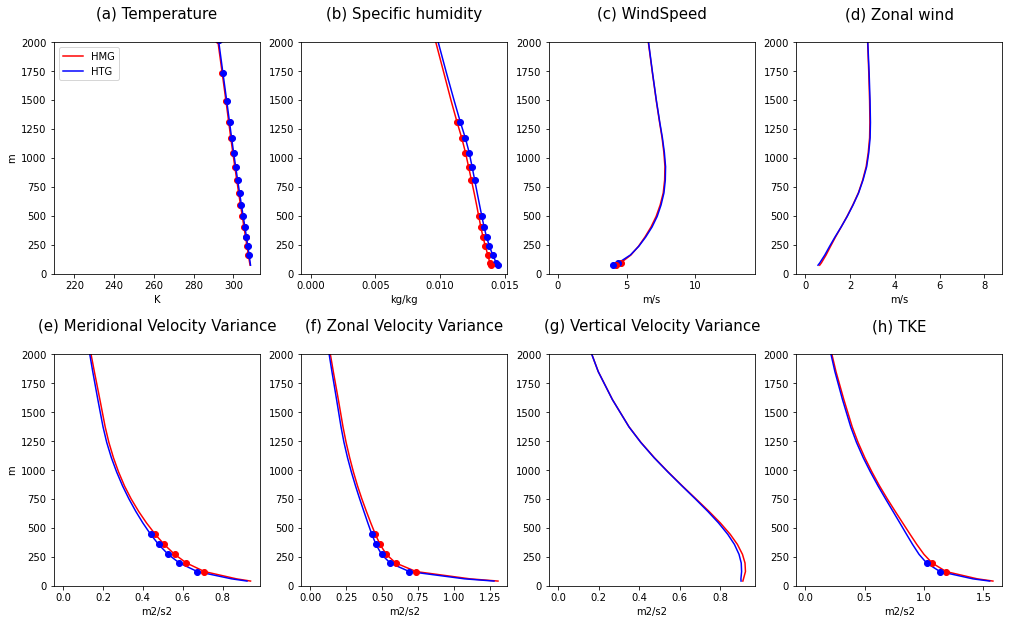

In [374]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
startHr = 7
endHr   = 19
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])






Taking means over 12-17 h (local time)


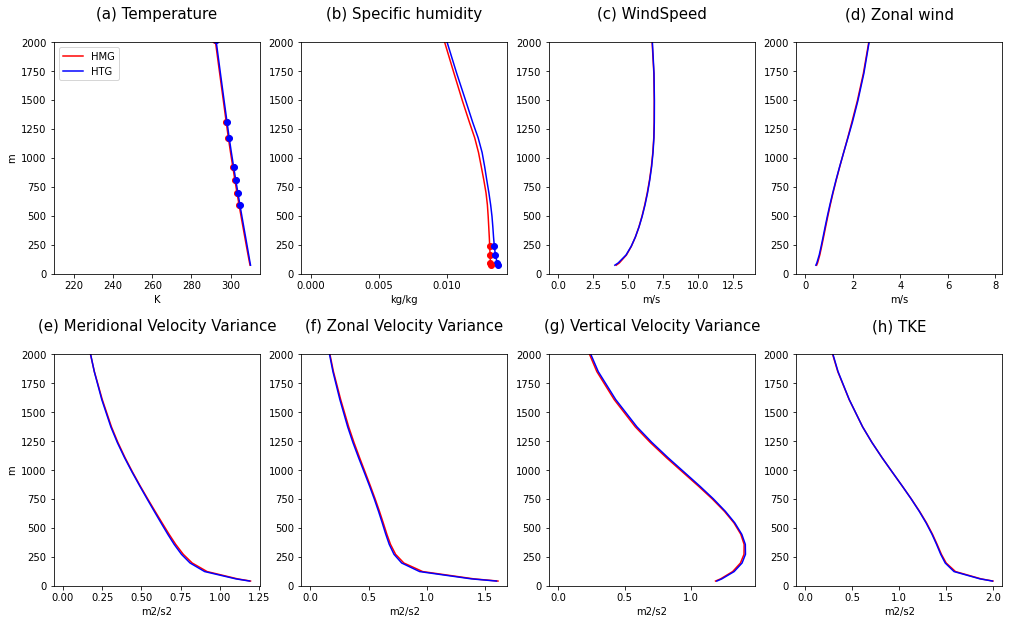

In [373]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
startHr = 12
endHr   = 17
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])





